In [1]:
import pandas as pd
import warnings
import numpy as np
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')
from pandas import to_timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import statsmodels.api as sm
from datetime import datetime
from datetime import datetime, timedelta
# from causalimpact import CausalImpact
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
import math
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Constant 

In [60]:
#month, day, hour
daylight_dates = {
    2016: {'start': datetime(2016,3,13), 'end':datetime(2016,11,6)},
    2017: {'start': datetime(2017, 3, 12), 'end':datetime(2017,11, 5)},
    2018: {'start': datetime(2018, 3, 11), 'end':datetime(2018, 11, 4)},
    2019: {'start': datetime(2019, 3, 10), 'end':datetime(2019, 11, 3)},
    2020: {'start': datetime(2020, 3, 8), 'end':datetime(2020, 11, 1)},
    2021: {'start': datetime(2021, 3, 14), 'end':datetime(2021, 11, 7)},
}

number_of_day_in_month = {
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31, 
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

# https://www.statista.com/statistics/196010/total-number-of-registered-automobiles-in-the-us-by-state/
number_of_car_by_state = {
    "AZ": 2410018,
    "NV": 1027503,
    "UT": 902723,
    "CO": 1639028,
    "NM": 623955
}

SWester_states = ['NV', 'UT', 'AZ', 'CO', 'NM']

## Auxiliaries functions

In [69]:
def complete_df_unmeasure(df):
    """
    Itterates over the dates and if a day not measure add the date with 0
    """
    zero_row = {c: 0 for c in df.columns}
    min_date = min(df['Date'])
    max_date = max(df['Date'])
    for d in pd.date_range(min_date,max_date - timedelta(days=1),freq='d'):
        if len(df[df['Date'] == d]) == 0:
            zero_row['Date'] = d
            zero_row['Year'] = d.year
            df = df.append(zero_row, ignore_index = True)
    return df
            

    
def split_by_date_gap(df, start_gap_days=1, end_gap_days=1, dst='Winter'):
    """
    filter the df to only wanted time interval around the dst (winter\summer) for each year.
    e.g. 
    df_filter = (df between [dst_date - start_gap, dst_time]) and (df between [dst_date, dst_time + end_gap])
    """
    dst = 'end' if dst == 'Winter' else 'start'
    df_filterd = None
    for year in daylight_dates.keys():
        dst_time = daylight_dates[year][dst]
        if start_gap_days > 0:
            start_int = dst_time -  pd.to_timedelta(start_gap_days, unit='d')
        if end_gap_days > 0:
            end_int = dst_time +  pd.to_timedelta(end_gap_days, unit='d')
       
        if start_gap_days < 0:
            if end_gap_days < 0:
                raise Exception('No gap')
            else:
                mask = (df['Date'] <= end_int)
        else:
            if end_gap_days < 0:
                mask = (df['Date'] > start_int)
            else:          
                mask = (df['Date'] > start_int) & (df['Date'] <= end_int)
            
        filter_df_year = df[mask]
        if df_filterd is not None:
            df_filterd = pd.concat([df_filterd, filter_df_year])
        else:
            df_filterd = filter_df_year.copy()
    return df_filterd


def OLS(df, gap_day_before, gap_day_after,
                 agg_fun='mean', plot_OSL_summary = False, dst='Winter', years=[2017], avg_year=False, print_res=False):
    """

    """
    # dummpy var
    df['Y'] = 1
    
    df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.date
    df = df.groupby(['Start_Time']).sum().reset_index('Start_Time').rename(columns={"Start_Time": "Date"})
    df['Date'] = pd.to_datetime(df['Date'])
    
     # add year
    df['Year'] = pd.to_datetime(df['Date'], errors='coerce').dt.year
    df = df[df.Year.isin(years)]
    
    df = complete_df_unmeasure(df)
    
    filterd_df = split_by_date_gap(df, start_gap_days=gap_day_before, end_gap_days=gap_day_after, dst=dst)
                
    dst = 'end' if dst == 'Winter' else 'start'
    
    filterd_df['T'] = filterd_df.apply(
        lambda x: (x['Date'] - daylight_dates[x['Year']][dst]).days 
                if (x['Date'] - daylight_dates[x['Year']][dst]).days  >=0  else
                (x['Date'] - daylight_dates[x['Year']][dst]).days, axis=1)
    
    filterd_df = filterd_df.drop(columns=['Date']) 
        
    if avg_year:
        filterd_df = filterd_df.groupby(['T']).mean().reset_index('T')
        
    pre_df = filterd_df[filterd_df['T'] < 0]
    #pre_df.loc['T'] = 0
    after_df = filterd_df[filterd_df['T'] >= 0]
    
    model_pre = smf.ols(formula="Y ~ T", data=pre_df)
    model_after = smf.ols(formula="Y ~ T", data=after_df)
    
    res_pre = model_pre.fit()
    res_after = model_after.fit()
    
    if plot_OSL_summary:
        print(res_pre.summary())
        
       
    # Get model predictions and 95% confidence interval
    pre_model_predictions_pre = res_pre.get_prediction(pre_df)
    pre_model_predictions_after = res_pre.get_prediction(after_df).summary_frame(alpha=0.05)
    after_model_predictions_after = res_after.get_prediction(after_df)
    
    y_pre_model_pre = pre_model_predictions_pre.predicted_mean
    y_after_model_after = after_model_predictions_after.predicted_mean
    
    if print_res:
        res_pre.resid.plot(kind="kde")
        
    # Plotting
    fig, ax = plt.subplots(figsize=(16,10))

    # Plot bounce rate data
    ax.scatter(filterd_df["T"], filterd_df["Y"], facecolors='none', edgecolors='steelblue', label="Accident for a day", linewidths=2)
    
    # Plot model mean bounce rate prediction
    ax.plot(pre_df["T"], y_pre_model_pre, 'b-', label="model prediction")
    ax.plot(after_df["T"], y_after_model_after, 'b-')

    # Plot counterfactual mean bounce rate with 95% confidence interval
    ax.plot(after_df["T"], pre_model_predictions_after['mean'], 'k.', label="counterfactual")
    ax.fill_between(after_df["T"], pre_model_predictions_after['mean_ci_lower'], pre_model_predictions_after['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI");


    # Plot line marking intervention moment
    ax.axvline(x = 0, color = 'r', label = 'intervention')

    ax.legend(loc='best')
    plt.xlabel("Days from DST")
    plt.ylabel("Accident for day");
    
    did = after_df['Y'].mean() - pre_model_predictions_after['mean'].mean()
    print(did)
    return did
    
def OLSC(df, gap_day_before, gap_day_after,
                 agg_fun='mean', plot_OSL_summary = False, dst='Winter', years=[2017], avg_year=False, print_res=False):
    """

    """
    # dummpy var
    df['Y'] = 1
    
    df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.date
    agg_fun = {}
    for c in df.columns:
        if c == 'Y':
            agg_fun[c] = np.sum
        elif c == 'Start_Time' or c == 'State':
            continue
        else:
            agg_fun[c] = np.mean
    df = df.groupby(['Start_Time']).agg(agg_fun).reset_index('Start_Time').rename(columns={"Start_Time": "Date"})
    df = df.fillna(value=0)
    df['Date'] = pd.to_datetime(df['Date'])
    
     # add year
    df['Year'] = pd.to_datetime(df['Date'], errors='coerce').dt.year
    df = df[df.Year.isin(years)]
    
    df = complete_df_unmeasure(df)
    
    filterd_df = split_by_date_gap(df, start_gap_days=gap_day_before, end_gap_days=gap_day_after, dst=dst)
                
    dst = 'end' if dst == 'Winter' else 'start'
    
    filterd_df['T'] = filterd_df.apply(
        lambda x: (x['Date'] - daylight_dates[x['Year']][dst]).days 
                if (x['Date'] - daylight_dates[x['Year']][dst]).days  >=0  else
                (x['Date'] - daylight_dates[x['Year']][dst]).days, axis=1)
    
    filterd_df = filterd_df.drop(columns=['Date'])
    
    model_explain_cols = [c for c in filterd_df.columns if c != 'Y' and c != 'Year']
    model_explain_cols_str = 'Y ~ ' + ' + '.join(model_explain_cols)
        
    if avg_year:
        filterd_df = filterd_df.groupby(['T']).mean().reset_index('T')

    pre_df = filterd_df[filterd_df['T'] < 0]
    after_df = filterd_df[filterd_df['T'] >= 0]

    model_pre = smf.ols(formula=model_explain_cols_str, data=pre_df)
    model_after = smf.ols(formula=model_explain_cols_str, data=after_df)
    
    res_pre = model_pre.fit()
    res_after = model_after.fit()
    
    if plot_OSL_summary:
        print(res_pre.summary())
        
       
    # Get model predictions and 95% confidence interval
    pre_model_predictions_pre = res_pre.get_prediction(pre_df)
    pre_model_predictions_after = res_pre.get_prediction(after_df).summary_frame(alpha=0.05)
    after_model_predictions_after = res_after.get_prediction(after_df)
    y_pre_model_pre = pre_model_predictions_pre.predicted_mean
    y_after_model_after = after_model_predictions_after.predicted_mean
    
    if print_res:
        res_pre.resid.plot(kind="kde")
        
    # Plotting
    fig, ax = plt.subplots(figsize=(16,10))

    # Plot bounce rate data
    ax.scatter(filterd_df["T"], filterd_df["Y"], facecolors='none', edgecolors='steelblue', label="Accident for a day", linewidths=2)
     
    # Plot counterfactual mean bounce rate with 95% confidence interval
    ax.plot(after_df["T"], pre_model_predictions_after['mean'], 'k.', label="counterfactual")

    # Plot line marking intervention moment
    ax.axvline(x = 0, color = 'r', label = 'intervention')

    ax.legend(loc='best')
    plt.xlabel("Days from DST")
    plt.ylabel("Accident for day");
    
    did = after_df['Y'].mean() - pre_model_predictions_after['mean'].mean()
    print(did , ',')
    return did


def check_stationry(df, diff=0):
    df['Y'] = 1
    
    df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.date
    df = df.groupby(['Start_Time']).sum().reset_index('Start_Time').rename(columns={"Start_Time": "Date"}).sort_values(by=['Date'])
    X = df['Y']
    if diff != 0 :
        X = X.diff(periods=diff).dropna()
    result = adfuller(X.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    return X



def arima(df, gap_day_before, gap_day_after,
          agg_fun='mean', plot_summary = False, dst='Winter', years=[2017], avg_year=False, print_res=False, orders = (4,1,4)):
    """

    """
    # dummpy var
    df['Y'] = 1

    df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.date
    df = df.groupby(['Start_Time']).sum().reset_index('Start_Time').rename(columns={"Start_Time": "Date"})
    df['Date'] = pd.to_datetime(df['Date'])

    # add year
    df['Year'] = pd.to_datetime(df['Date'], errors='coerce').dt.year
    df = df[df.Year.isin(years)]

    df = complete_df_unmeasure(df)

    filterd_df = split_by_date_gap(df, start_gap_days=gap_day_before, end_gap_days=gap_day_after, dst=dst)

    dst = 'end' if dst == 'Winter' else 'start'

    filterd_df['T'] = filterd_df.apply(
        lambda x: (x['Date'] - daylight_dates[x['Year']][dst]).days
        if (x['Date'] - daylight_dates[x['Year']][dst]).days  >=0  else
        (x['Date'] - daylight_dates[x['Year']][dst]).days, axis=1)

    filterd_df = filterd_df.drop(columns=['Date'])

    if avg_year:
        filterd_df = filterd_df.groupby(['T']).mean().reset_index('T')

    pre_df = filterd_df[filterd_df['T'] < 0]
    after_df = filterd_df[filterd_df['T'] >= 0]

    model_pre = ARIMA(pre_df['Y'],pre_df['T'], order=orders).fit()


    if plot_summary:
        print(res_pre.summary())


    # Get model predictions and 95% confidence interval
    full_pre = model_pre.get_prediction(0,  gap_day_before - 2)
    pre_model_predictions_after = model_pre.get_forecast(gap_day_after+1, exog=after_df["T"]).summary_frame(alpha=0.05)

    y_pred =  full_pre.predicted_mean

    if print_res:
        Y = np.array(pre_df.sort_values(by=['T'])["Y"].values)
        X = pre_df.sort_values(by=['T'])["T"].values
        res = y_pred[:gap_day_before] - Y
        sns.scatterplot(x=X, y=res).set_title('Residual graph')

    # Plotting
    fig, ax = plt.subplots(figsize=(16,10))

    # Plot bounce rate data
    ax.scatter(filterd_df["T"], filterd_df["Y"], facecolors='none', edgecolors='steelblue', label="Accident for a day", linewidths=2)

    # Plot model mean bounce rate prediction
    X = filterd_df["T"].values
    X.sort()
    ax.plot(X[:gap_day_before - 1], y_pred[:gap_day_before - 1], 'b-', label="model prediction")

    # Plot counterfactual mean bounce rate with 95% confidence interval
    ax.plot(after_df["T"], pre_model_predictions_after['mean'], 'k.', label="counterfactual")
    ax.fill_between(after_df["T"], pre_model_predictions_after['mean_ci_lower'], pre_model_predictions_after['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI");


    # Plot line marking intervention moment
    ax.axvline(x = 0, color = 'r', label = 'intervention')

    ax.legend(loc='best')
    plt.xlabel("Days from DST")
    plt.ylabel("Accident for day");

    did = after_df['Y'].mean() - pre_model_predictions_after['mean'].mean()
    print(did)

    return did

def plot_auto_close_to_dst(df, gap_day_before, gap_day_after, dst='Winter', years=[2017],  lags=None):
     # dummpy var
    df['Y'] = 1
    
    df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.date
    df = df.groupby(['Start_Time']).sum().reset_index('Start_Time').rename(columns={"Start_Time": "Date"})
    df['Date'] = pd.to_datetime(df['Date'])
    
     # add year
    df['Year'] = pd.to_datetime(df['Date'], errors='coerce').dt.year
    df = df[df.Year.isin(years)]
    
    df = complete_df_unmeasure(df)
    
    filterd_df = split_by_date_gap(df, start_gap_days=gap_day_before, end_gap_days=gap_day_after, dst=dst)
                
    dst = 'end' if dst == 'Winter' else 'start'
    
    filterd_df['T'] = filterd_df.apply(
        lambda x: (x['Date'] - daylight_dates[x['Year']][dst]).days 
                if (x['Date'] - daylight_dates[x['Year']][dst]).days  >=0  else
                (x['Date'] - daylight_dates[x['Year']][dst]).days, axis=1)
    
    sm.graphics.tsa.plot_acf(df['Y'], lags=lags)
    sm.graphics.tsa.plot_pacf(df['Y'], lags=lags)
    plt.show()
    
    


In [4]:
df = pd.read_csv('US_Accidents_Dec21_updated.csv')

In [5]:
df

ID  Severity           Start_Time             End_Time  \
0              A-1         3  2016-02-08 00:37:08  2016-02-08 06:37:08   
1              A-2         2  2016-02-08 05:56:20  2016-02-08 11:56:20   
2              A-3         2  2016-02-08 06:15:39  2016-02-08 12:15:39   
3              A-4         2  2016-02-08 06:51:45  2016-02-08 12:51:45   
4              A-5         3  2016-02-08 07:53:43  2016-02-08 13:53:43   
...            ...       ...                  ...                  ...   
2845337  A-2845338         2  2019-08-23 18:03:25  2019-08-23 18:32:01   
2845338  A-2845339         2  2019-08-23 19:11:30  2019-08-23 19:38:23   
2845339  A-2845340         2  2019-08-23 19:00:21  2019-08-23 19:28:49   
2845340  A-2845341         2  2019-08-23 19:00:21  2019-08-23 19:29:42   
2845341  A-2845342         2  2019-08-23 18:52:06  2019-08-23 19:21:31   

         Start_Lat   Start_Lng    End_Lat     End_Lng  Distance(mi)  \
0        40.108910  -83.092860  40.112060  -83.031870         3.230   
1        39.865420  -84.062800  39.865010  -84.048730         0.747   
2        39.102660  -84.524680  39.102090  -84.523960         0.055   
3        41.062130  -81.537840  41.062170  -81.535470         0.123   
4        39.172393  -84.492792  39.170476  -84.501798         0.500   
...            ...         ...        ...         ...           ...   
2845337  34.002480 -117.379360  33.998880 -117.370940         0.543   
2845338  32.766960 -117.148060  32.765550 -117.153630         0.338   
2845339  33.775450 -117.847790  33.777400 -117.857270         0.561   
2845340  33.992460 -118.403020  33.983110 -118.395650         0.772   
2845341  34.133930 -117.230920  34.137360 -117.239340         0.537   

                                               Description  ...  Roundabout  \
0        Between Sawmill Rd/Exit 20 and OH-315/Olentang...  ...       False   
1                       At OH-4/OH-235/Exit 41 - Accident.  ...       False   
2                         At I-71/US-50/Exit 1 - Accident.  ...       False   
3                          At Dart Ave/Exit 21 - Accident.  ...       False   
4                       At Mitchell Ave/Exit 6 - Accident.  ...       False   
...                                                    ...  ...         ...   
2845337                           At Market St - Accident.  ...       False   
2845338    At Camino Del Rio/Mission Center Rd - Accident.  ...       False   
2845339  At Glassell St/Grand Ave - Accident. in the ri...  ...       False   
2845340     At CA-90/Marina Fwy/Jefferson Blvd - Accident.  ...       False   
2845341              At Highland Ave/Arden Ave - Accident.  ...       False   

        Station   Stop Traffic_Calming Traffic_Signal Turning_Loop  \
0         False  False           False          False        False   
1         False  False           False          False        False   
2         False  False           False          False        False   
3         False  False           False          False        False   
4         False  False           False          False        False   
...         ...    ...             ...            ...          ...   
2845337   False  False           False          False        False   
2845338   False  False           False          False        False   
2845339   False  False           False          False        False   
2845340   False  False           False          False        False   
2845341   False  False           False          False        False   

        Sunrise_Sunset Civil_Twilight Nautical_Twilight Astronomical_Twilight  
0                Night          Night             Night                 Night  
1                Night          Night             Night                 Night  
2                Night          Night             Night                   Day  
3                Night          Night               Day                   Day  
4                  Day            Day               Day                   Day  
... 

## Tutorial

In [6]:
df = df[df.State.isin(SWester_states)]

In [7]:
tt = df[['Start_Time' ,'State' ,'Visibility(mi)', 'Precipitation(in)', 'Temperature(F)']]
tt = tt.rename(columns={"Visibility(mi)": "Visibility"})
tt = tt.rename(columns={"Precipitation(in)": "Precipitation"})
tt = tt.rename(columns={"Temperature(F)": "Temperature"})
# tt['fefe'] = 1

In [8]:
X = check_stationry(tt[tt['State'] == 'UT'], diff=1)

ADF Statistic: -11.278700
p-value: 0.000000


In [15]:
plot_auto_close_to_dst(X, 20, 7, years=[2017])

KeyError: 'Start_Time'

In [25]:
arima(tt[tt['State'] == 'UT'], 10, 3, years=[2017], print_res=False, orders=(30,1,3))

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

5.662476457781743

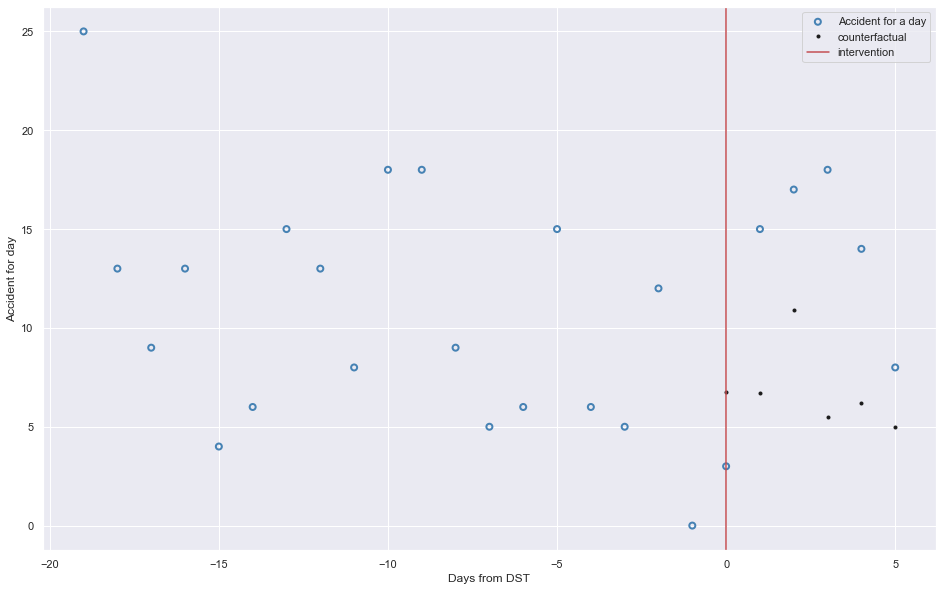

In [9]:
OLSC(tt[tt['State'] == 'AZ'], 20, 5, years=[2018], print_res=False, plot_OSL_summary=False)

-3.1535087719298263

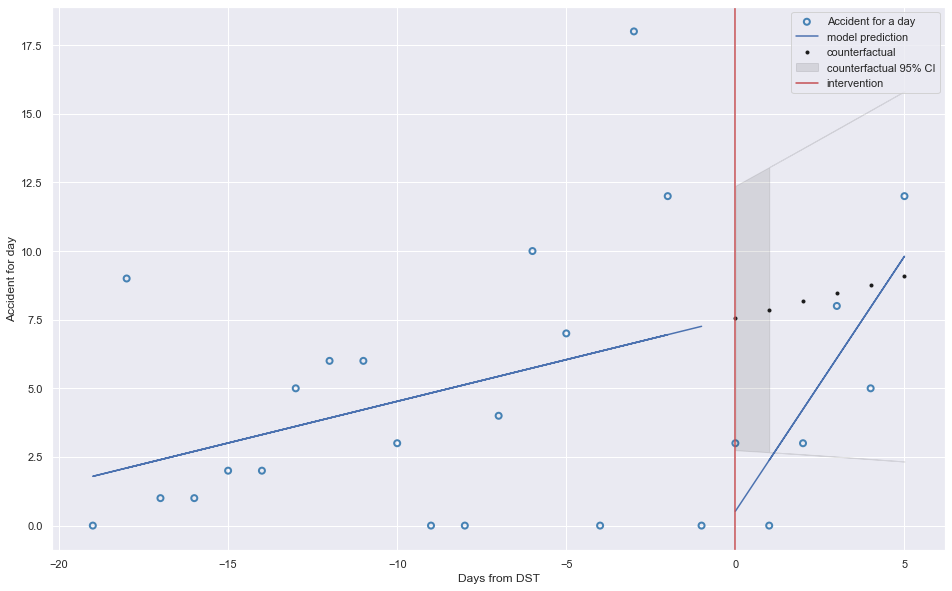

In [20]:
OLS(tt[tt['State'] == 'UT'], 20, 5, years=[2016], print_res=False, plot_OSL_summary=0)

In [84]:
import numpy as np
from scipy.stats import bootstrap
from scipy.stats import norm
AZ_winter = [8.890350877192981,
6.66228070175439,
8.026315789473689,
2.0263157894736814,
8.092105263157912,
-36.842105263157876]

AZ_summer = [
0.14035087719298645,
0.08333333333333215,
-1.7850877192982475,
1.9999999999999973,
-10.574561403508767]

UT_winter=[
-3.1535087719298263,
2.9736842105263133,
4.8289473684210495,
-3.421052631578931,
-10.60964912280702,
9.986842105263165]

UT_summer = [-2.605263157894737,
5.096491228070175,
-19.61403508771926,
0.9956140350877263,
-4.807017543859647]

NM_winter =[0.46491228070175,
0.6535087719298244,
-1.0219298245614032,
-0.3114035087719291,
-7.885964912280702,
-2.5219298245614046]

NM_summer = [0.7543859649122805
-0.0921052631578946,
0.09210526315789502,
-0.10526315789473645,
-2.469298245614035]

CO_winter = [5.285087719298245,
2.605263157894737,
-8.640350877192983,
4.517543859649123,
-12.758771929824567,
0.75]

CO_summer = [1.4385964912280689,
5.929824561403507,
4.7061403508771935,
0.3815789473684248,
1.1184210526315788]

NV_winter = [-0.5964912280701782,
0.5877192982456143,
1.2456140350877194,
-1.00438596491228,
-0.6315789473684212,
-0.39473684210526727]

NV_summer= [-0.6403508771929829,
0.49561403508771873,
-1.3684210526315792,
-0.09649122807017463,
-3.3508771929824563]


list_names = ['AZ_winter', 'AZ_summer','UT_winter', 'UT_summer','NM_winter','NM_summer' ,'CO_winter' , 'CO_summer','NV_winter', 'NV_summer' ]
data_lists =  [AZ_winter, AZ_summer,UT_winter, UT_summer,NM_winter,NM_summer ,CO_winter , CO_summer,NV_winter, NV_summer ]

In [26]:
arr = np.array(AZ_winter)
std_true = arr.std()      # the true value of the statistic
print(std_true)

16.396781611087675


In [39]:
 for dt in data_lists:
    print(list_names[data_lists.index(dt)])
    data = (dt,)
    #calculate 95% bootstrapped confidence interval for median
    bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,
                             random_state=1, method='percentile')

    #view 95% boostrapped confidence interval
    print(bootstrap_ci.confidence_interval)

AZ_winter
ConfidenceInterval(low=-15.396929824561392, high=8.108918128654977)
AZ_summer
ConfidenceInterval(low=-6.3017543859649106, high=0.8728070175438599)
UT_winter
ConfidenceInterval(low=-4.8414108187134435, high=5.414473684210532)
UT_summer
ConfidenceInterval(low=-12.53070175438594, high=2.0297807017541825)
NM_winter
ConfidenceInterval(low=-4.337719298245615, high=0.11915204678362368)
NM_summer
ConfidenceInterval(low=-1.8289473684210527, high=0.4703947368421053)
CO_winter
ConfidenceInterval(low=-6.951023391812868, high=3.698830409356725)
CO_summer
ConfidenceInterval(low=0.8877192982456151, high=4.722807017543858)
NV_winter
ConfidenceInterval(low=-0.7105263157894747, high=0.541666666666667)
NV_summer
ConfidenceInterval(low=-2.185087719298246, high=0.03157894736842106)


In [86]:
AZ = [8.890350877192981,
             6.66228070175439,
             8.026315789473689,
             2.0263157894736814,
             8.092105263157912,
             -36.842105263157876]

UT=[
    -3.1535087719298263,
    2.9736842105263133,
    4.8289473684210495,
    -3.421052631578931,
    -10.60964912280702,
    9.986842105263165]


NM =[0.46491228070175,
            0.6535087719298244,
            -1.0219298245614032,
            -0.3114035087719291,
            -7.885964912280702,
            -2.5219298245614046]


CO = [5.285087719298245,
             2.605263157894737,
             -8.640350877192983,
             4.517543859649123,
             -12.758771929824567,
             0.75]


NV = [-0.5964912280701782,
             0.5877192982456143,
             1.2456140350877194,
             -1.00438596491228,
             -0.6315789473684212,
             -0.39473684210526727]



In [87]:
total_cars = sum(number_of_car_by_state.values())
avg_list = []
car_count = []
for state in ['UT', 'NM', 'CO', 'NV', 'AZ']:
    car_count.append(number_of_car_by_state[state])

for state in [UT, NM, CO,  NV , AZ]:
    state_did =  sum(state)/len(state)
    avg_list.append(state_did)

avg_AZ = sum(AZ)/len(AZ)
weighted_did = [a*b for a,b in zip(avg_list,car_count)]
weighted_did = [item / total_cars for item in weighted_did]
DID_hat = sum(weighted_did[:-1])/ len(weighted_did[:-1]) - weighted_did[4]
DID_hat

0.06253523383051626

0.14035087719298645
0.08333333333333215
-1.7850877192982475
1.9999999999999973
-10.574561403508767


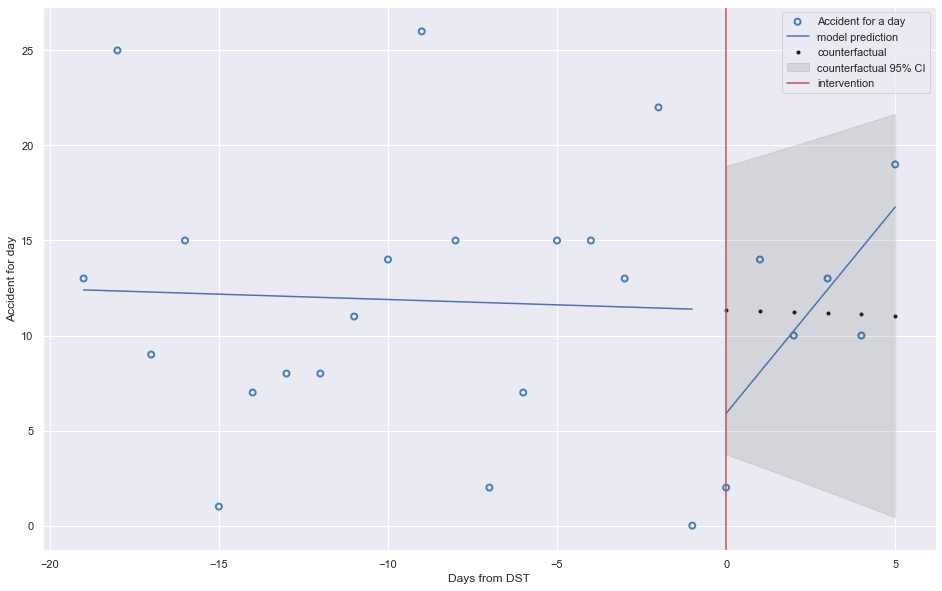

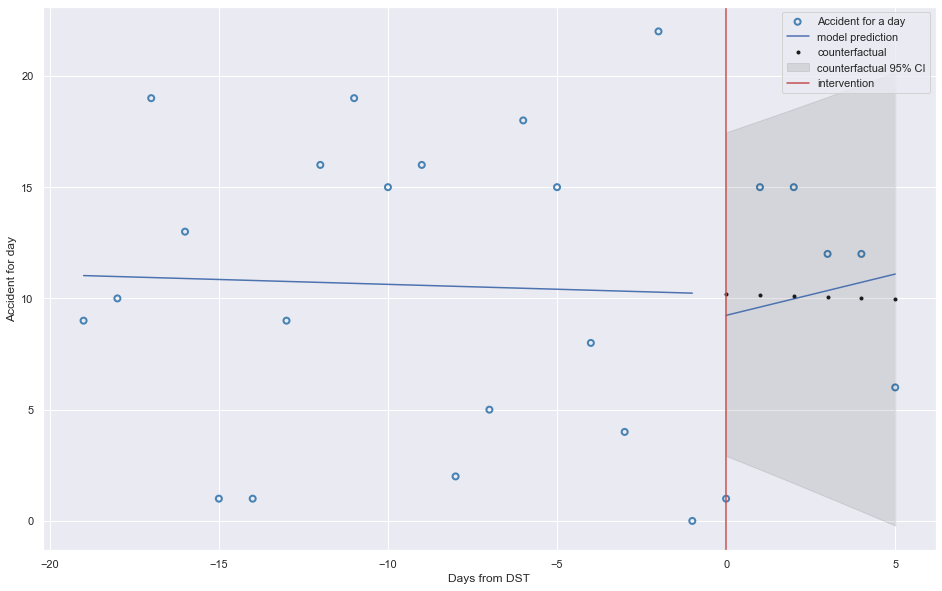

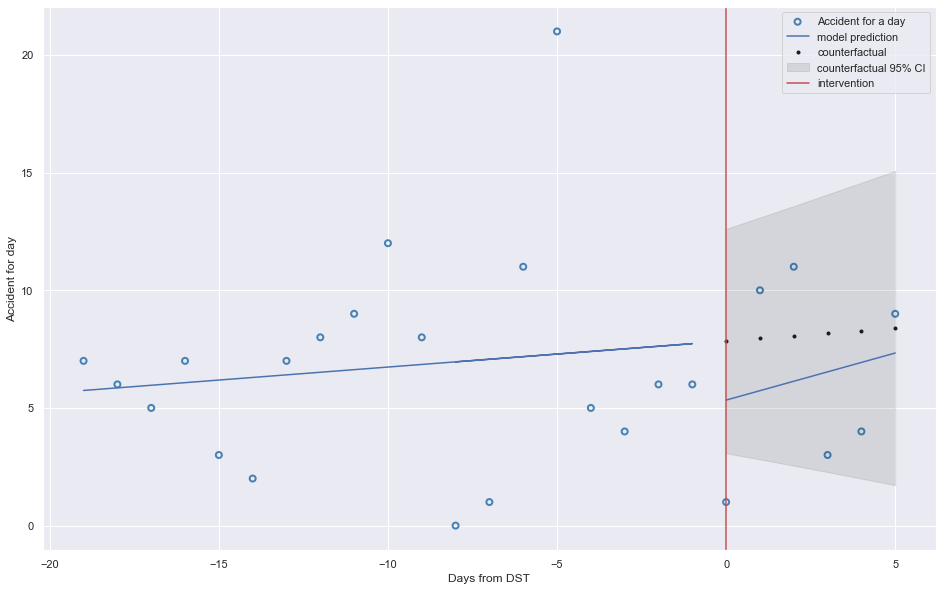

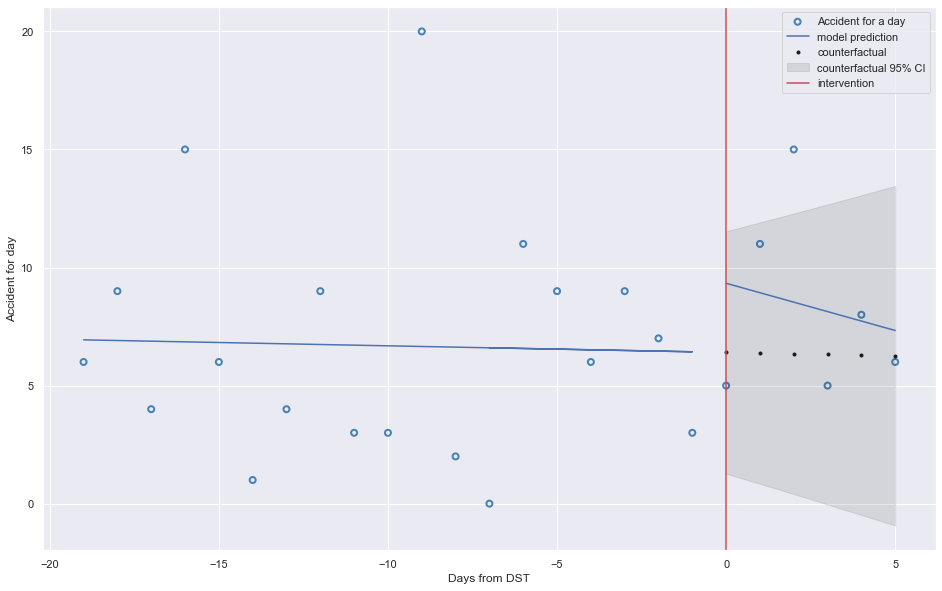

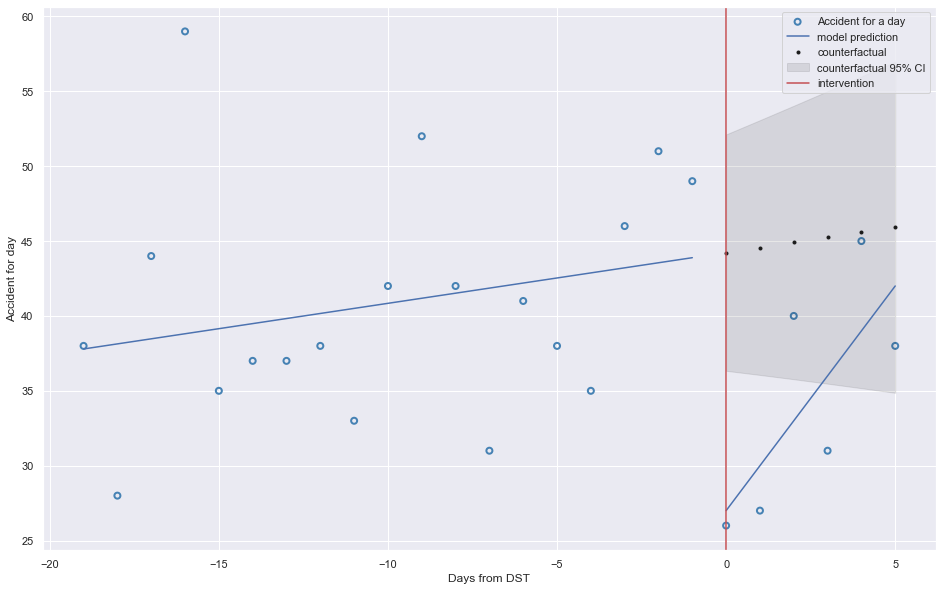

In [23]:
state = 'AZ'
season = 'Summer'
for year in [ 2017,2018,2019,2020,2021]:
    OLS(tt[tt['State'] == state], 20, 5, years=[year], print_res=False,dst = season, plot_OSL_summary=0)

In [95]:
# Summer

AZ = [-8.341455091670346 ,
-4.84104525628976 ,
-2.0961007644860024 ,
2.2875759997111986 ,
-12.192585288454978 ]
NV = [-1.4123437676948694 ,
0.47194263667186304 ,
-0.5208427006387971 ,
-0.5738218663361685 ,
-3.0641843453545103]
CO = [0.39162121741434497 ,
7.09601893991228 ,
6.274216856005845 ,
0.022319862262236256 ,
1.9446826305130331]

NM = [-0.06455119504303819 ,
0.06664986178807485 ,
0.2108426938883392 ,
-7.0674605534758495e-16 ,
-1.9470850183862105]

UT = [-3.4770290444650342 ,
-0.37202680757673967 ,
-11.27931542577101 ,
-6.230471716117762 ,
0.8858423437541987 ]

OLSC_data_lists = [UT, NM, CO, AZ, NV]
OLSC_names = ['UT', 'NM', 'CO', 'AZ', 'NV']

for dt in OLSC_data_lists:
    print(OLSC_names[OLSC_data_lists.index(dt)])
    data = (dt,)
    #calculate 95% bootstrapped confidence interval for median
    bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,
                             random_state=1, method='percentile')

    #view 95% boostrapped confidence interval
    print(bootstrap_ci.confidence_interval)

UT
ConfidenceInterval(low=-8.088088960201507, high=-0.4898795944220232)
NM
ConfidenceInterval(low=-1.1678312776827189, high=0.1243269946281806)
CO
ConfidenceInterval(low=0.5545129579732391, high=5.737030844469857)
AZ
ConfidenceInterval(low=-9.254198463350525, high=-0.7149655714045504)
NV
ConfidenceInterval(low=-2.0680393537471735, high=-0.10347171166361549)


In [92]:
# Winter
AZ=[5.8270616920515845 ,
0.1513566955726194 ,
5.662476457781743 ,
0.2053224644563354 ,
-18.347078978091034 ,
-30.416889931699657 ]
NV = [-0.7386865392352693 ,
-0.014075070299715628 ,
0.38255760136958883 ,
-0.30903076364210946 ,
-0.2102417312292575 ,
0.31529320322851273 ]
CO = [6.243027646193116 ,
4.6959288551271365 ,
-11.718262238593802 ,
7.480245415778521 ,
-3.390363597125438 ,
0.7766292821179022 ]
NM =[0.8426184602909379 ,
-0.10528105490002003 ,
0.03938852869318288 ,
-0.7657657657657635 ,
-8.105564886259694 ,
-1.378410624386325 ]
UT = [-5.435925301398613 ,
2.4901431564397756 ,
2.411062910907838 ,
4.40819857488524 ,
-9.579307519738528 ,
6.580294398082152 ]

OLSC_data_lists = [UT, NM, CO, AZ, NV]
OLSC_names = ['UT', 'NM', 'CO', 'AZ', 'NV']

for dt in OLSC_data_lists:
    print(OLSC_names[OLSC_data_lists.index(dt)])
    data = (dt,)
    #calculate 95% bootstrapped confidence interval for median
    bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,
                             random_state=1, method='percentile')

    #view 95% boostrapped confidence interval
    print(bootstrap_ci.confidence_interval)

UT
ConfidenceInterval(low=-4.559097729136853, high=4.46651862795841)
NM
ConfidenceInterval(low=-4.293499634895373, high=0.17293945681594344)
CO
ConfidenceInterval(low=-4.858882100442095, high=5.462634483628446)
AZ
ConfidenceInterval(low=-18.19785064071289, high=3.861861704237628)
NV
ConfidenceInterval(low=-0.4085939239367396, high=0.19523080127787165)


In [79]:
total_cars = sum(number_of_car_by_state.values())
avg_list = []
car_count = []
for state in ['UT', 'NM', 'CO', 'NV', 'AZ']:
    car_count.append(number_of_car_by_state[state])

for state in [UT, NM, CO,  NV , AZ]:
    state_did =  sum(state)/len(state)
    avg_list.append(state_did)

avg_AZ = sum(AZ)/len(AZ)


In [81]:
weighted_did = [a*b for a,b in zip(avg_list,car_count)]
weighted_did = [item / total_cars for item in weighted_did]
weighted_did

[0.3124903810670154,
 0.07317379130927414,
 -0.6554498833053416,
 -0.010235725490799652,
 0.1215537757133282]

In [83]:
DID_hat = sum(weighted_did[:-1])/ len(weighted_did[:-1]) - weighted_did[4]
DID_hat

-0.19155913481829112

In [96]:
total_cars = sum(number_of_car_by_state.values())
avg_list = []
car_count = []
for state in ['UT', 'NM', 'CO', 'NV', 'AZ']:
    car_count.append(number_of_car_by_state[state])

for state in [UT, NM, CO,  NV , AZ]:
    state_did =  sum(state)/len(state)
    avg_list.append(state_did)

avg_AZ = sum(AZ)/len(AZ)
weighted_did = [a*b for a,b in zip(avg_list,car_count)]
weighted_did = [item / total_cars for item in weighted_did]
DID_hat = sum(weighted_did[:-1])/ len(weighted_did[:-1]) - weighted_did[4]
DID_hat

1.8456800571659813

In [76]:
avg_list[:-1]

[2.2858007622515486,
 0.7743878235862591,
 -2.6406408960607637,
 -0.0657796803760539]

AZ
5.8270616920515845 ,
0.1513566955726194 ,
5.662476457781743 ,
0.2053224644563354 ,
-18.347078978091034 ,
-30.416889931699657 ,
NV
-0.7386865392352693 ,
-0.014075070299715628 ,
0.38255760136958883 ,
-0.30903076364210946 ,
-0.2102417312292575 ,
0.31529320322851273 ,
CO
6.243027646193116 ,
4.6959288551271365 ,
-11.718262238593802 ,
7.480245415778521 ,
-3.390363597125438 ,
0.7766292821179022 ,
NM
0.8426184602909379 ,
-0.10528105490002003 ,
0.03938852869318288 ,
-0.7657657657657635 ,
-8.105564886259694 ,
-1.378410624386325 ,
UT
-5.435925301398613 ,
2.4901431564397756 ,
2.411062910907838 ,
4.40819857488524 ,
-9.579307519738528 ,
6.580294398082152 ,


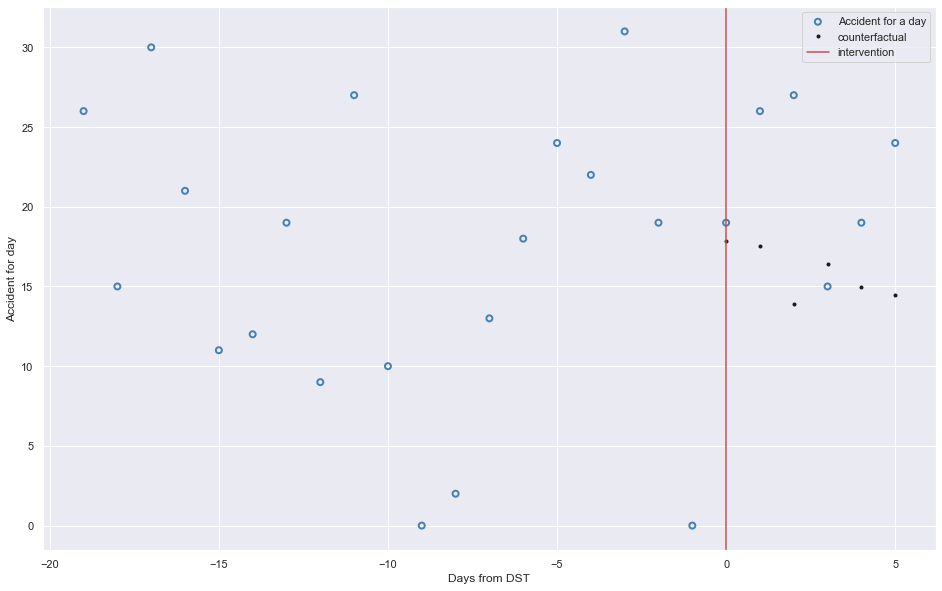

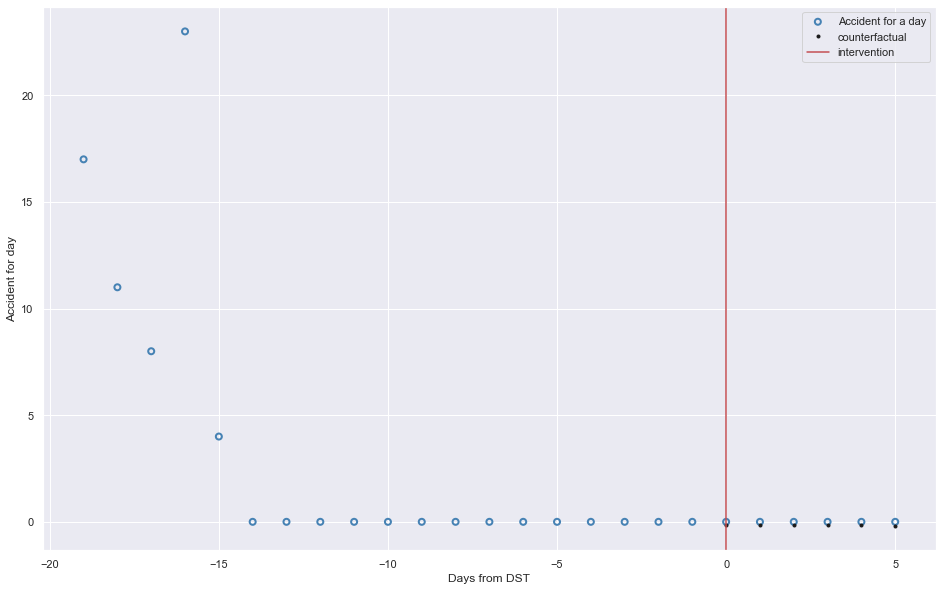

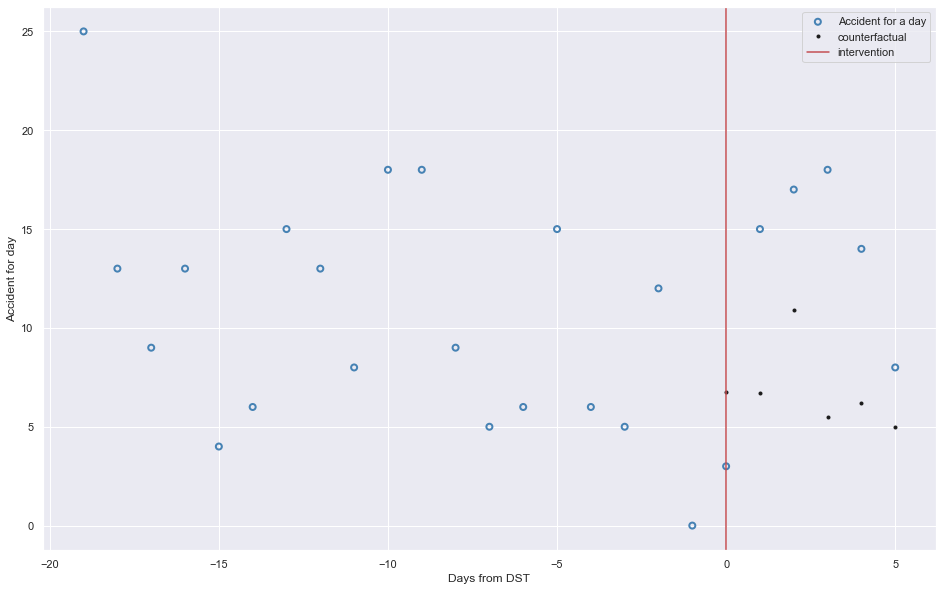

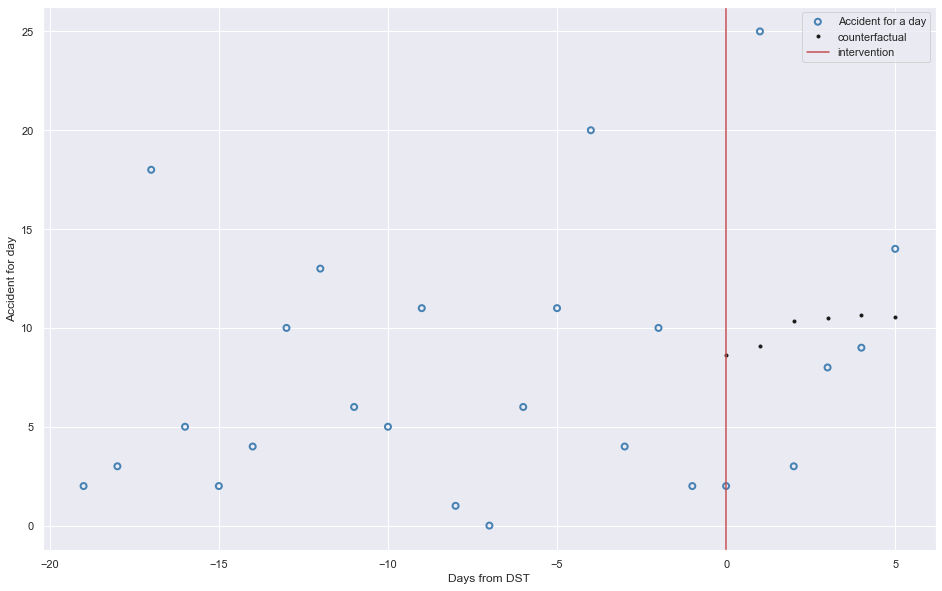

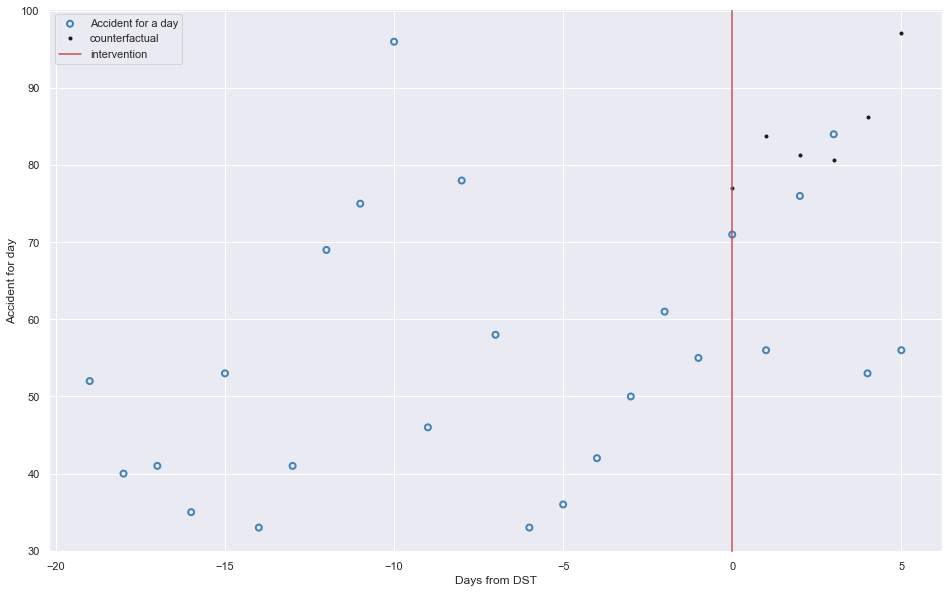

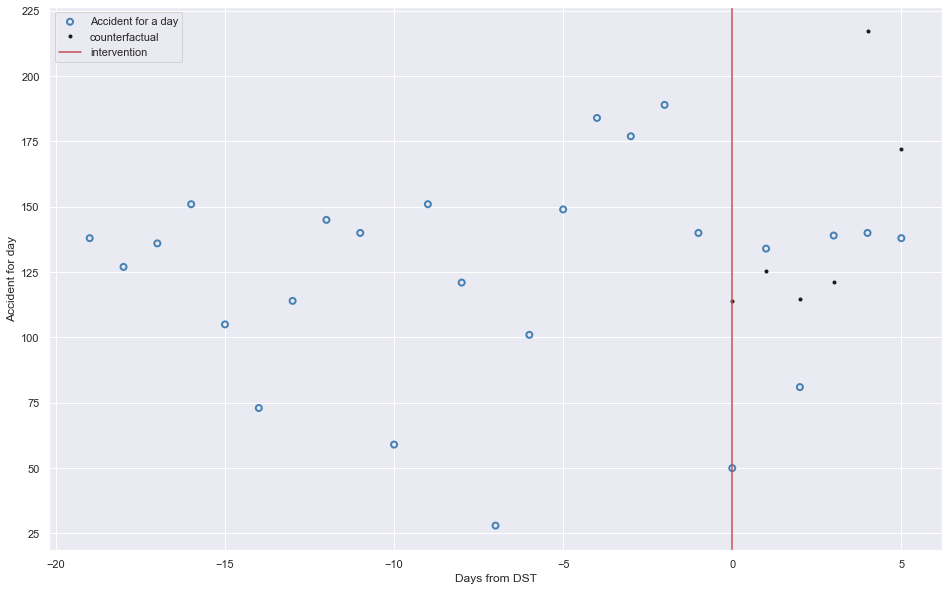

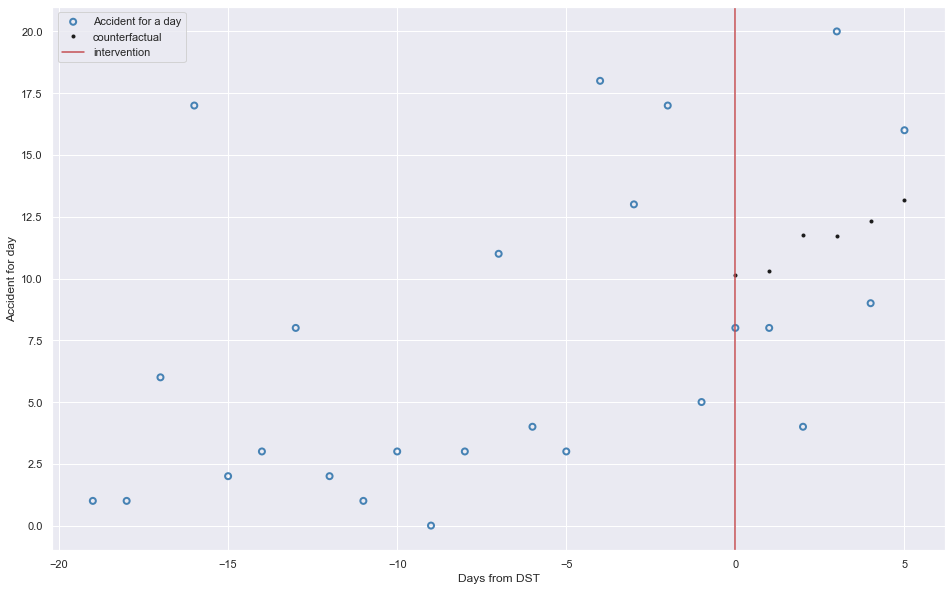

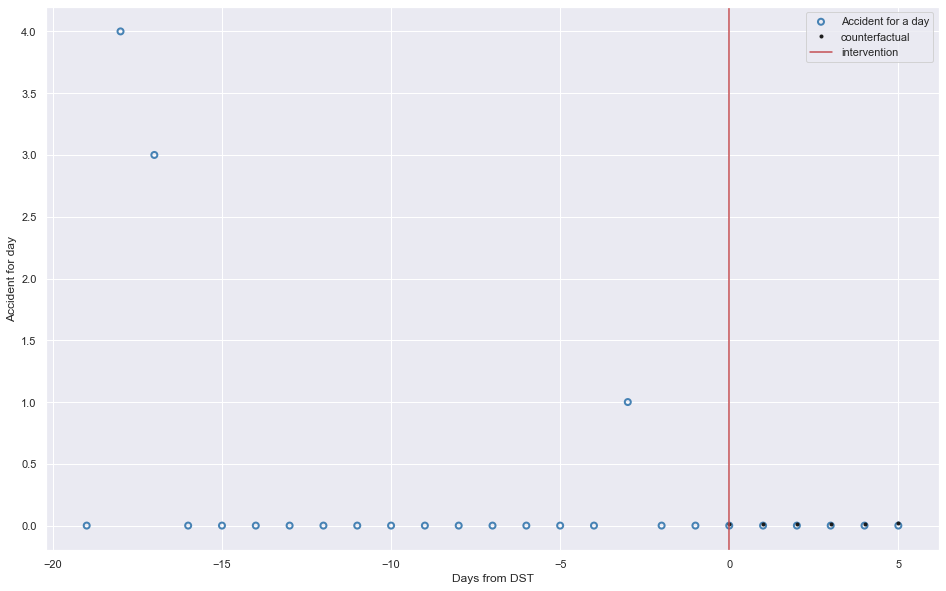

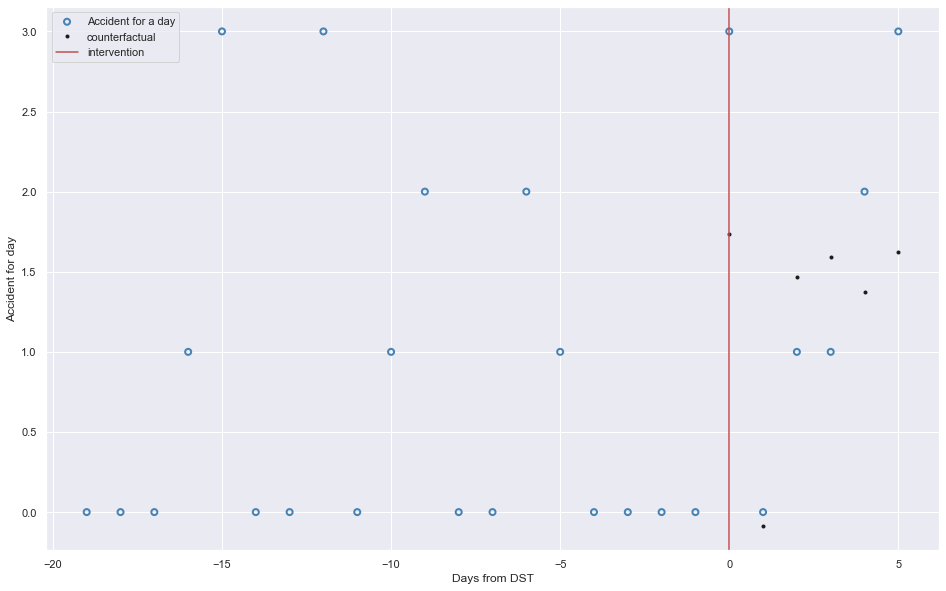

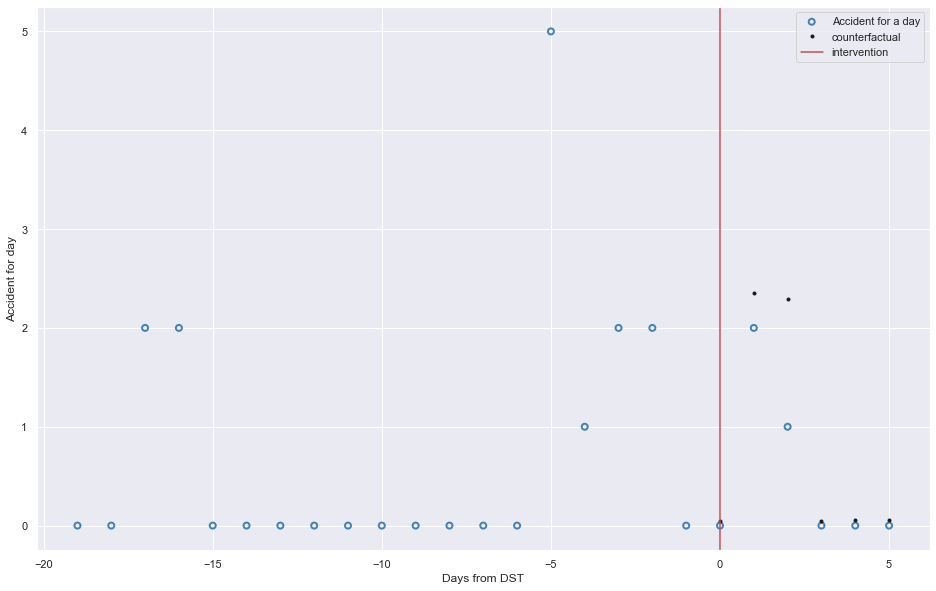

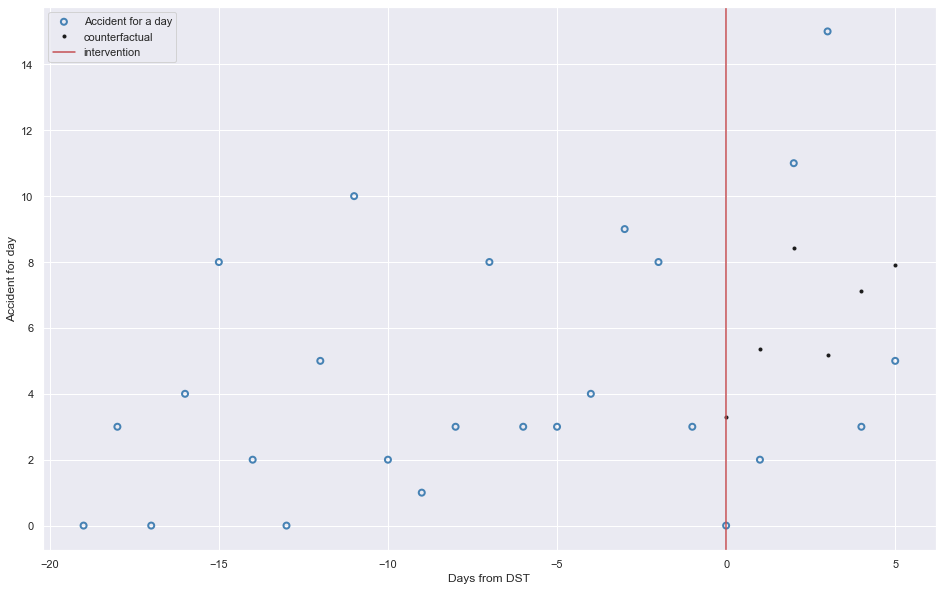

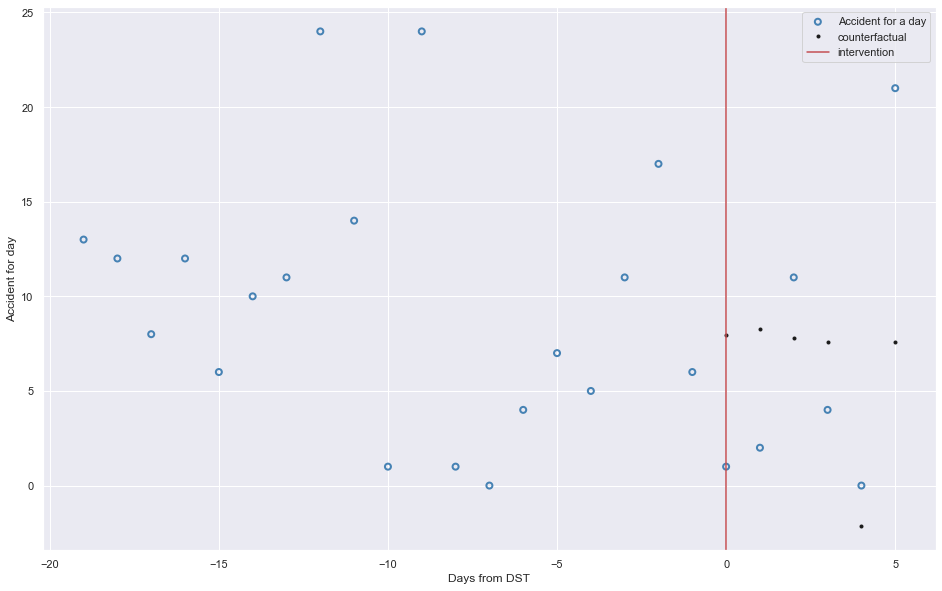

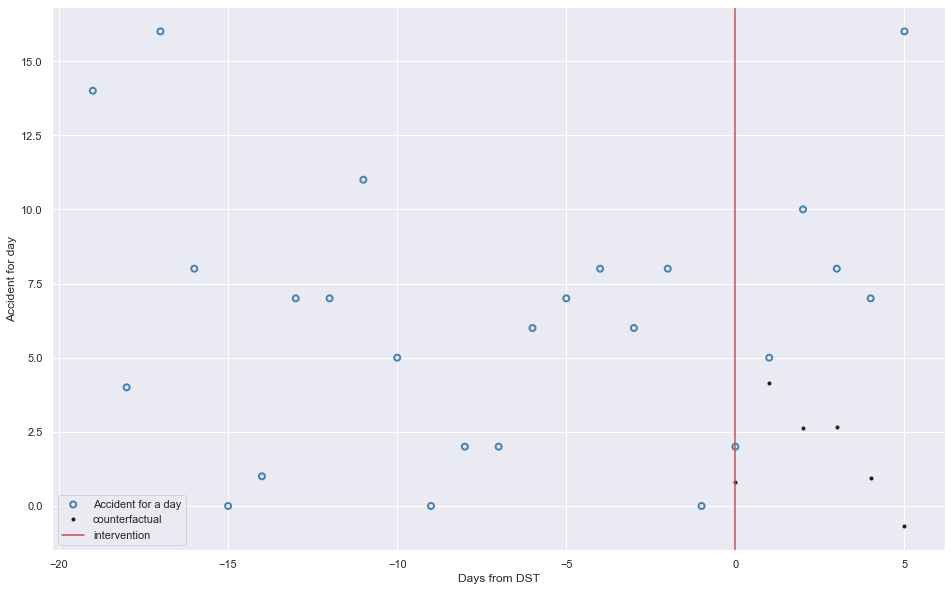

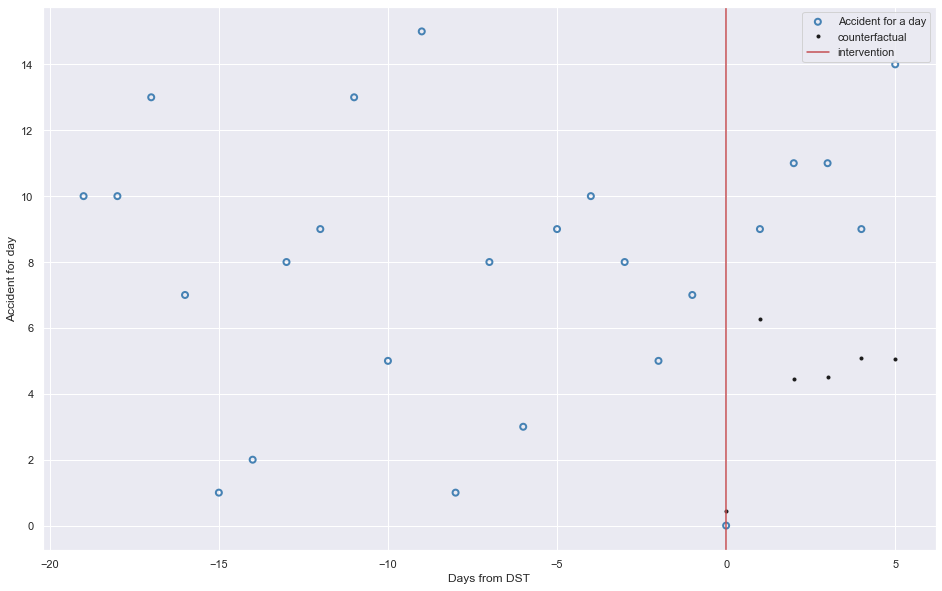

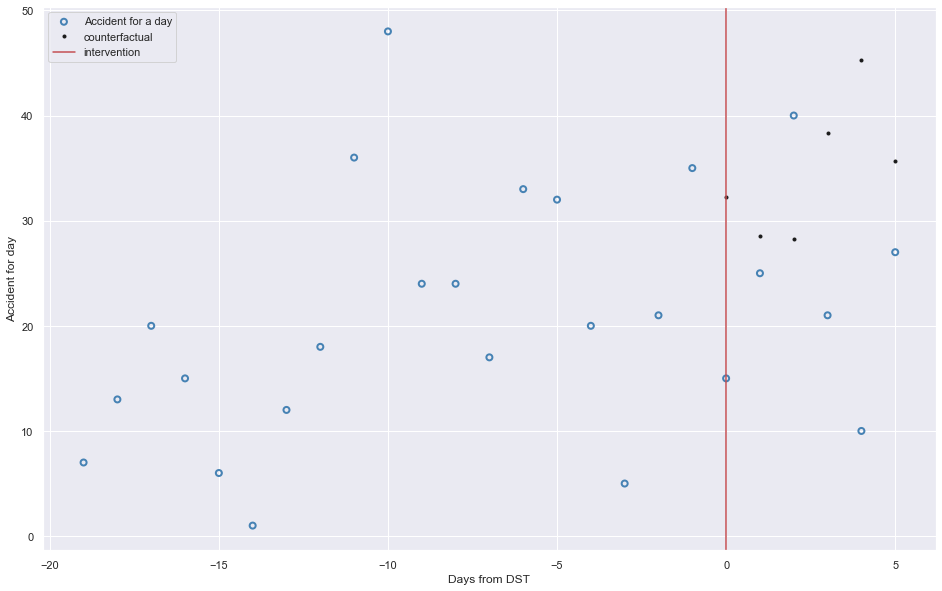

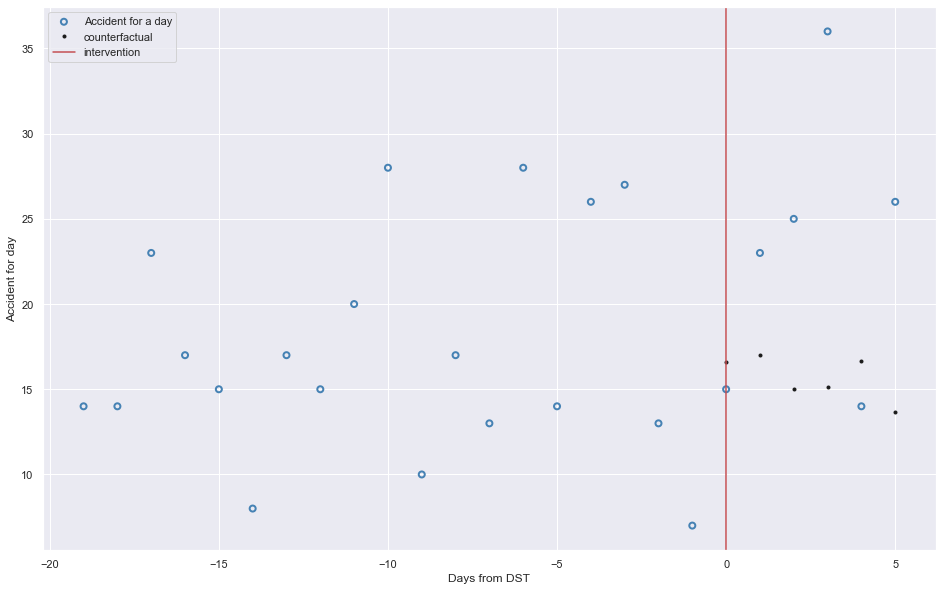

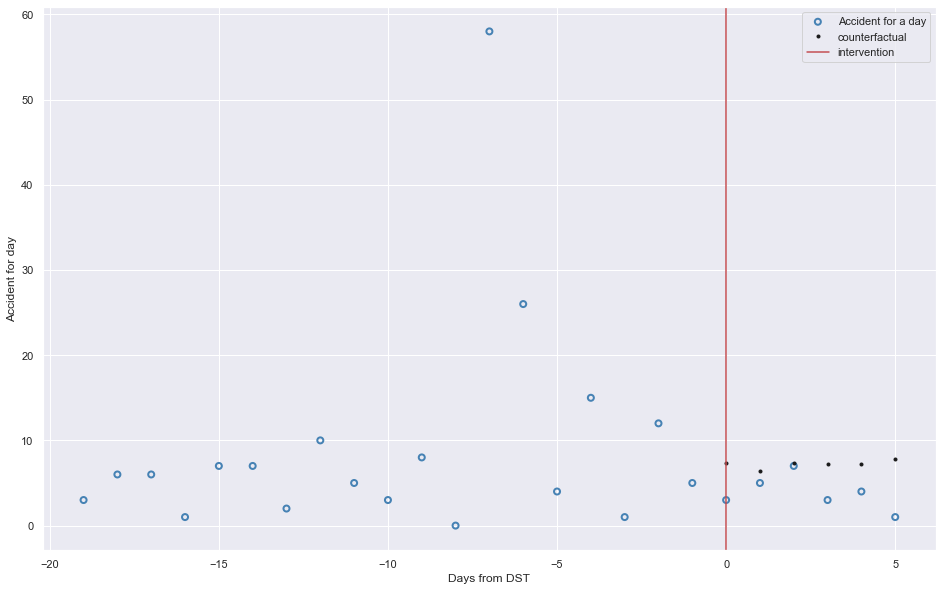

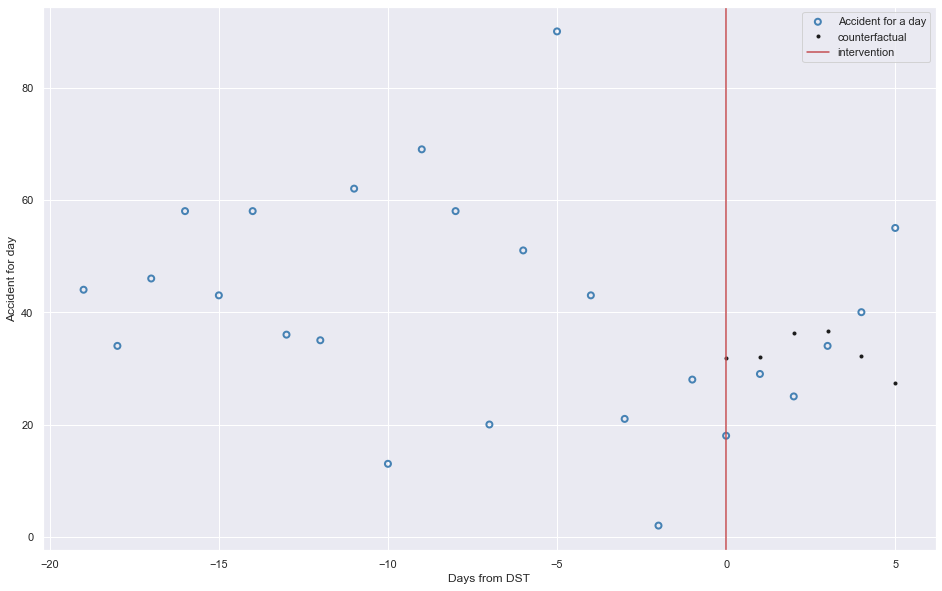

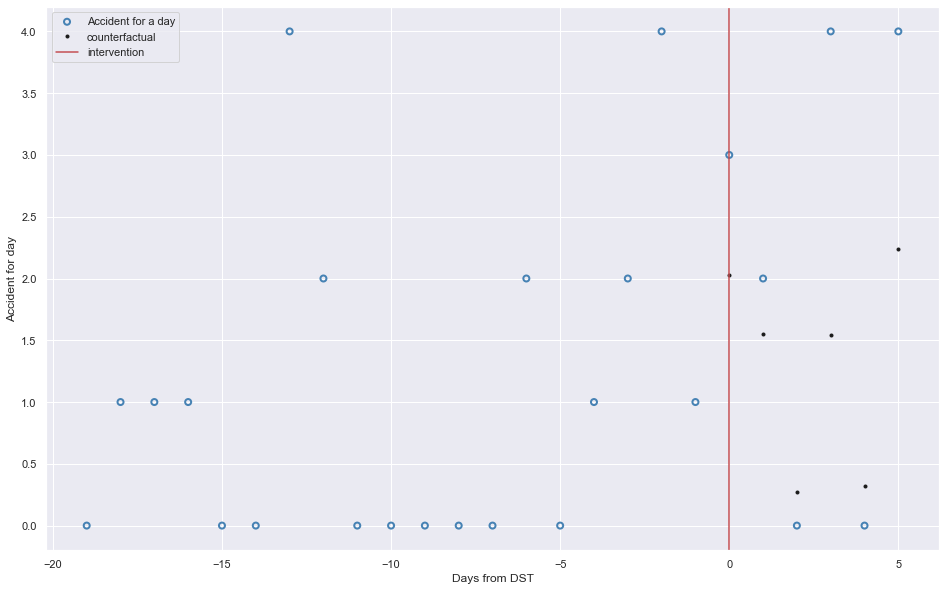

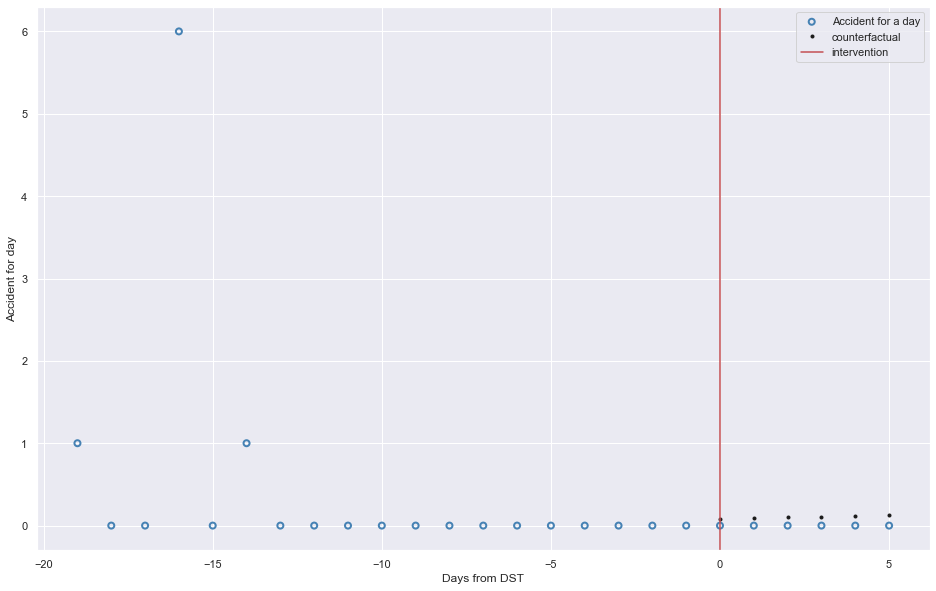

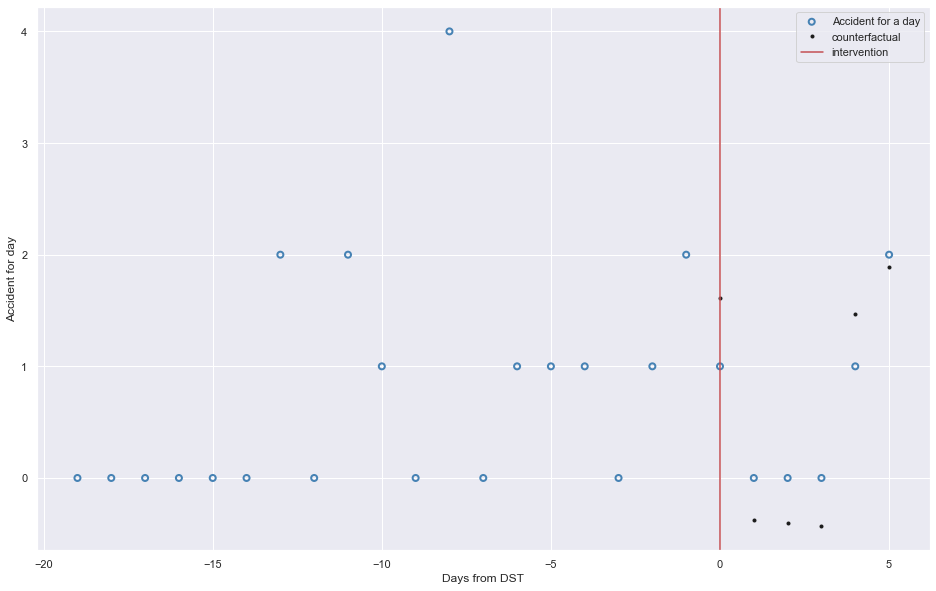

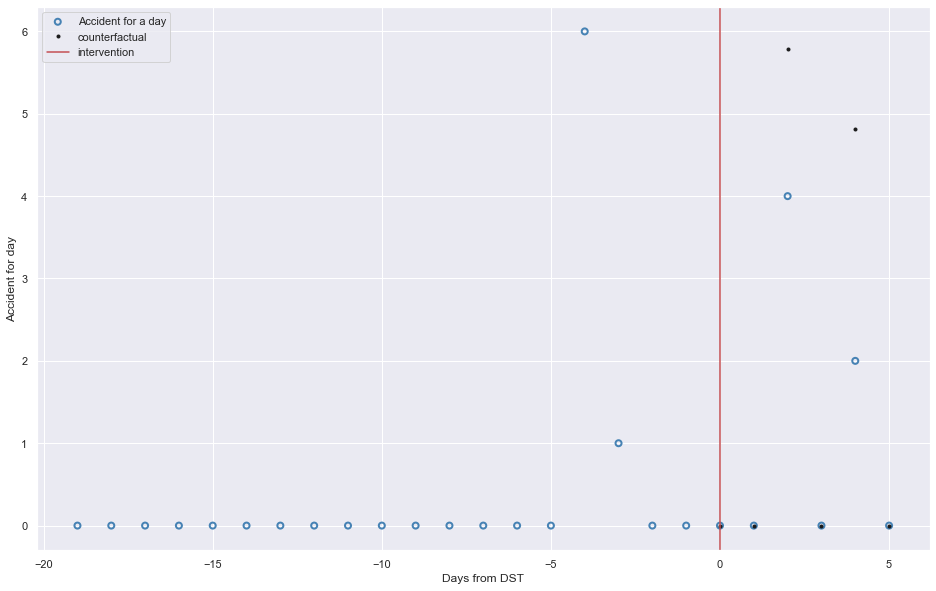

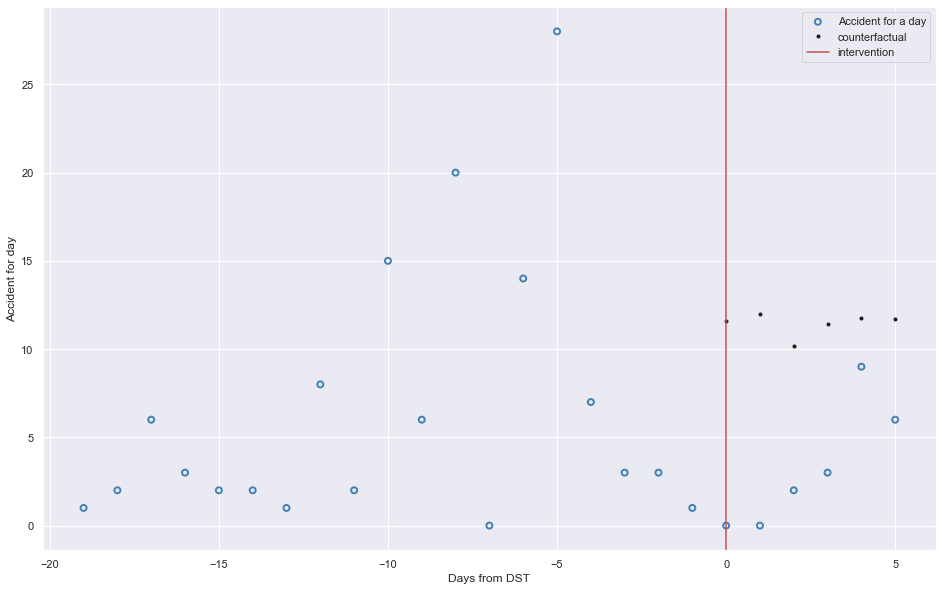

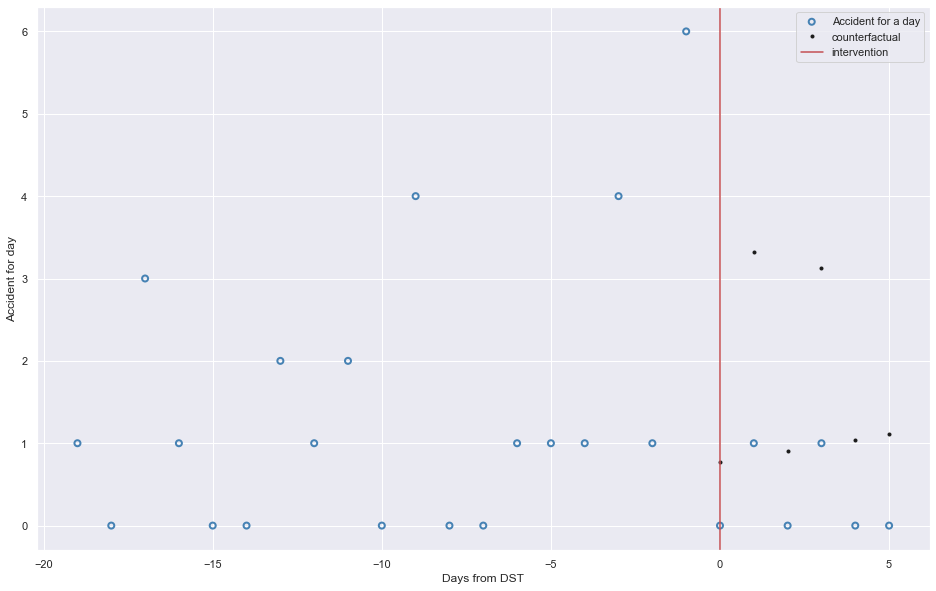

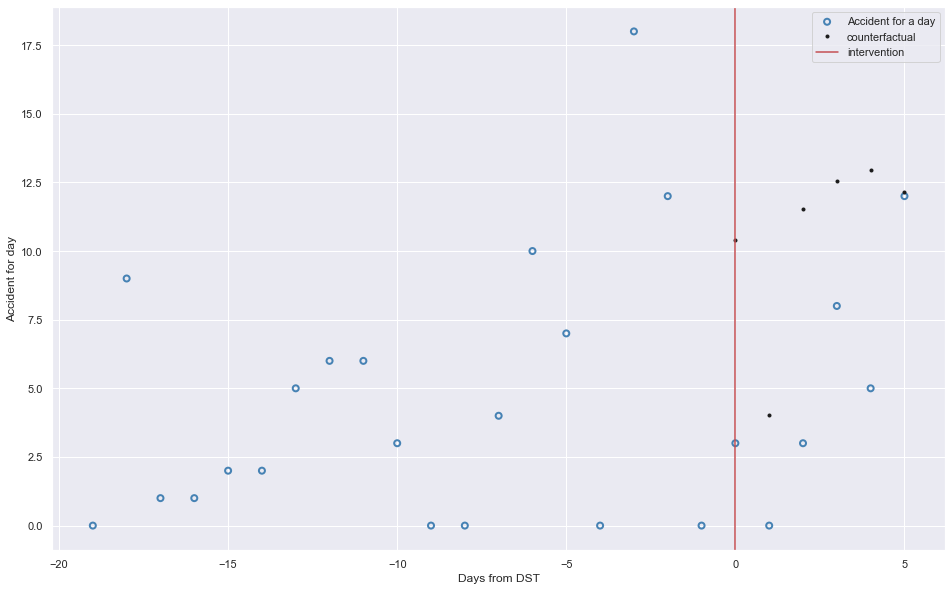

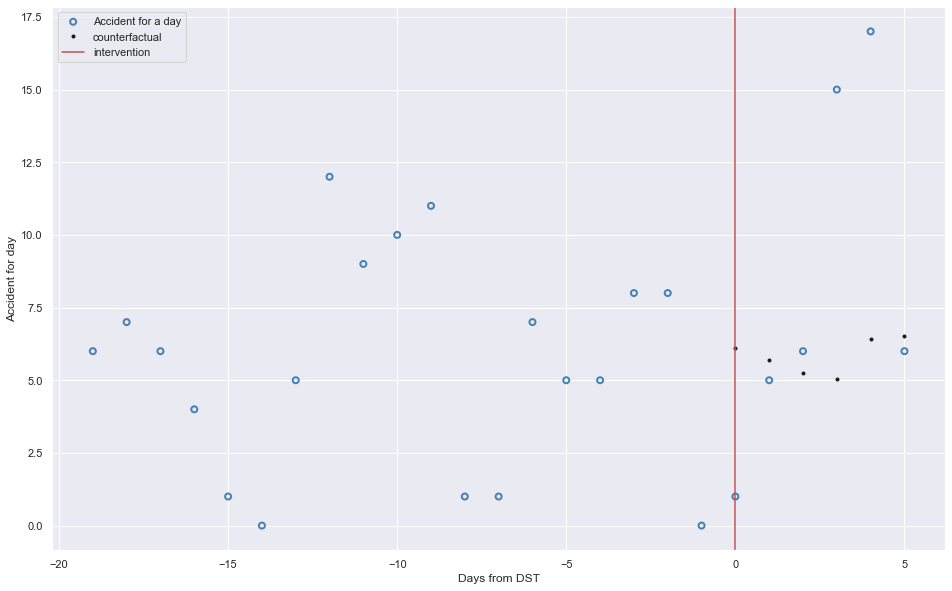

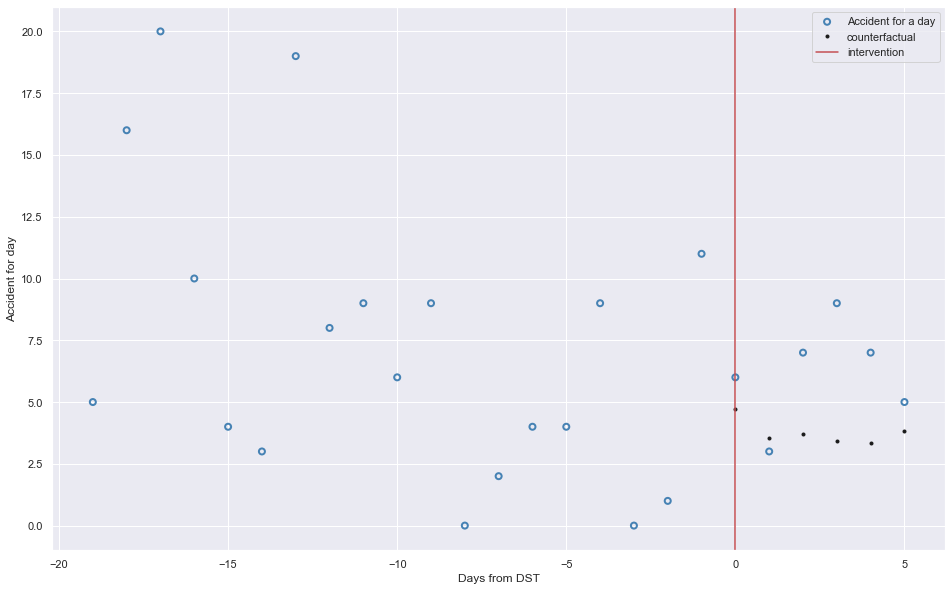

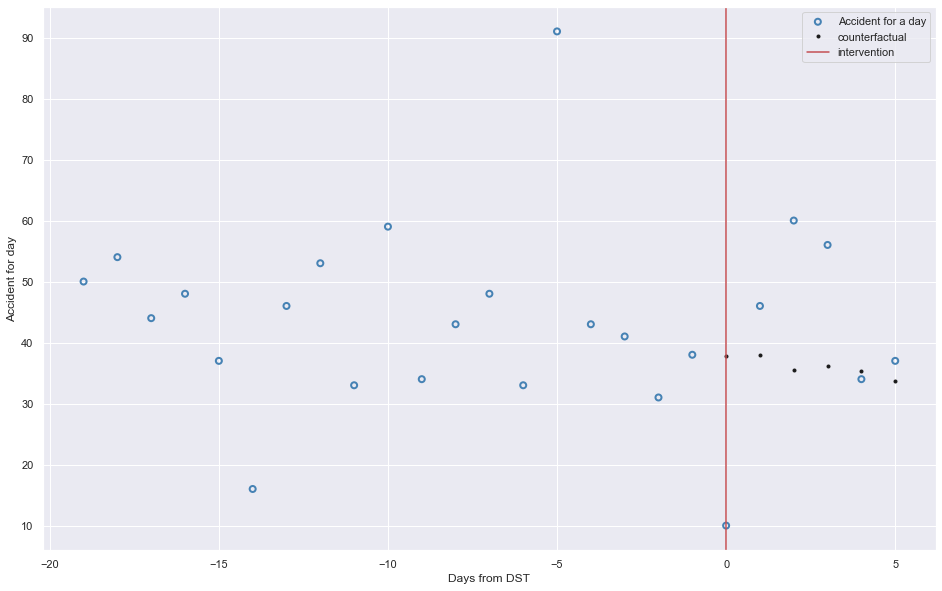

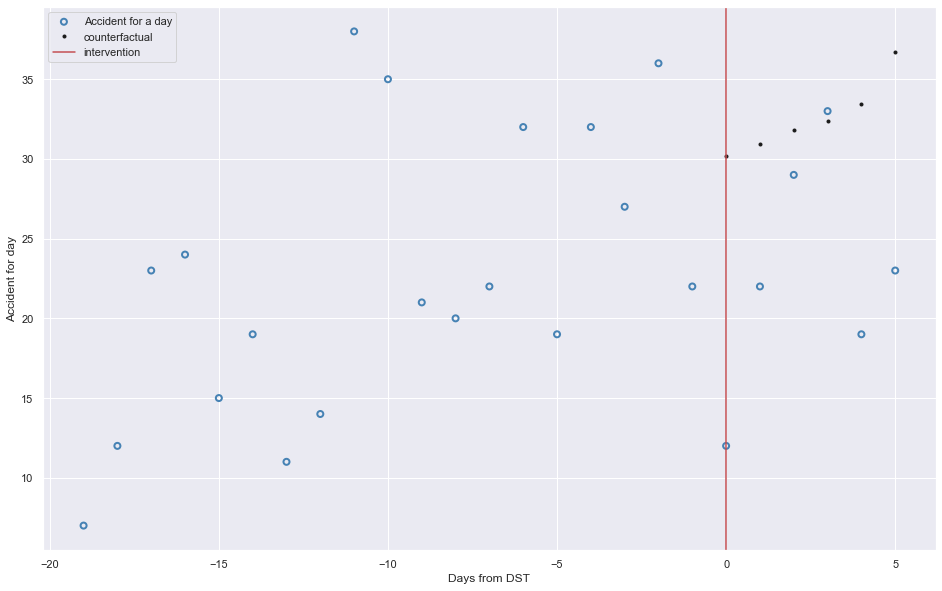

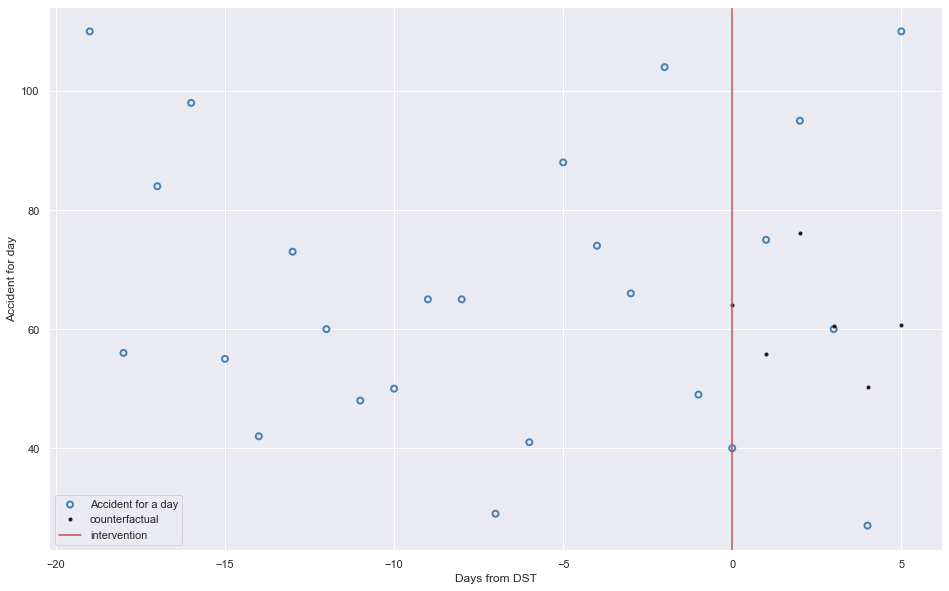

In [45]:
for state in ['AZ', 'NV', 'CO', 'NM' , 'UT']:
    season = 'Winter'
    print(state)
    for year in [2016, 2017,2018,2019,2020,2021]:
        OLSC(tt[tt['State'] == state], 20, 5, years=[year], print_res=False,dst = season, plot_OSL_summary=0)

In [90]:
AZ= [8.642368202460032,
3.5158791057516883,
11.829017098913193,
1.4359130930271355,
8.068234269132688,
-31.493134975313424]
NV = [-0.5380576964149739,
-0.05187249400462813,
1.3293152898475205,
0.15503119521192094,
-0.26603578316035215,
-1.0230585937358105]
CO = [
5.398026024651182,
2.859837751122954,
-11.365004998848072,
3.188314580538016,
-13.0344488809556,
-2.890569852873064]
NM = [1.3472516944797874,
0.6915437723517935,
0.3279025053424557,
2.931469088435728,
0.985789711013525,
-1.6376298301057346]
UT = [4.041806131936801,
5.329372377282793,
4.715192824407508,
-3.825091913743563,
-10.224390181040306,
13.67791533466606]


arima_data_lists = [UT, NM, CO, AZ, NV]
arima_names = ['UT', 'NM', 'CO', 'AZ', 'NV']

for dt in arima_data_lists:
    print(arima_names[arima_data_lists.index(dt)])
    data = (dt,)
    #calculate 95% bootstrapped confidence interval for median
    bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,
                             random_state=1, method='percentile')

    #view 95% boostrapped confidence interval
    print(bootstrap_ci.confidence_interval)


UT
ConfidenceInterval(low=-3.7507420941812755, high=7.89762565551955)
NM
ConfidenceInterval(low=-0.3753242632469059, high=1.8150804952207238)
CO
ConfidenceInterval(low=-8.416513957244165, high=2.856991518104715)
AZ
ConfidenceInterval(low=-12.949765938041375, high=8.938927810226572)
NV
ConfidenceInterval(low=-0.6088533069221274, high=0.5673336348695381)


In [91]:
total_cars = sum(number_of_car_by_state.values())
avg_list = []
car_count = []
for state in ['UT', 'NM', 'CO', 'NV', 'AZ']:
    car_count.append(number_of_car_by_state[state])

for state in [UT, NM, CO,  NV , AZ]:
    state_did =  sum(state)/len(state)
    avg_list.append(state_did)

avg_AZ = sum(AZ)/len(AZ)
weighted_did = [a*b for a,b in zip(avg_list,car_count)]
weighted_did = [item / total_cars for item in weighted_did]
DID_hat = sum(weighted_did[:-1])/ len(weighted_did[:-1]) - weighted_did[4]
DID_hat

-0.19155913481829112

AZ
8.642368202460032
3.5158791057516883
11.829017098913193
1.4359130930271355
8.068234269132688
-31.493134975313424
NV
-0.5380576964149739
-0.05187249400462813
1.3293152898475205
0.15503119521192094
-0.26603578316035215
-1.0230585937358105
CO
5.398026024651182
2.859837751122954
-11.365004998848072
3.188314580538016
-13.0344488809556
-2.890569852873064
NM
1.3472516944797874
0.6915437723517935
0.3279025053424557
2.931469088435728
0.985789711013525
-1.6376298301057346
UT
4.041806131936801
5.329372377282793
4.715192824407508
-3.825091913743563
-10.224390181040306
13.67791533466606


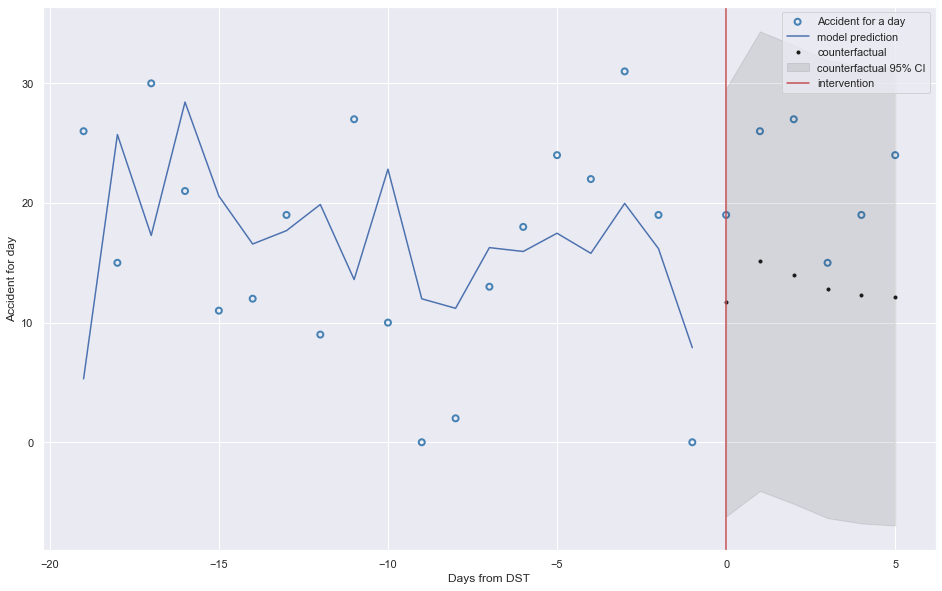

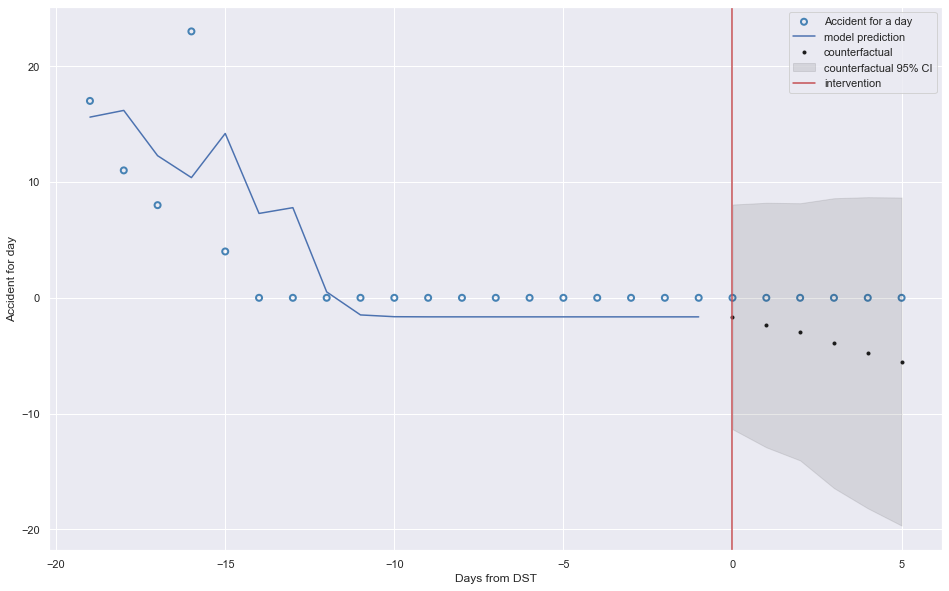

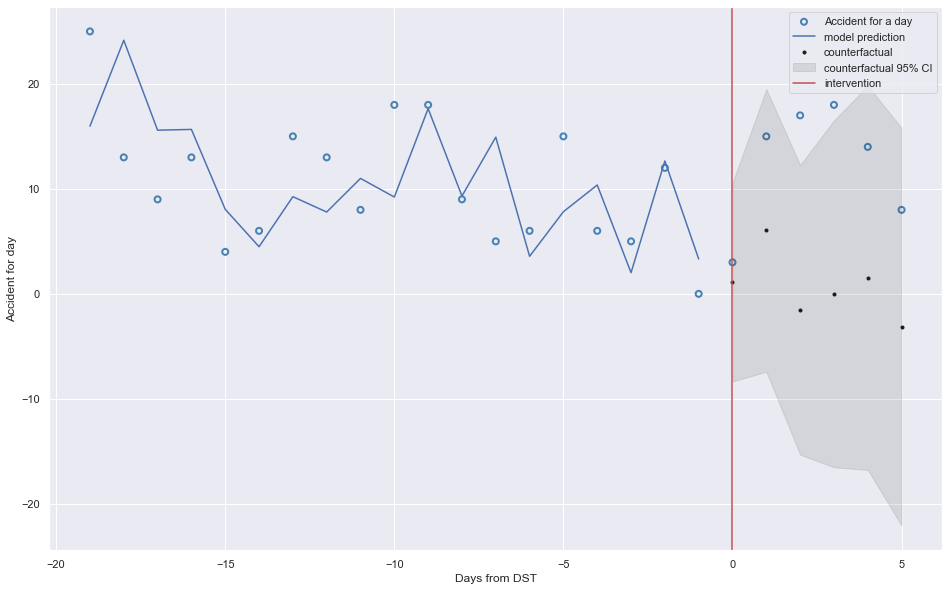

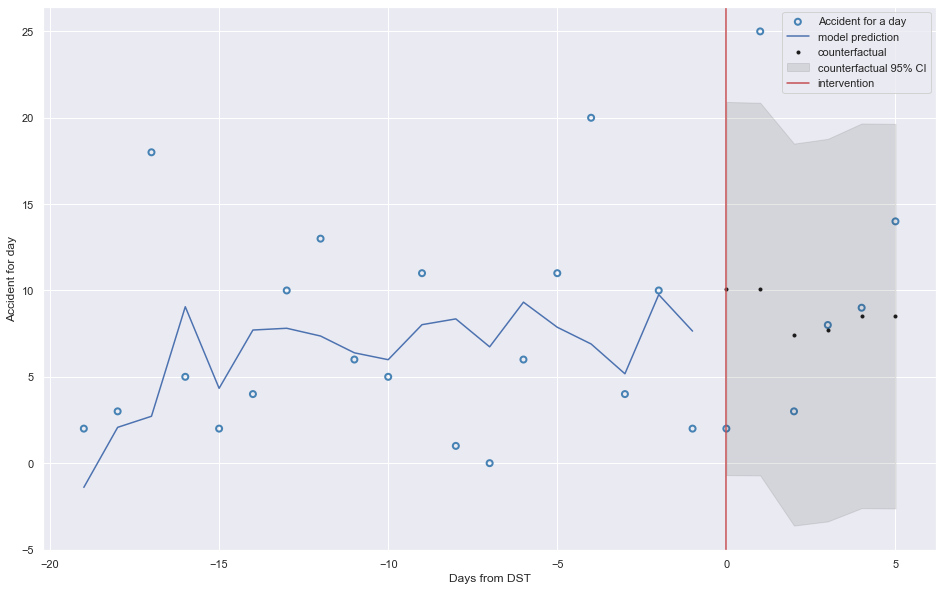

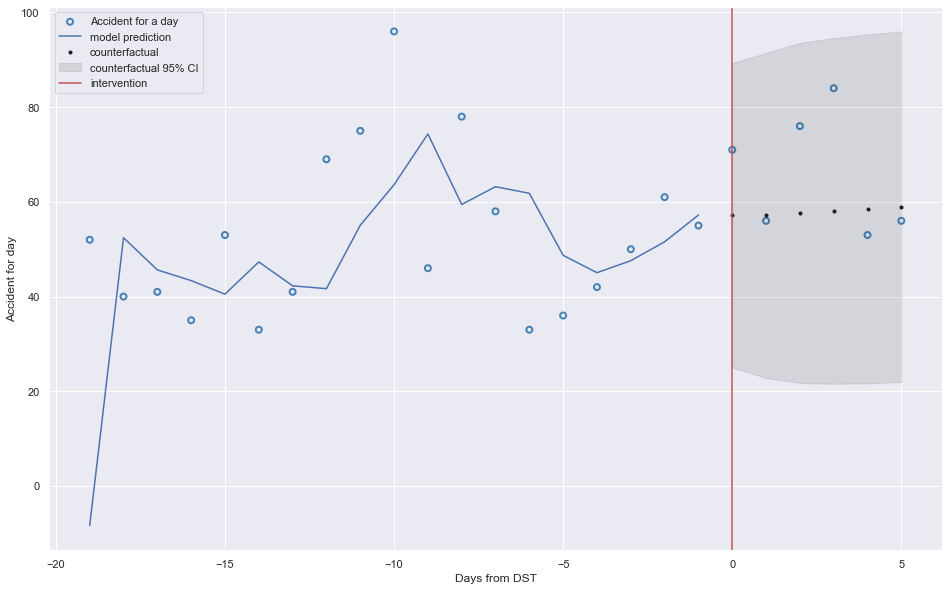

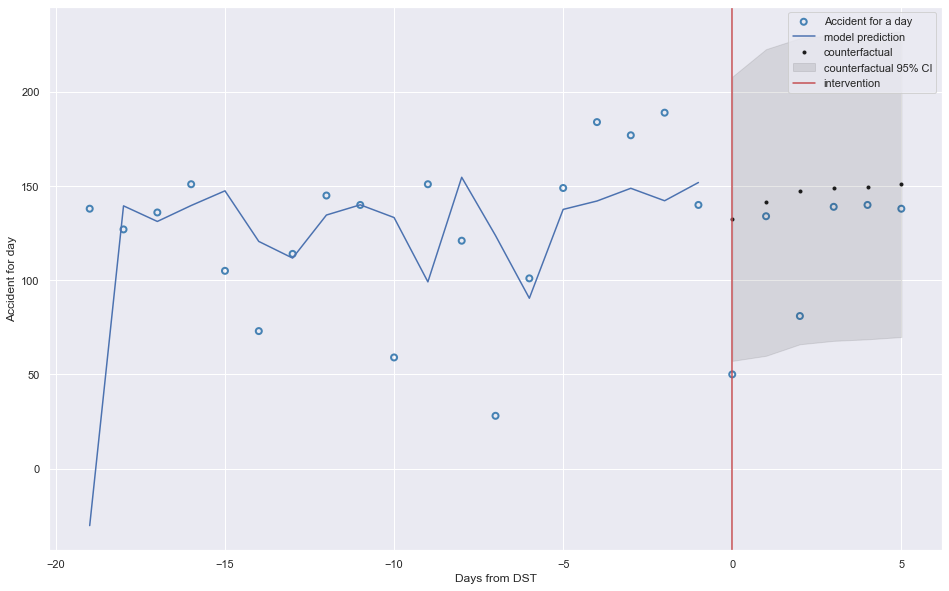

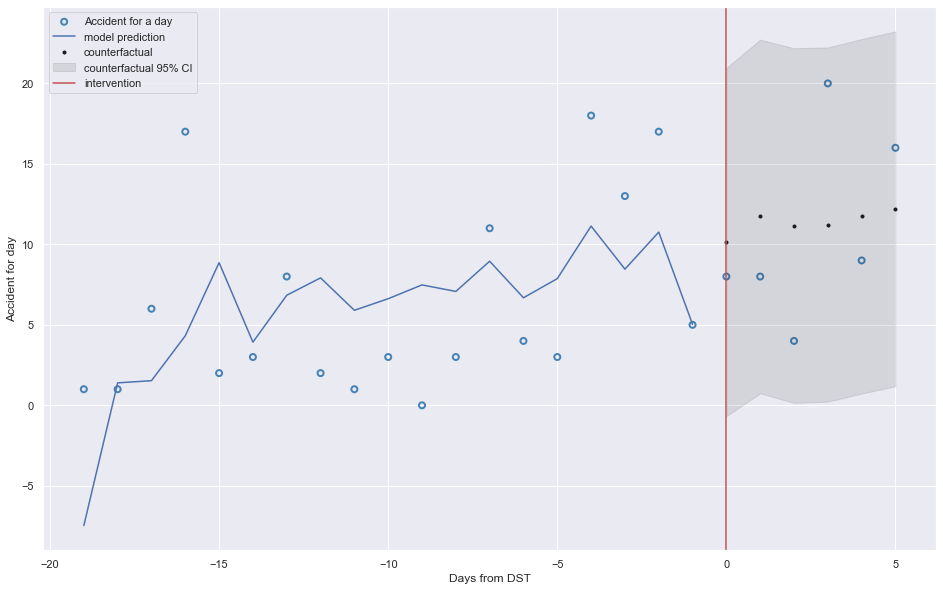

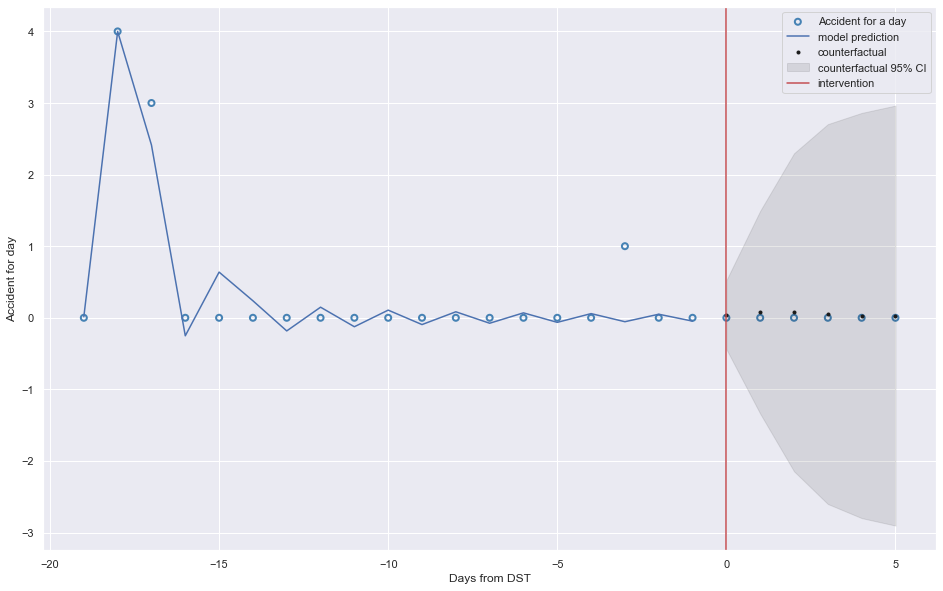

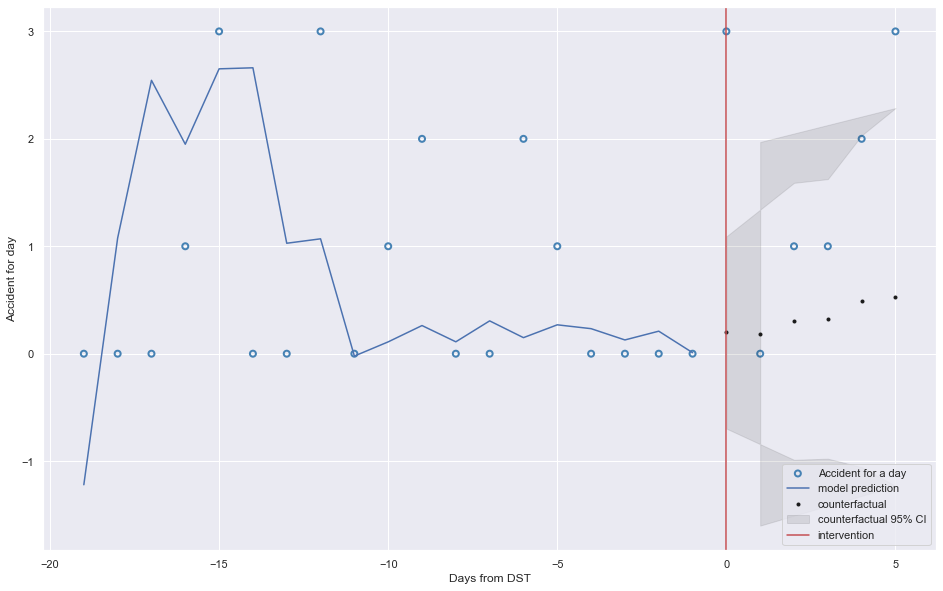

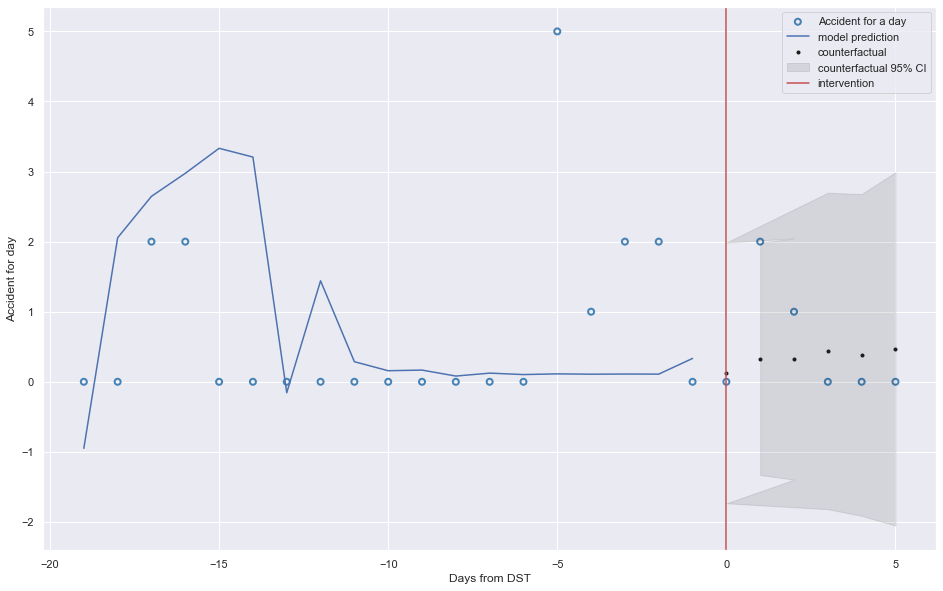

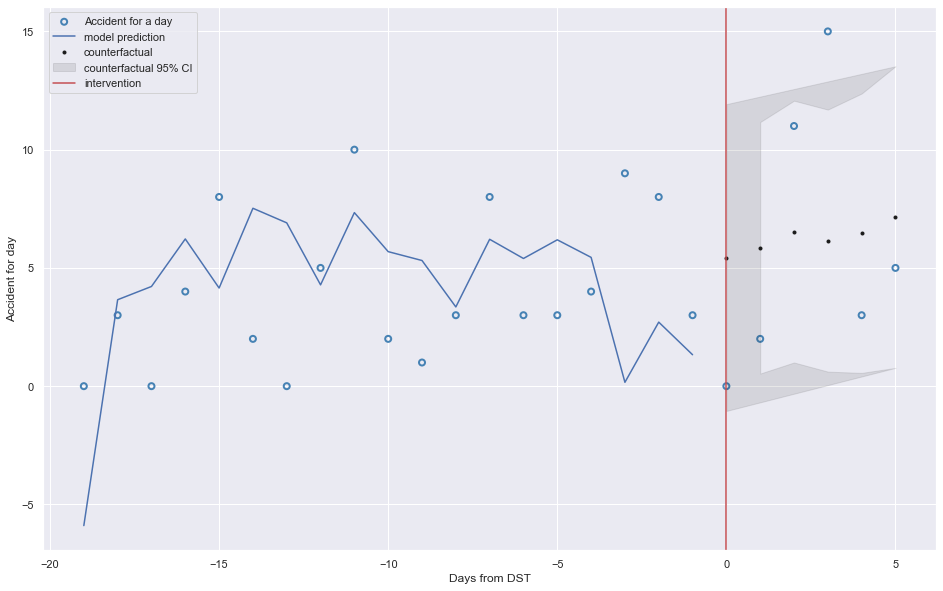

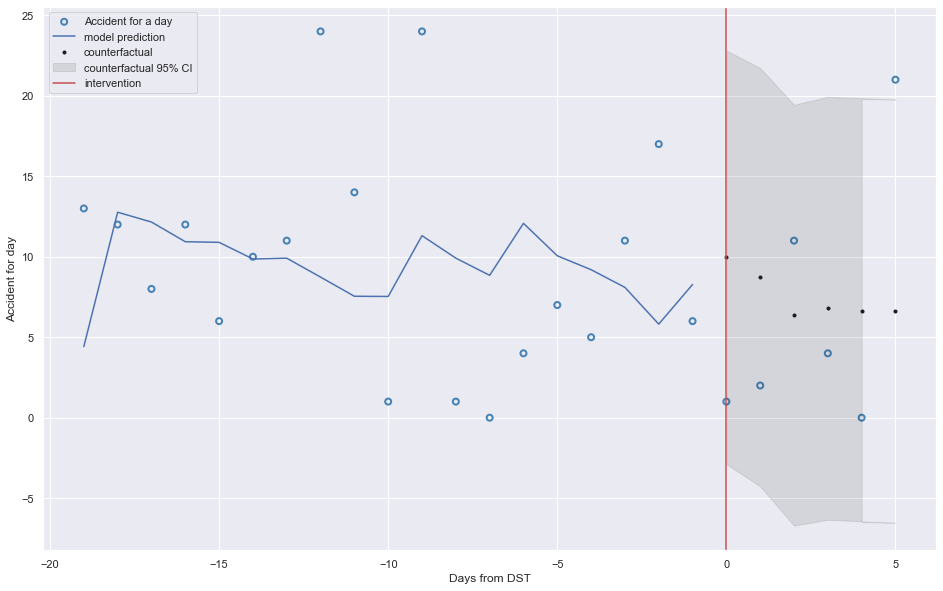

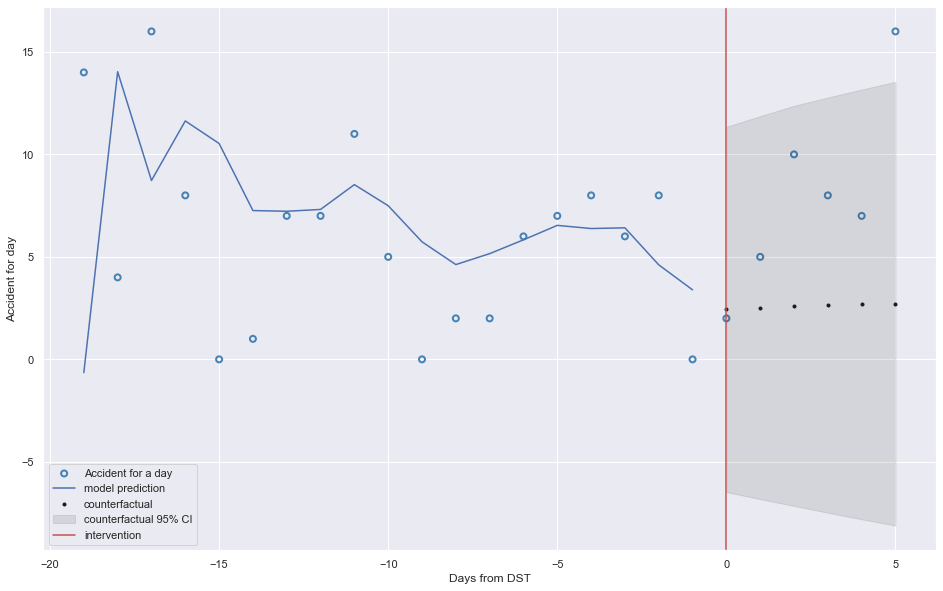

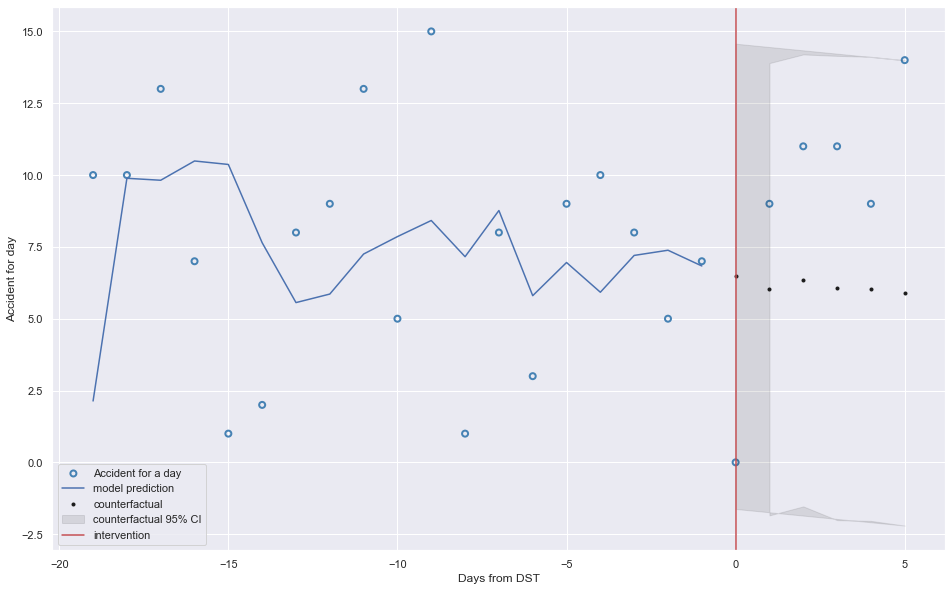

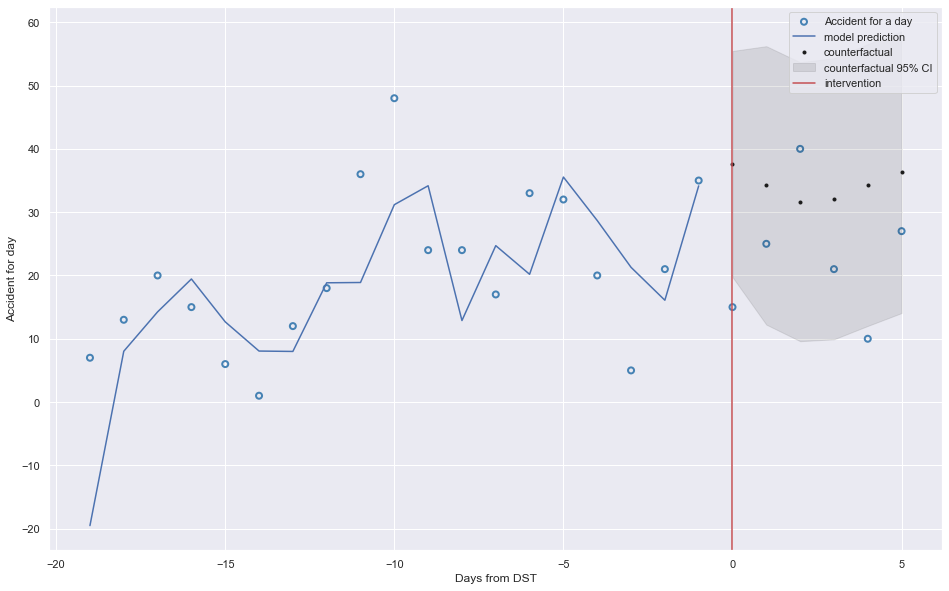

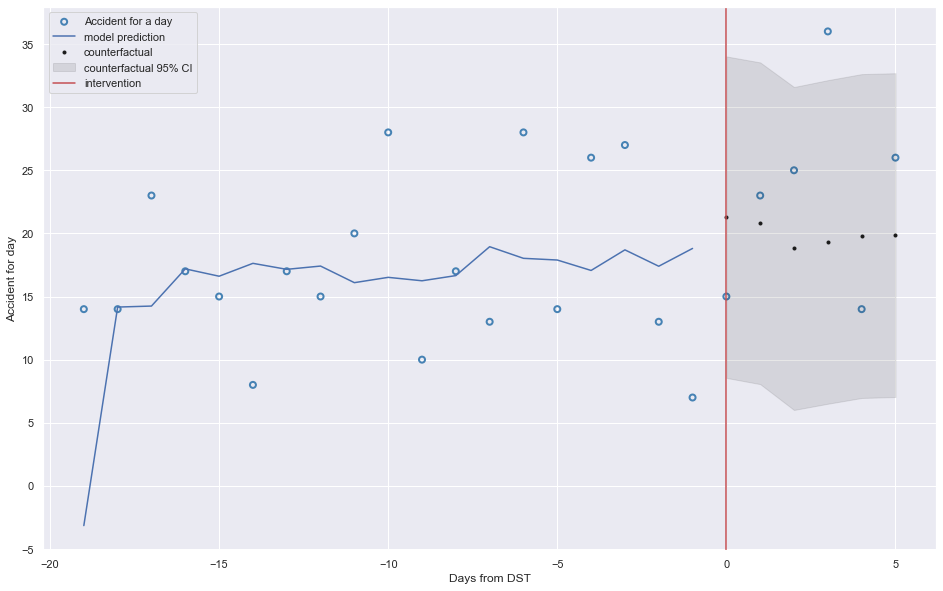

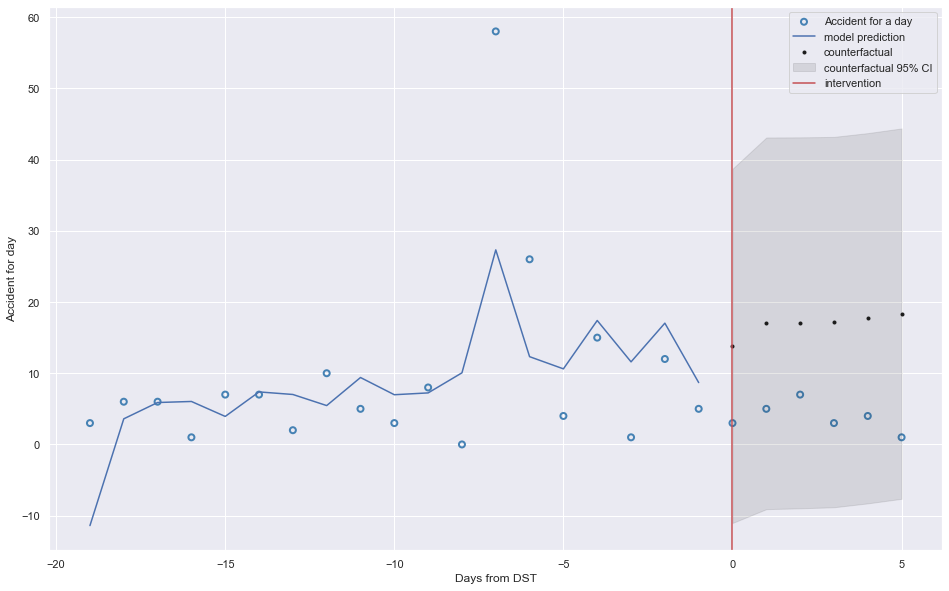

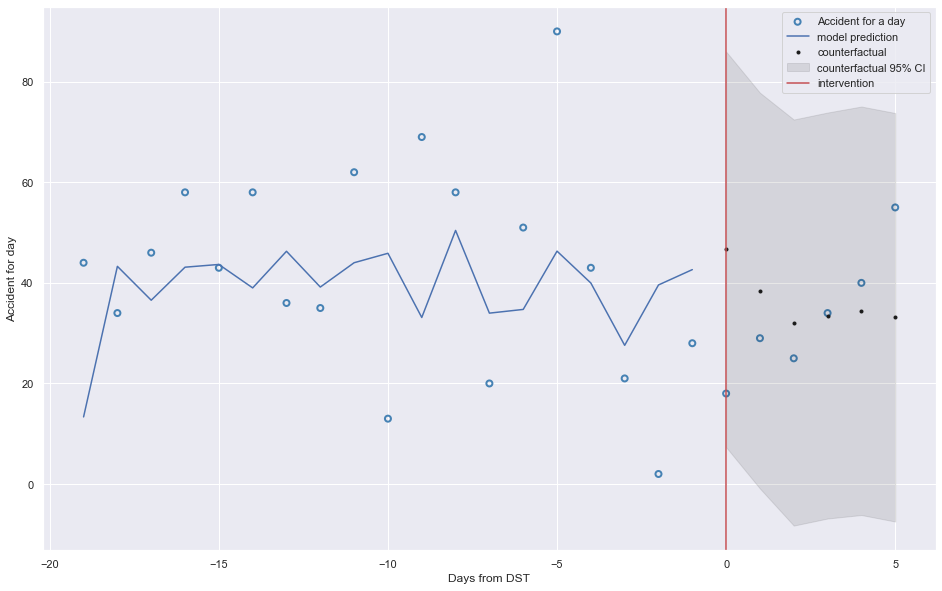

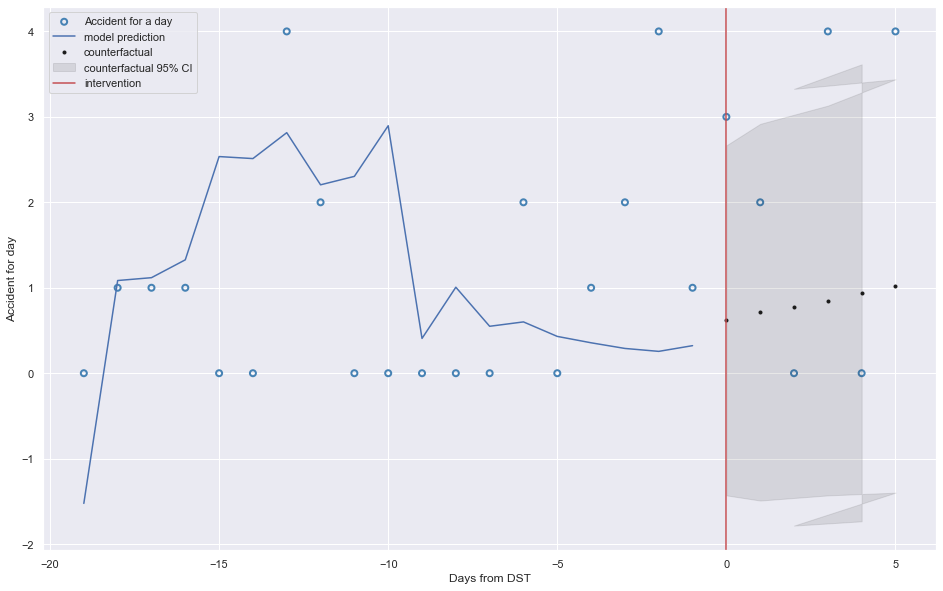

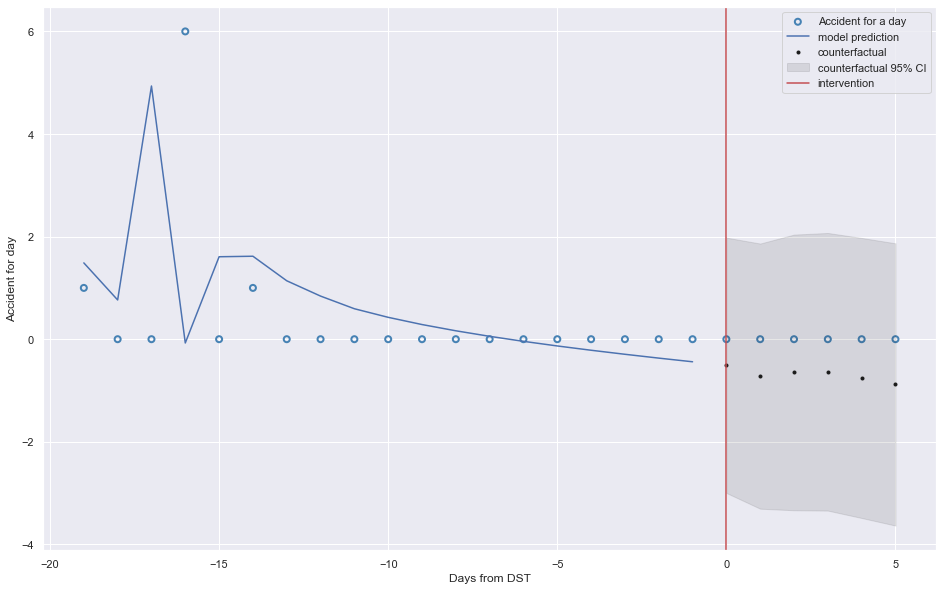

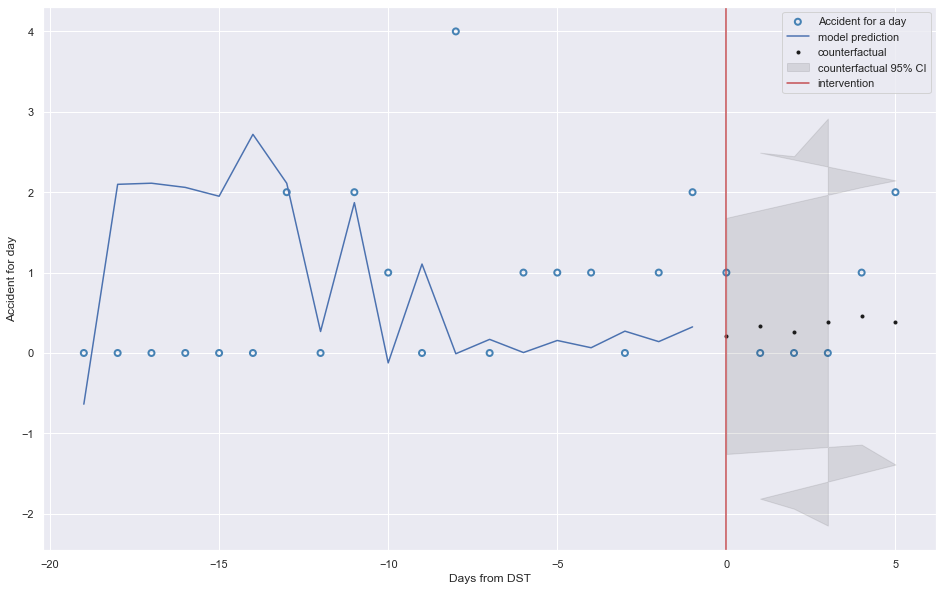

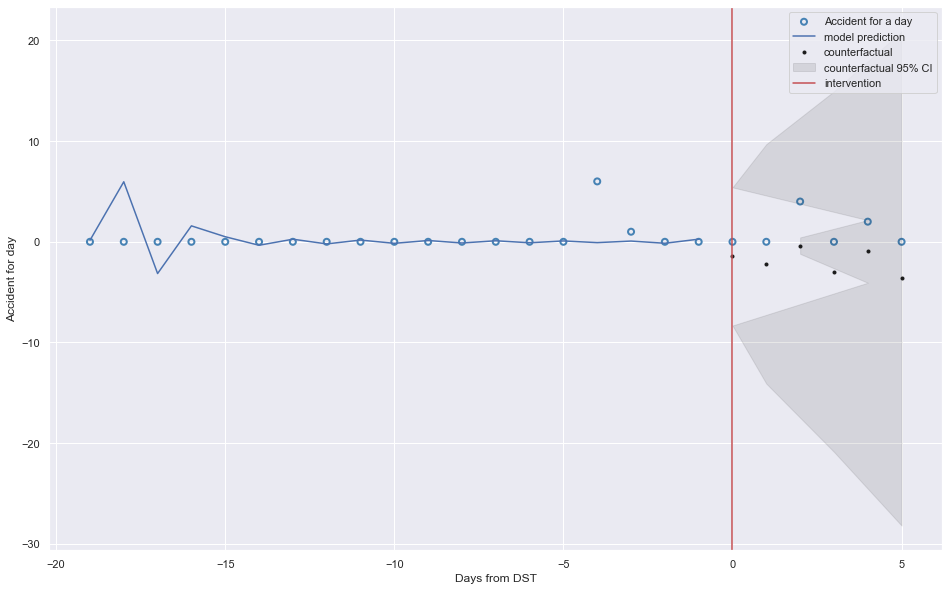

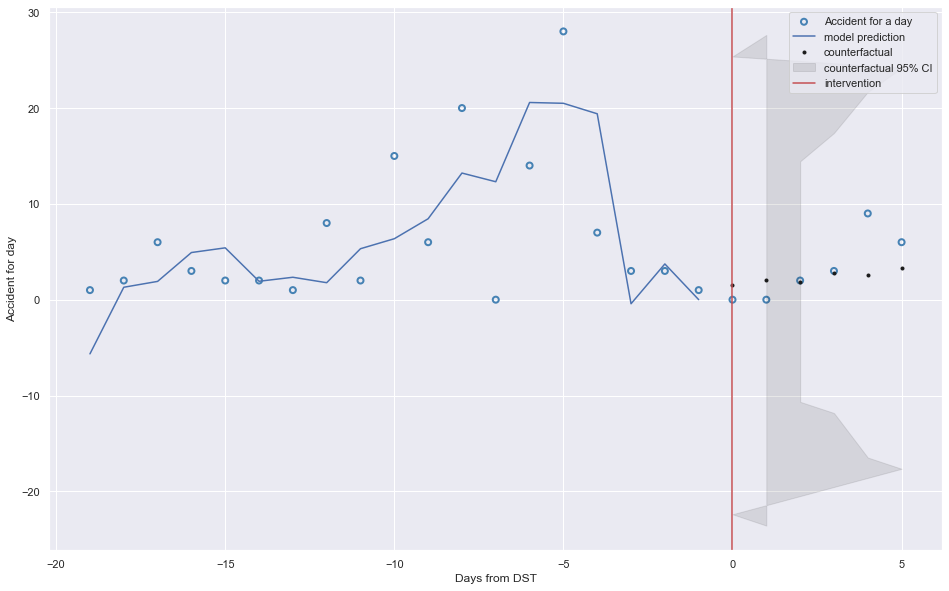

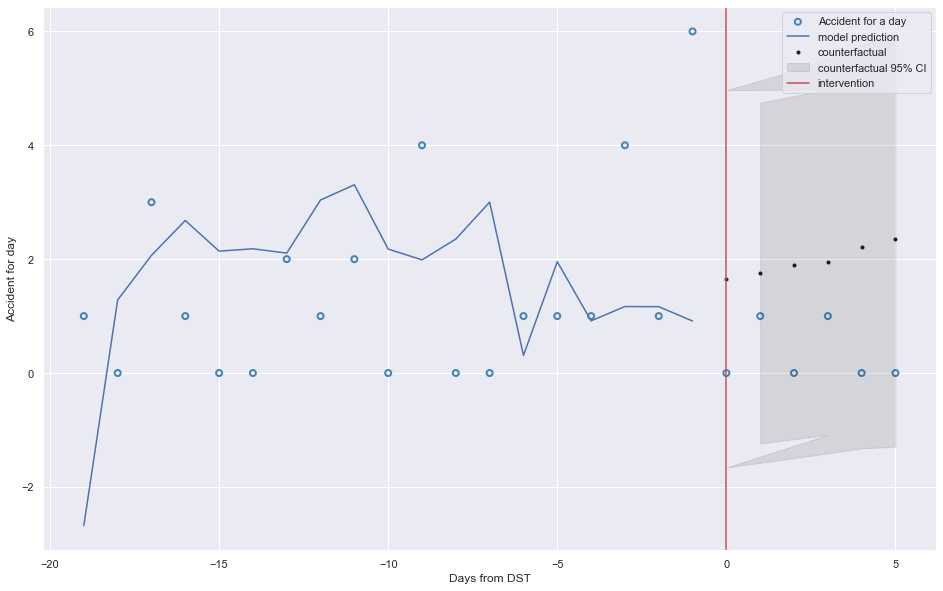

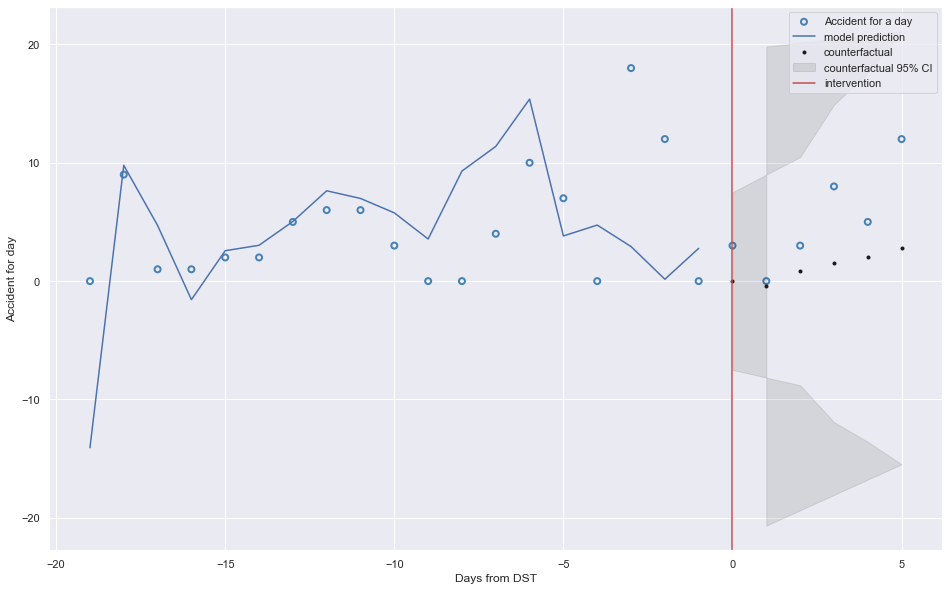

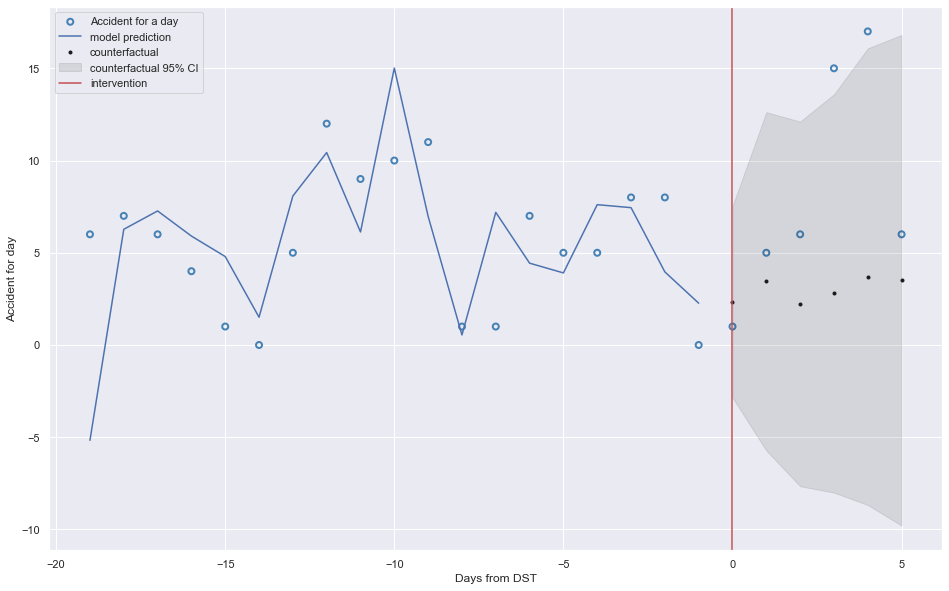

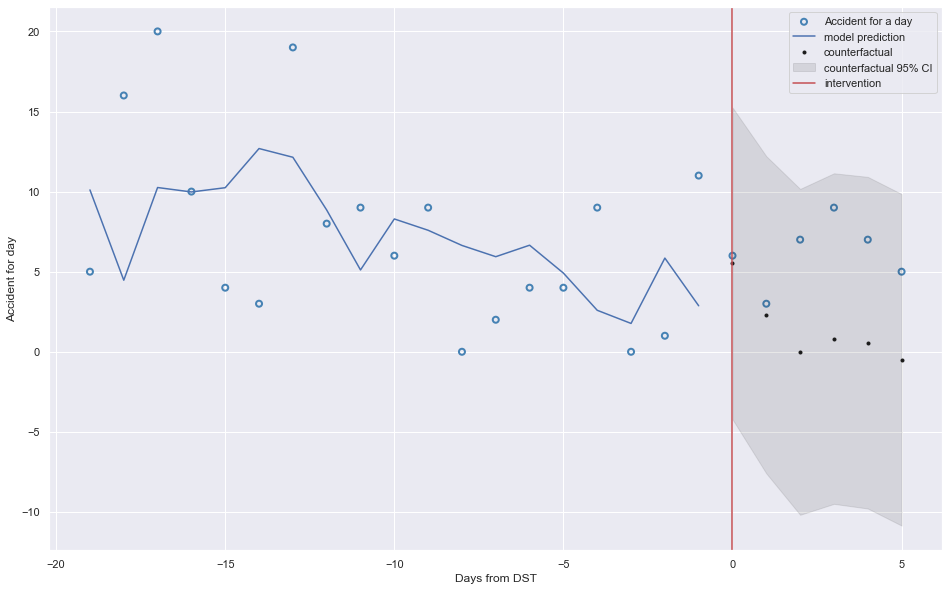

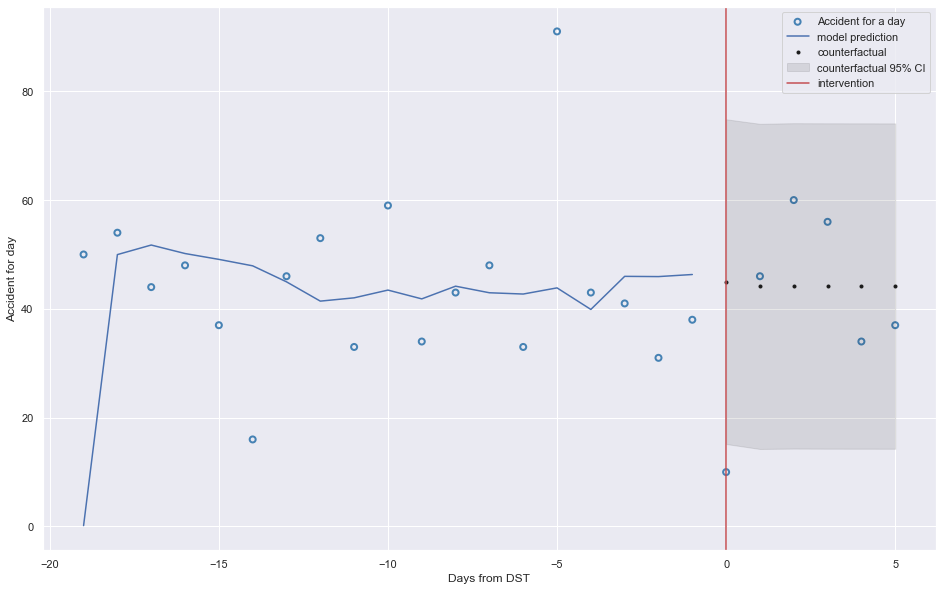

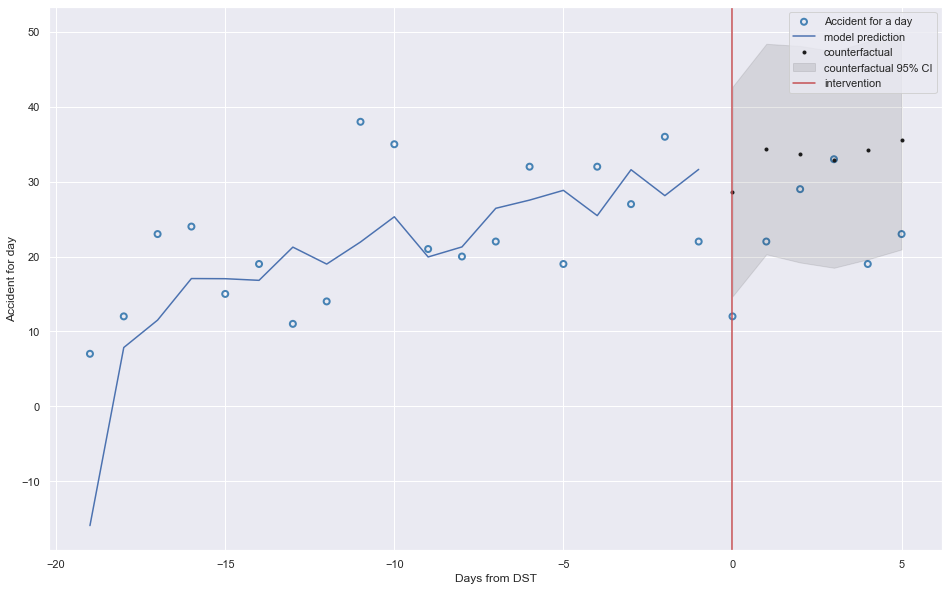

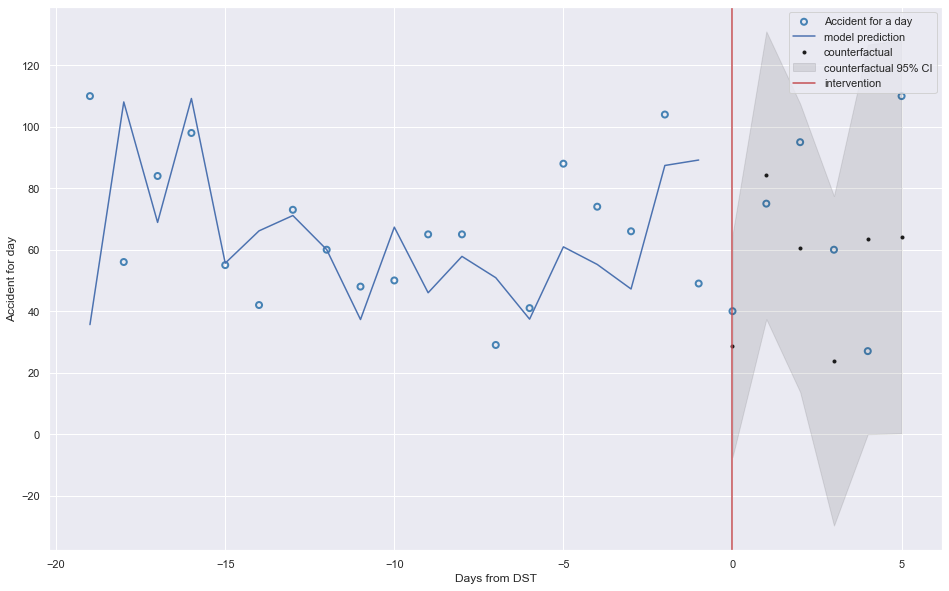

In [72]:
for state in ['AZ', 'NV', 'CO', 'NM' , 'UT']:
    season = 'Winter'
    print(state)
    for year in [2016, 2017,2018,2019,2020,2021]:
        arima(tt[tt['State'] == state], 20, 5, years=[year], print_res=False,orders=(2,1,1))


In [89]:
total_cars = sum(number_of_car_by_state.values())
avg_list = []
car_count = []
for state in ['UT', 'NM', 'CO', 'NV', 'AZ']:
    car_count.append(number_of_car_by_state[state])

for state in [UT, NM, CO,  NV , AZ]:
    state_did =  sum(state)/len(state)
    avg_list.append(state_did)

avg_AZ = sum(AZ)/len(AZ)
weighted_did = [a*b for a,b in zip(avg_list,car_count)]
weighted_did = [item / total_cars for item in weighted_did]
DID_hat = sum(weighted_did[:-1])/ len(weighted_did[:-1]) - weighted_did[4]
DID_hat

-0.19155913481829112

---------------------------------------------------------------------------------------------------------

## Data Distribution

In [7]:
print(f'Total number of accidents: {len(df)}')

Total number of accidents: 139604


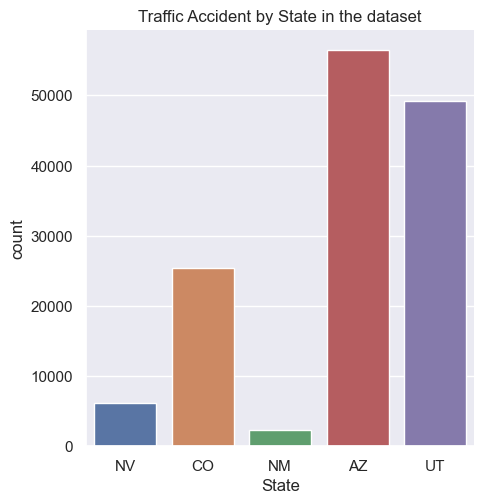

In [8]:
sns.catplot(data=df, x="State", kind="count").set(title='Traffic Accident by State in the dataset')

## Group by week

In [235]:
df = df.groupby(['Start_Time', 'State'])['Start_Time'].count().reset_index(name='Number of accident').rename(columns={"Start_Time": "Date"})
df['Date'] = pd.to_datetime(df['Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Date', freq='W'), "State"])['Number of accident'].sum().reset_index(name='Number of accident in the week')
df = df.set_index('Date')

In [236]:
df

State  Number of accident in the week
Date                                            
2016-04-10    NV                               1
2016-04-17    NV                               2
2016-06-12    NV                               1
2016-06-19    AZ                              50
2016-06-19    CO                              39
...          ...                             ...
2021-12-26    AZ                             731
2021-12-26    CO                             662
2021-12-26    NM                               2
2021-12-26    NV                             206
2021-12-26    UT                             768

[1364 rows x 2 columns]

df['Year'] = pd.to_datetime(df['Start_Time'], errors='coerce').dt.year
df['Month'] = pd.to_datetime(df['Start_Time'], errors='coerce').dt.month
df['Day'] = pd.to_datetime(df['Start_Time'], errors='coerce').dt.day
df['Date'] = pd.to_datetime(df['Start_Time'], errors='coerce').dt.date

## General time series analasis

NV


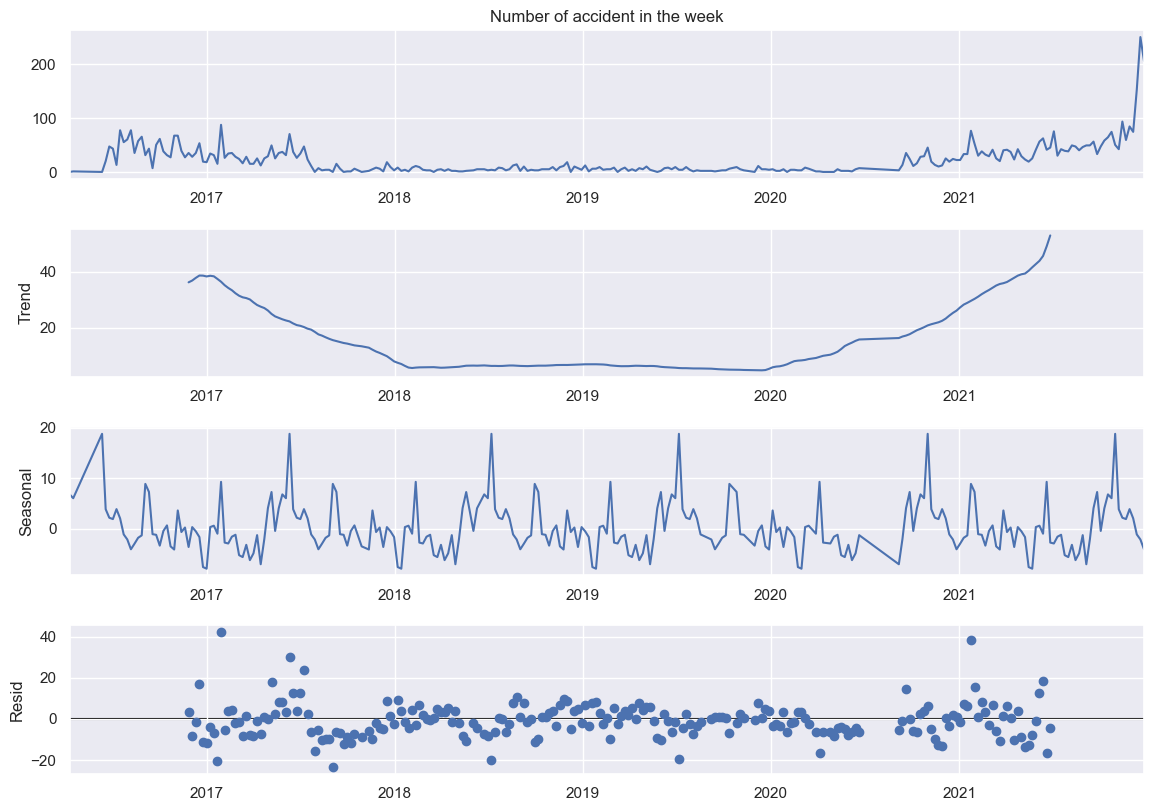

UT


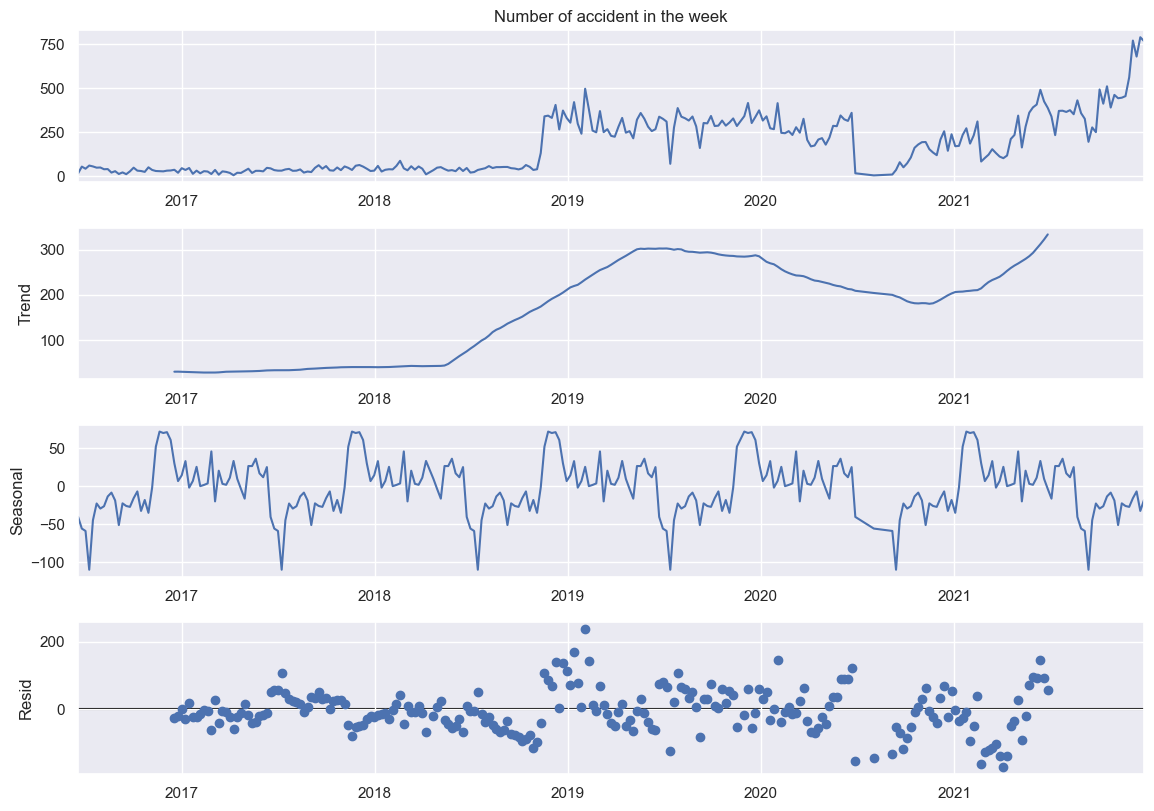

AZ


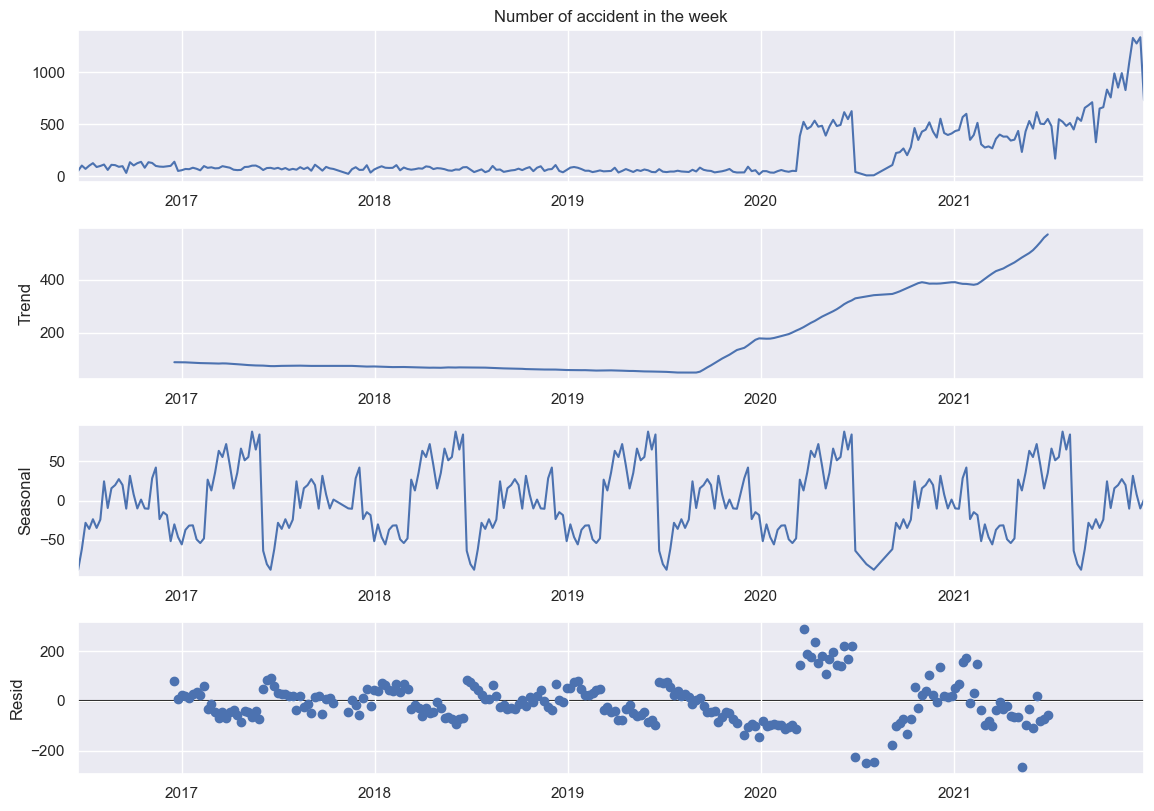

CO


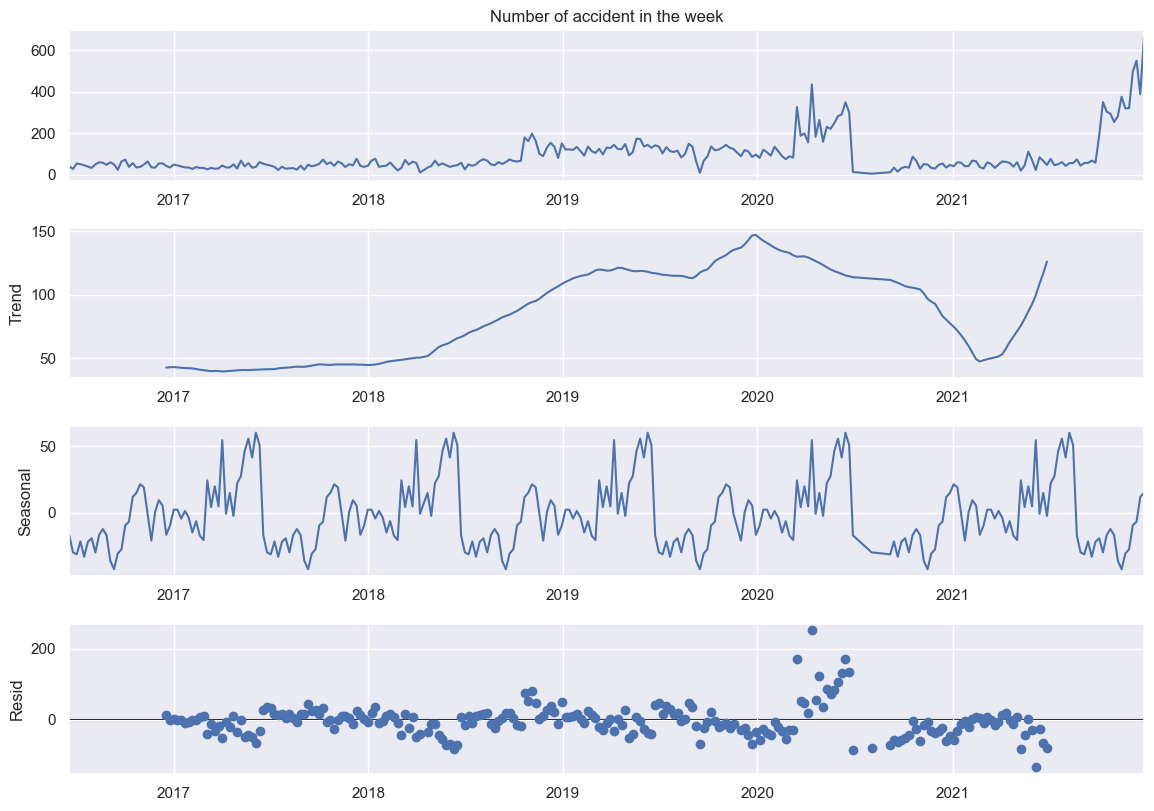

NM


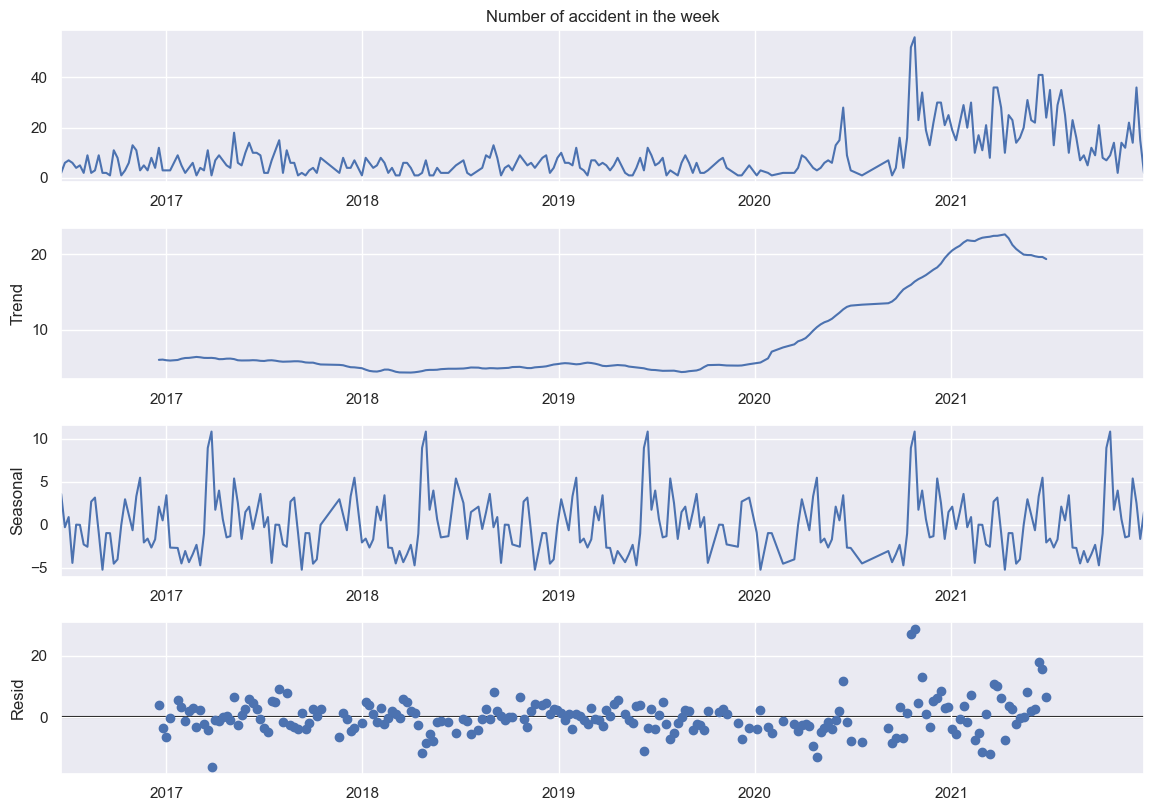

In [258]:
for state in SWester_states:
    print(state)
    y = df[df.State == state]['Number of accident in the week']
    decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=52)
    fig = decomposition.plot()
    plt.show()

## Close to DST time series analasis

<Figure size 1170x827 with 0 Axes>

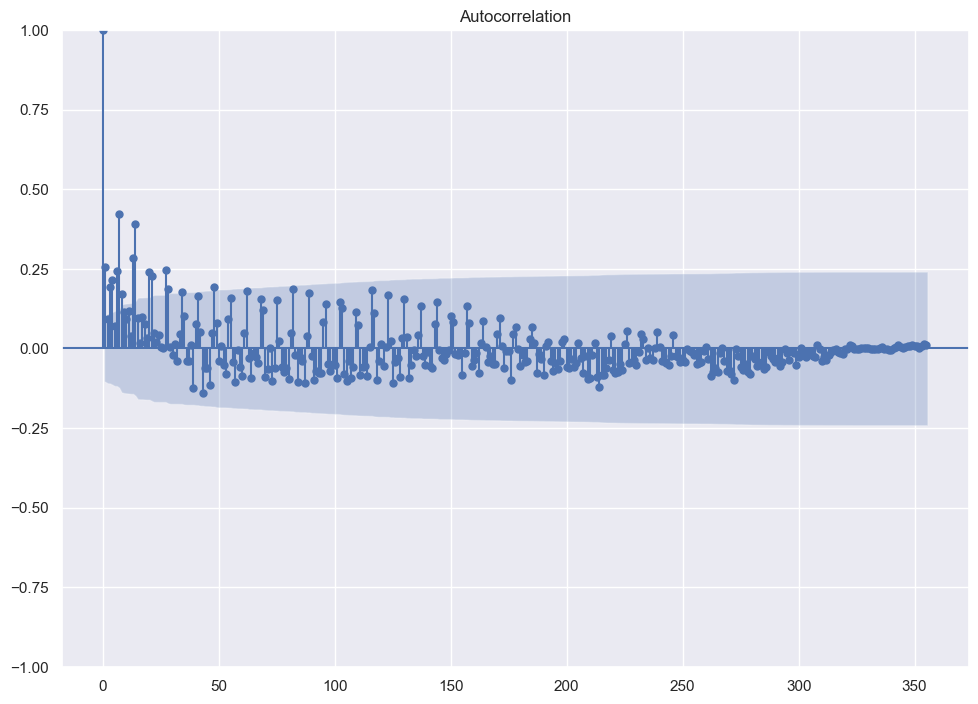

<Figure size 1170x827 with 0 Axes>

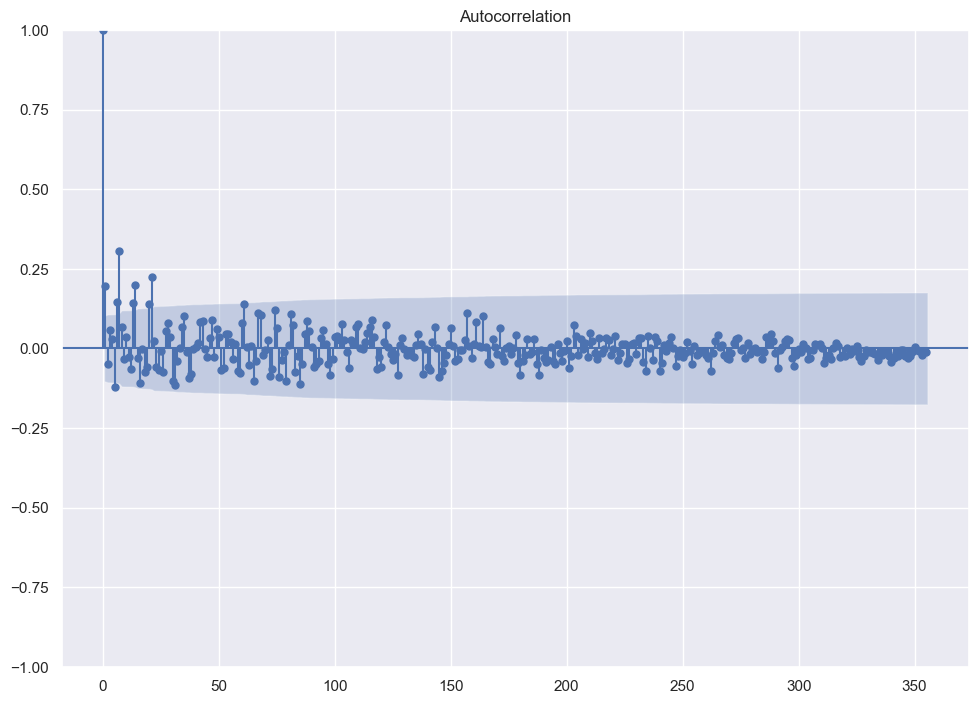

<Figure size 1170x827 with 0 Axes>

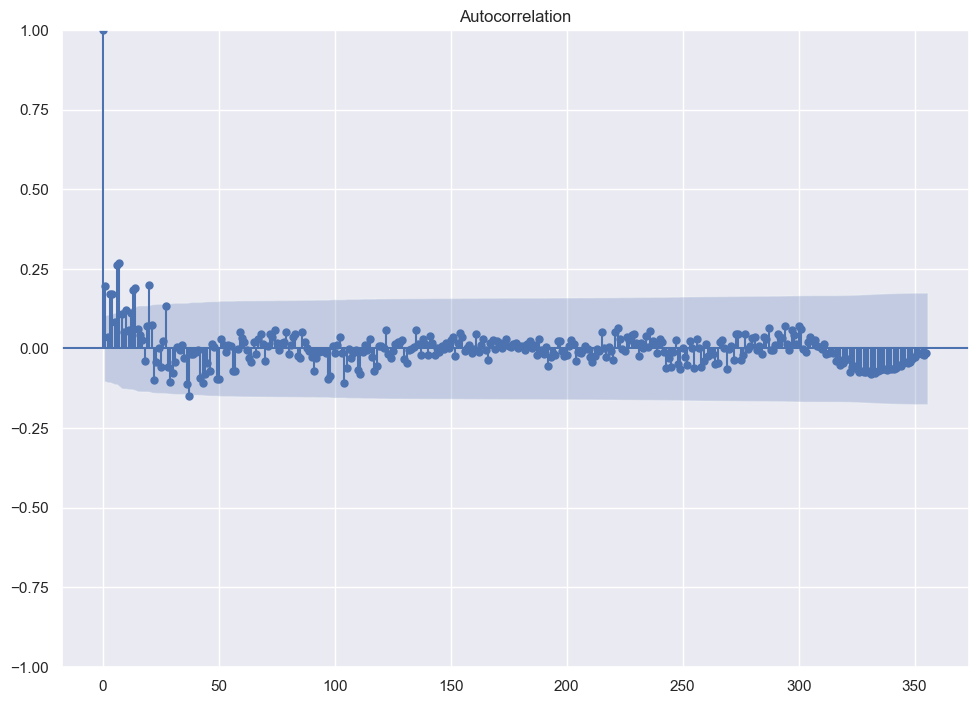

<Figure size 1170x827 with 0 Axes>

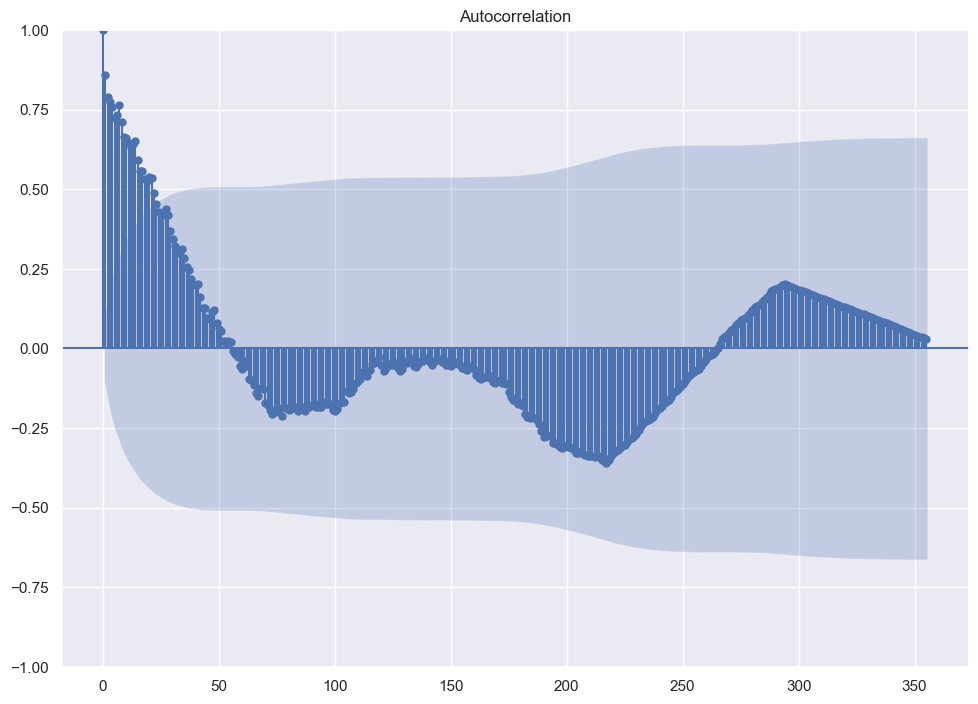

In [95]:
for year in [2017, 2018, 2019, 2020]:
    plt.figure(year)
    plot_auto_close_to_dst(tt[(tt['State'] == 'AZ') & (pd.to_datetime(tt['Start_Time']).dt.year == year)], lags=355)

## ------------------------------------------------------------------------------------------------------------------

In [85]:
grouped

Date  Year  Month  Day  Number of accident
0     2016-01-14  2016      1   14                   7
1     2016-02-08  2016      2    8                  22
2     2016-02-09  2016      2    9                  24
3     2016-02-10  2016      2   10                  32
4     2016-02-11  2016      2   11                  58
...          ...   ...    ...  ...                 ...
2094  2021-12-27  2021     12   27                8777
2095  2021-12-28  2021     12   28                8220
2096  2021-12-29  2021     12   29                8698
2097  2021-12-30  2021     12   30               10171
2098  2021-12-31  2021     12   31                6936

[2099 rows x 5 columns]

We can see that around 2020 number of accident raised dramaticly, this might be explained with the way the data is collected.

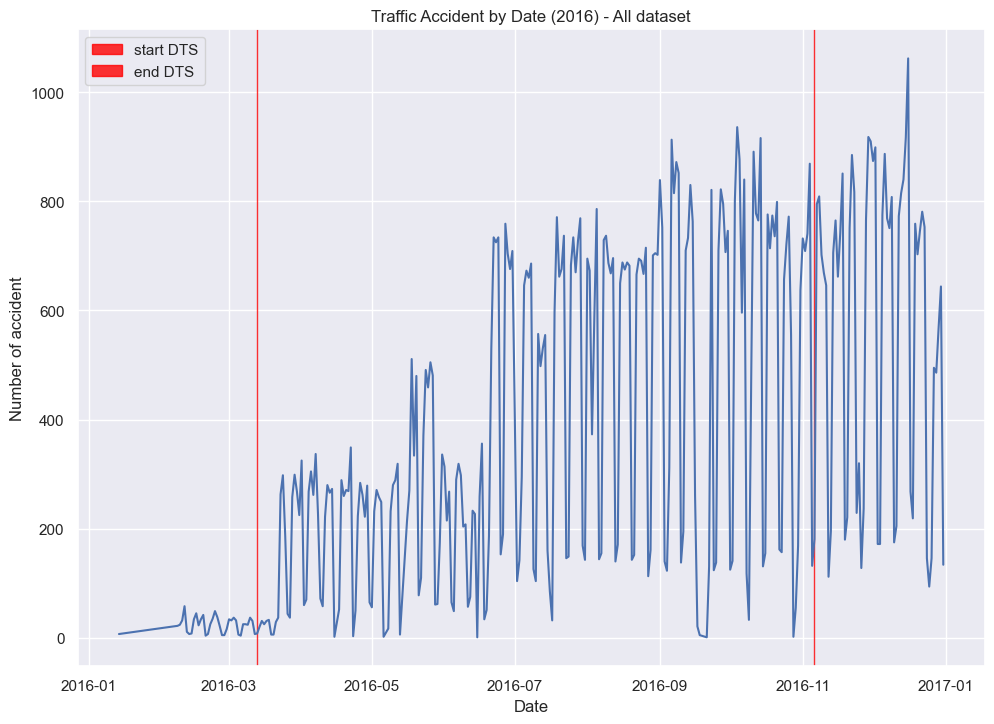

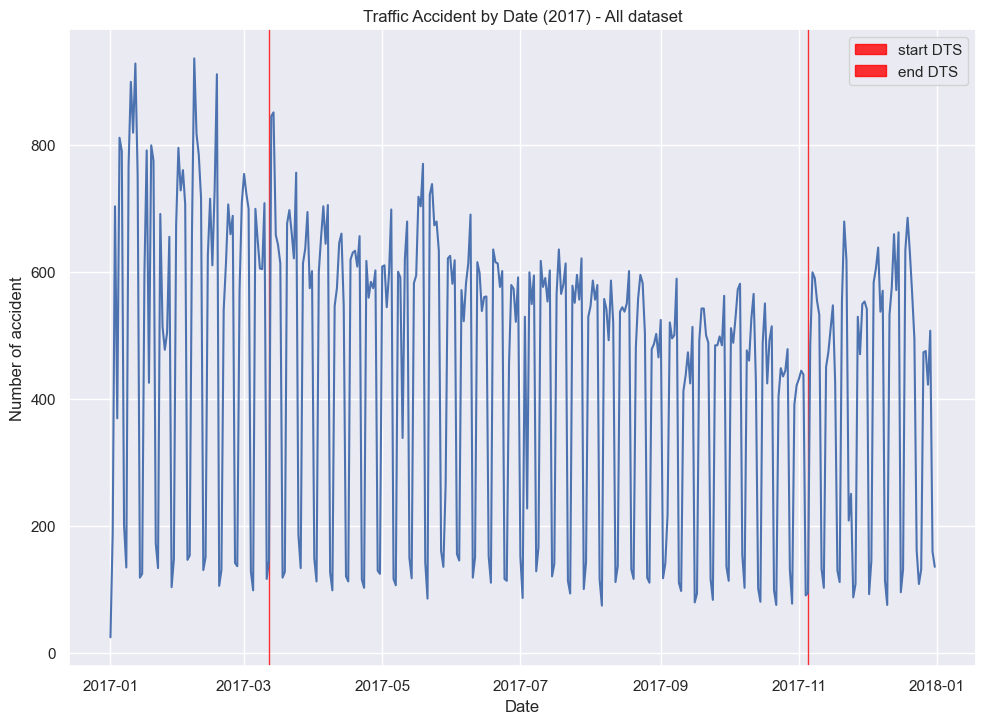

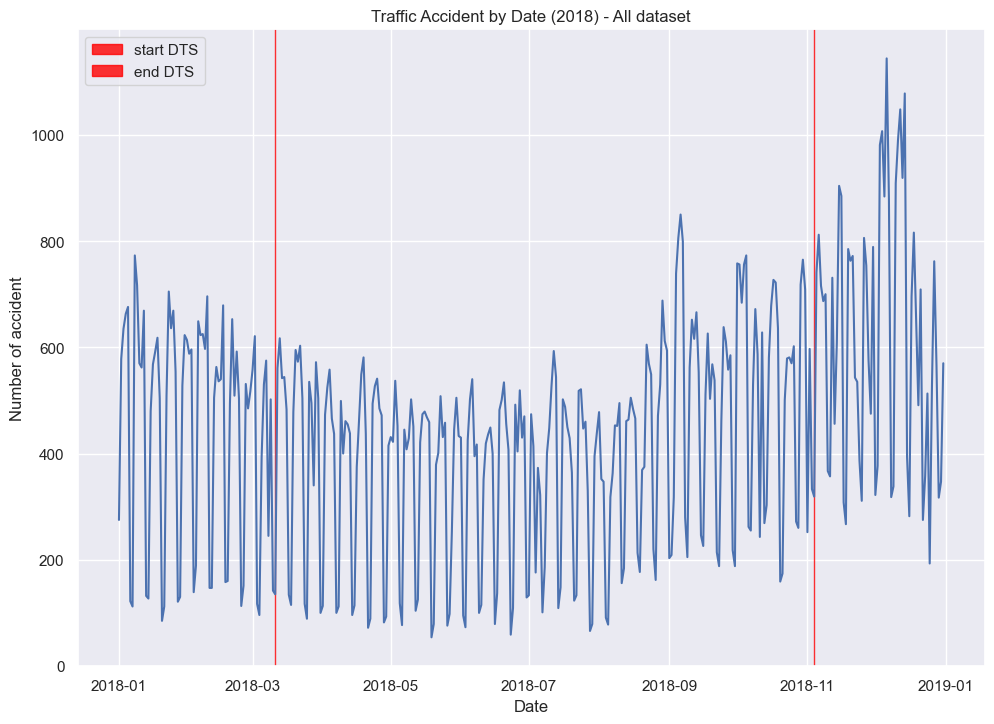

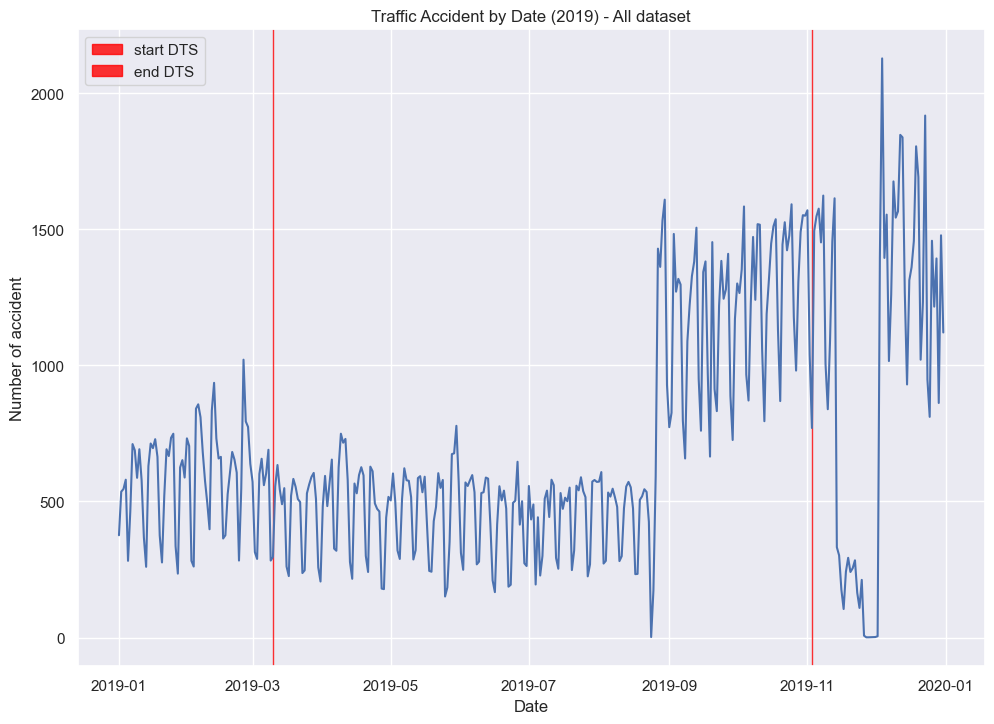

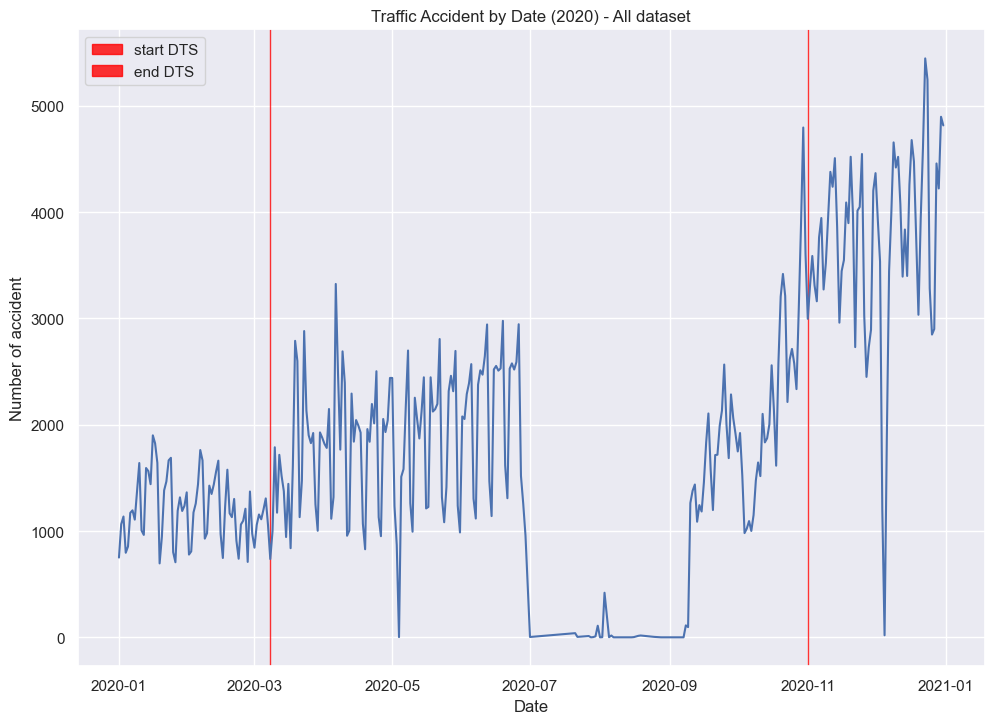

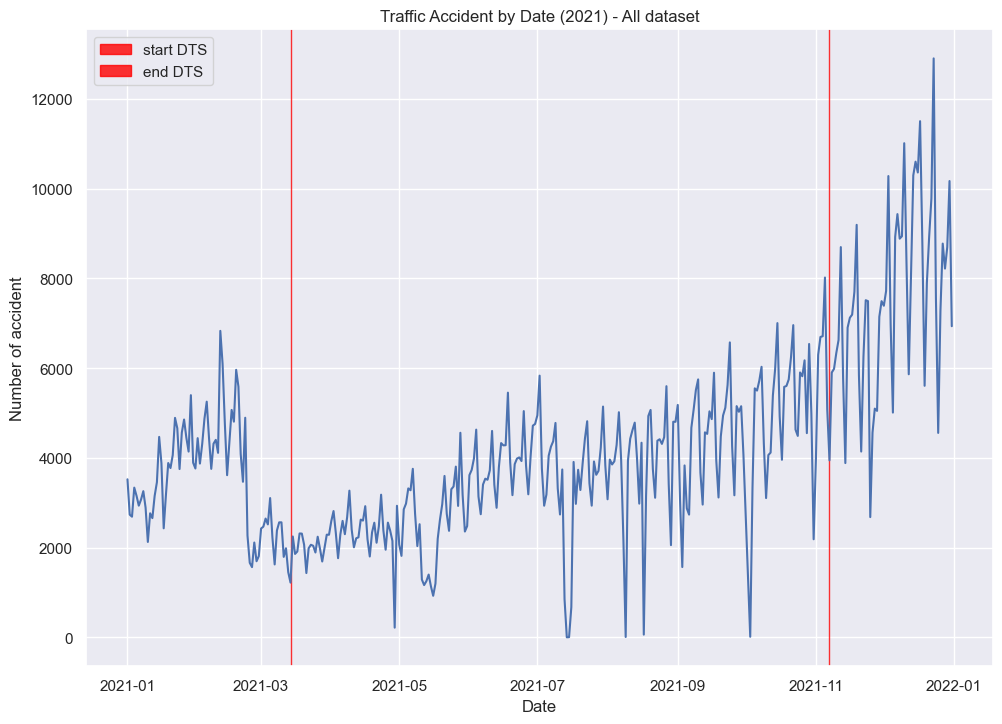

In [101]:
for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    plt.figure(year)
    plt.axvspan(date2num(daylight_dates[year]['start']), date2num(daylight_dates[year]['start']), 
           label="start DTS",color="red", alpha=0.8)
    plt.axvspan(date2num(daylight_dates[year]['end']), date2num(daylight_dates[year]['end']), 
           label="end DTS",color="red", alpha=0.8)
    sns.lineplot(x="Date", y="Number of accident", data=grouped[grouped['Year'] == year]).set(title=f'Traffic Accident by Date ({year}) - All dataset')

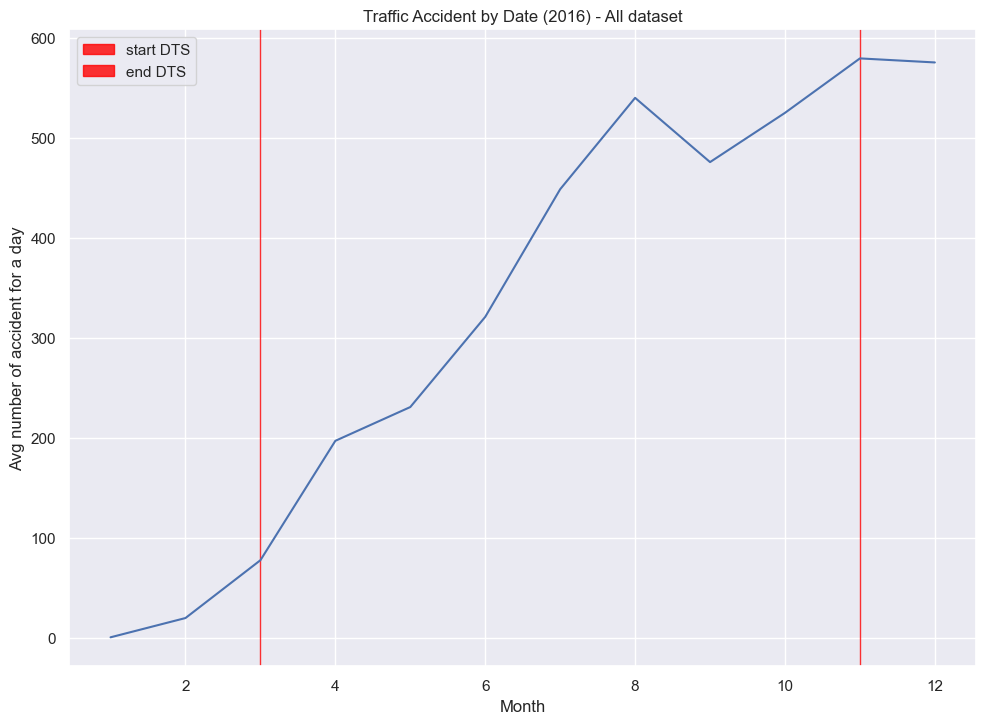

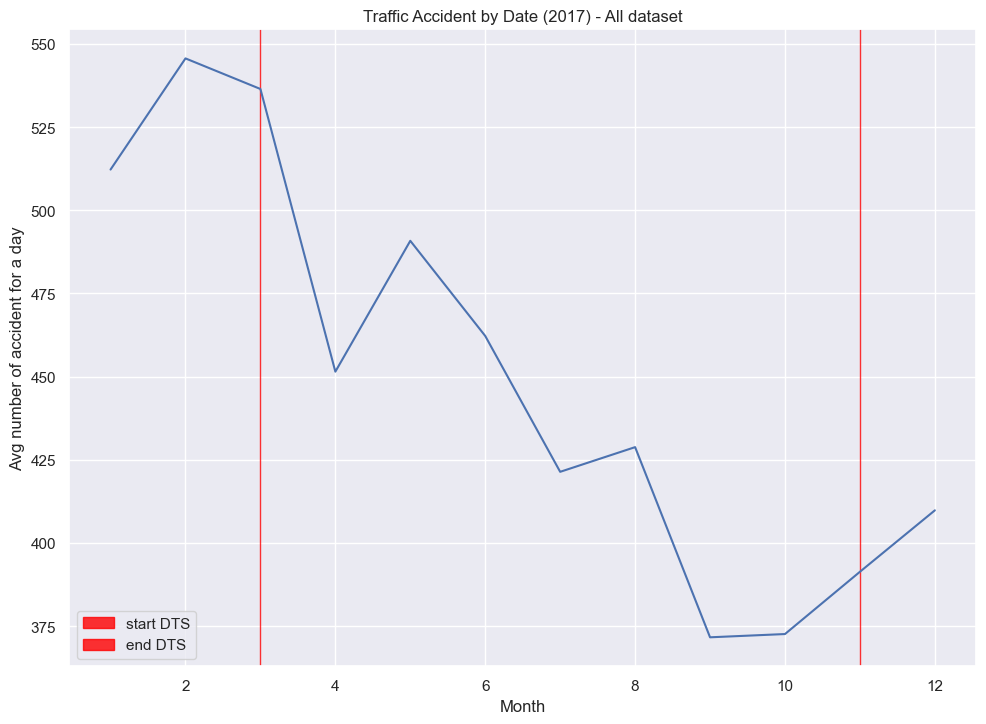

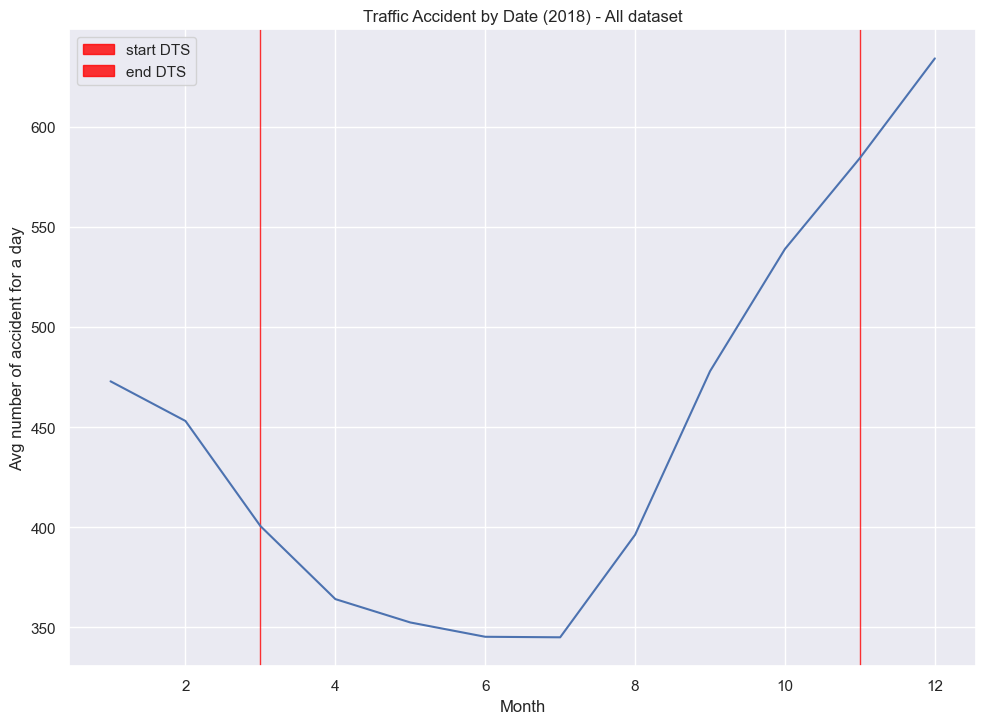

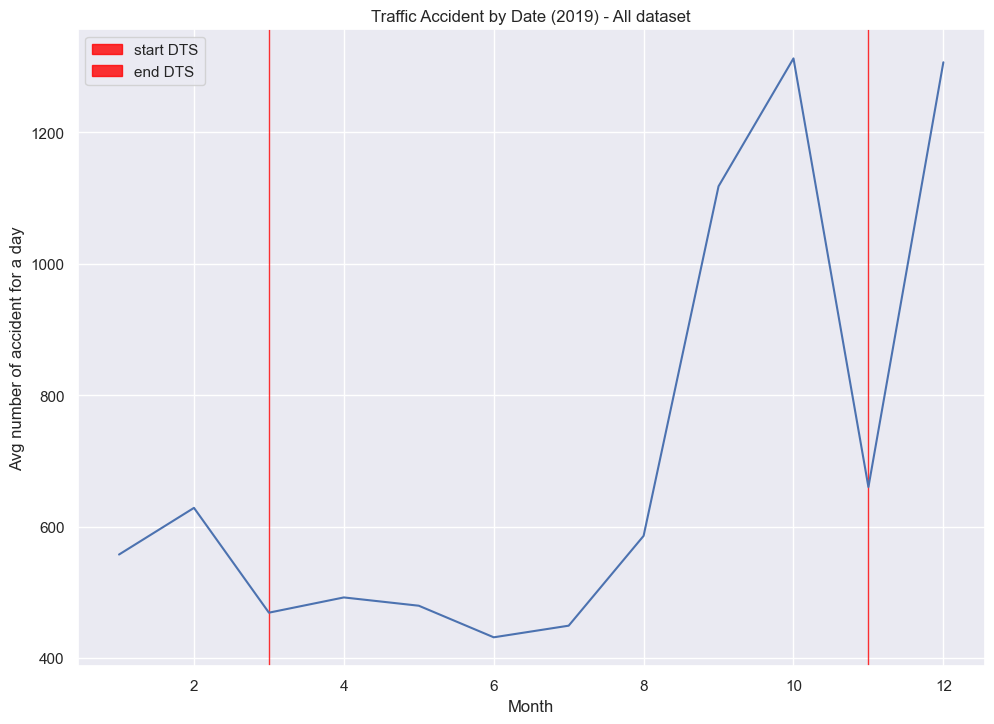

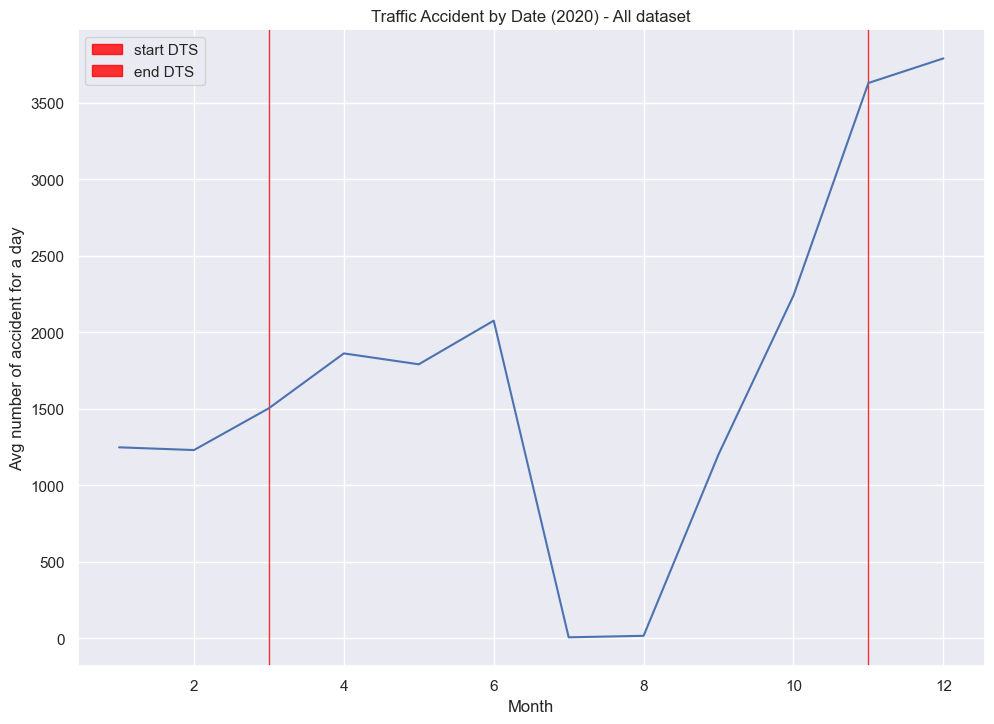

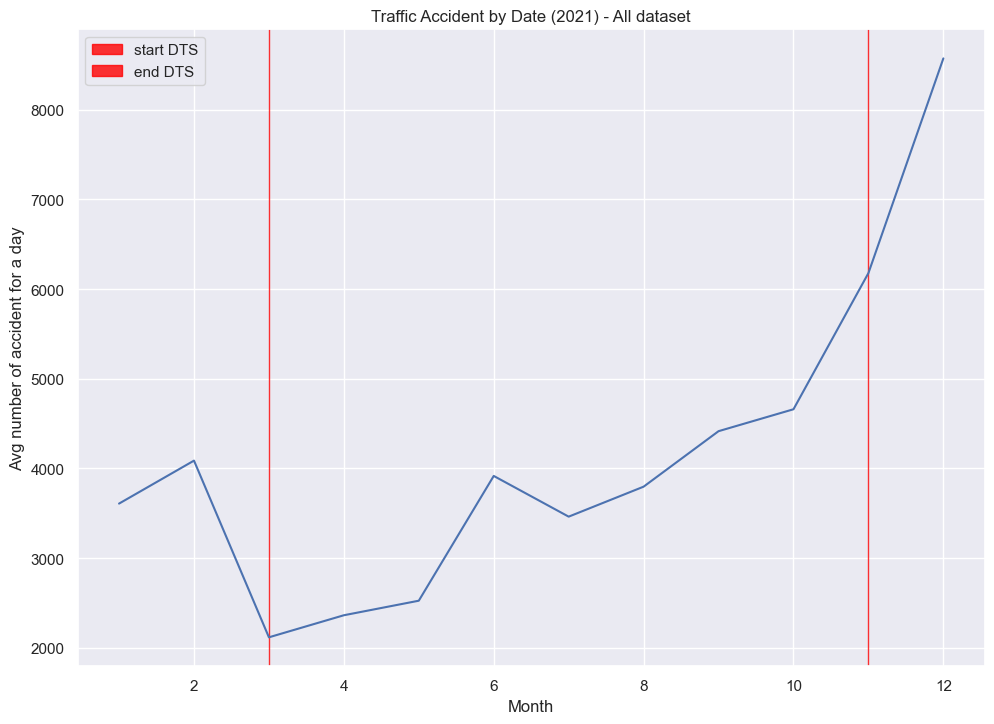

In [142]:
grouped_by_month = df.groupby(['Month', 'Year'])['Month'].count().reset_index(name='Avg number of accident for a day')
grouped_by_month['Avg number of accident for a day'] = grouped_by_month.apply(lambda x: x['Avg number of accident for a day'] / number_of_day_in_month[x['Month']], axis=1)
for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    plt.figure(year)
    plt.axvspan(daylight_dates[year]['start'].month, daylight_dates[year]['start'].month, 
           label="start DTS",color="red", alpha=0.8)
    plt.axvspan(daylight_dates[year]['end'].month, daylight_dates[year]['end'].month, 
           label="end DTS",color="red", alpha=0.8)
    sns.lineplot(x="Month", y="Avg number of accident for a day", data=grouped_by_month[grouped_by_month['Year'] == year]).set(title=f'Traffic Accident by Date ({year}) - All dataset')

## Analysis for a specific state

In [121]:
grouped_ny = df[df['State'] == "NY"].groupby(['Date', 'Year', 'Month', 'Day'])['Date'].count().reset_index(name='Number of accident')

[Text(0.5, 1.0, 'NY - Traffic Accident by Date - All dataset')]

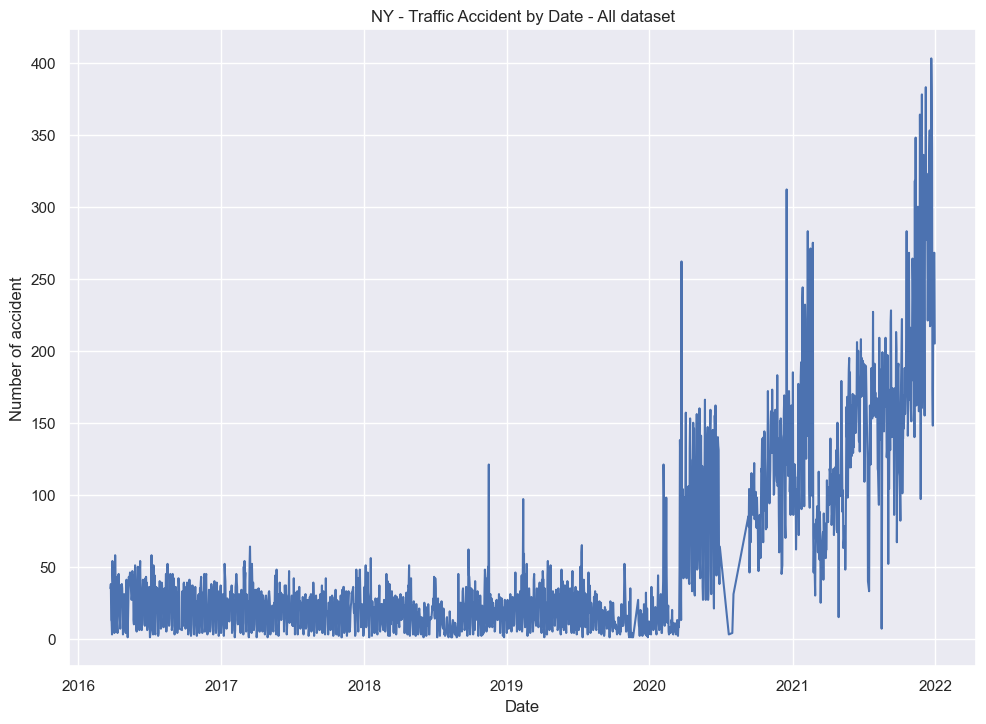

In [123]:
sns.lineplot(x="Date", y="Number of accident", data=grouped_ny).set(title='NY - Traffic Accident by Date - All dataset')

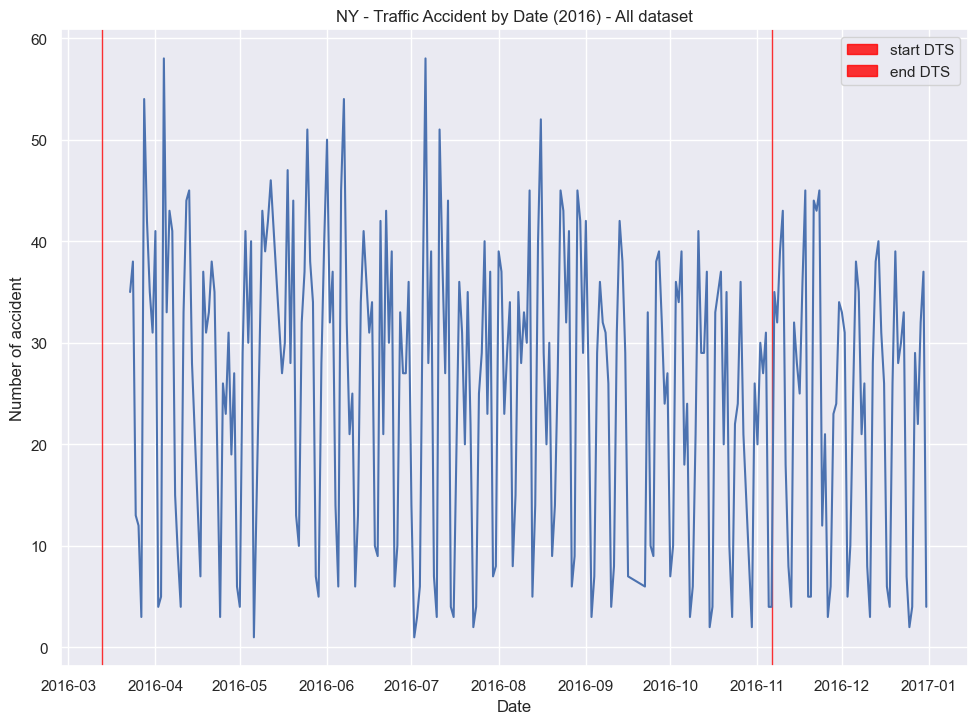

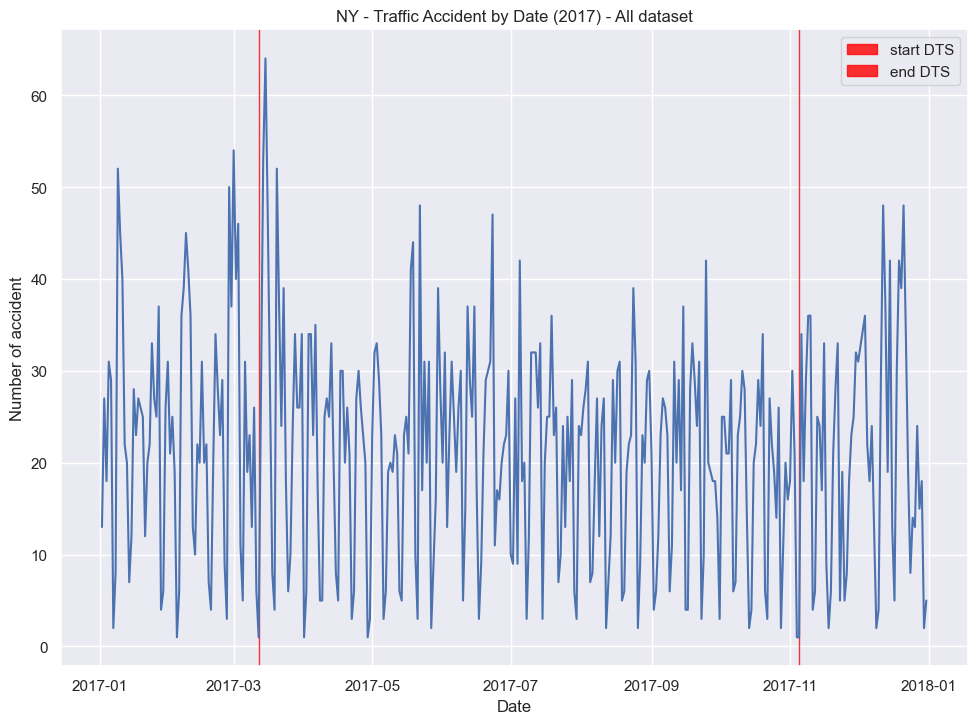

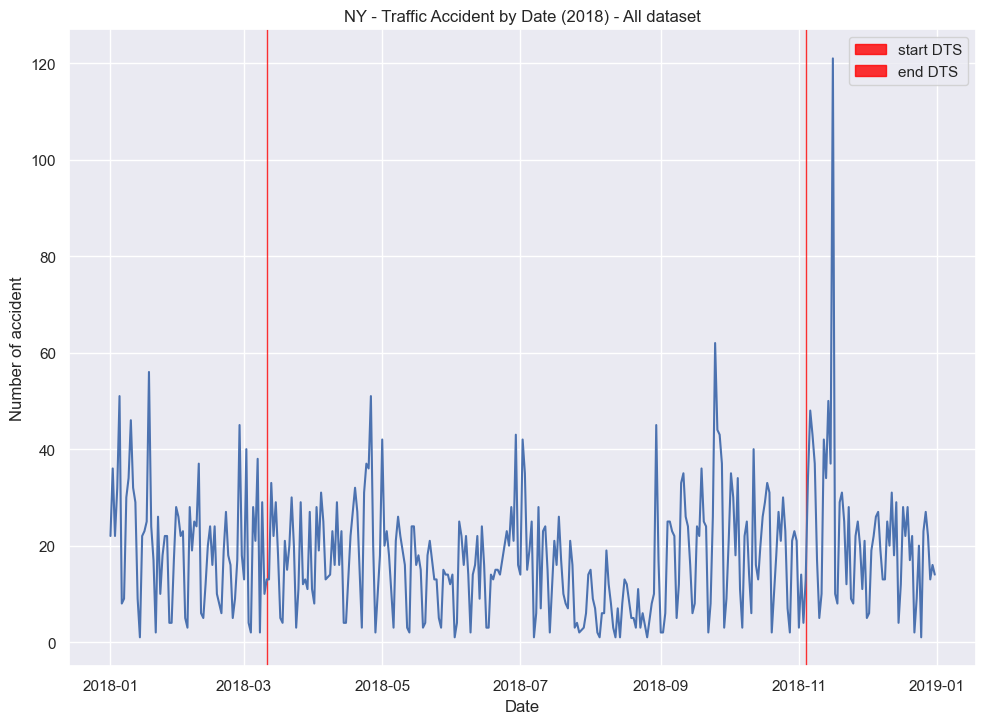

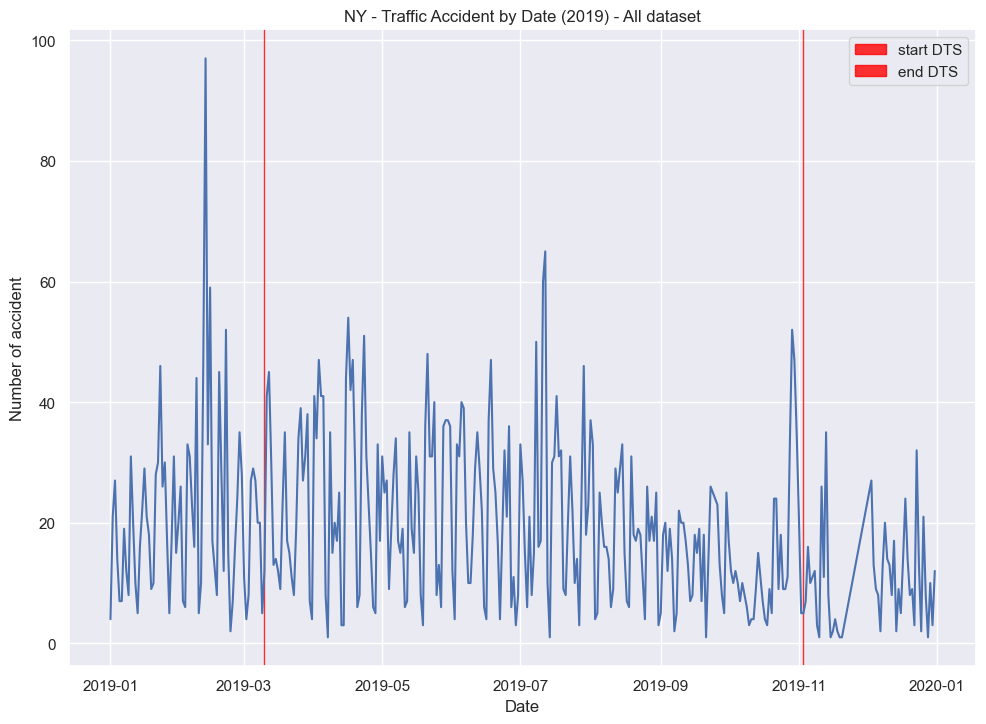

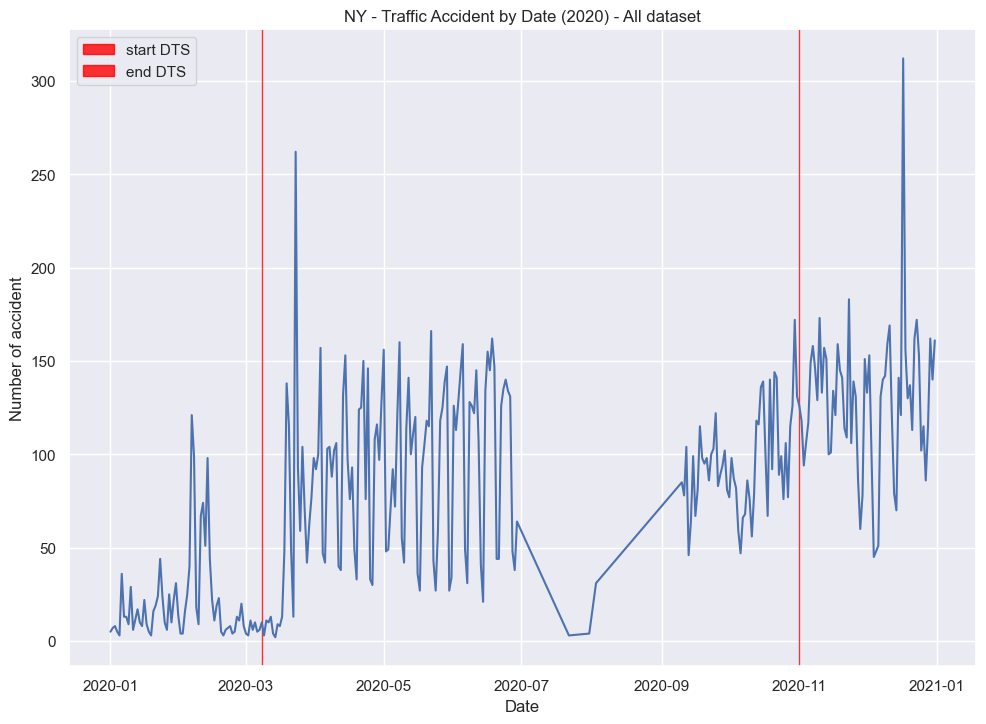

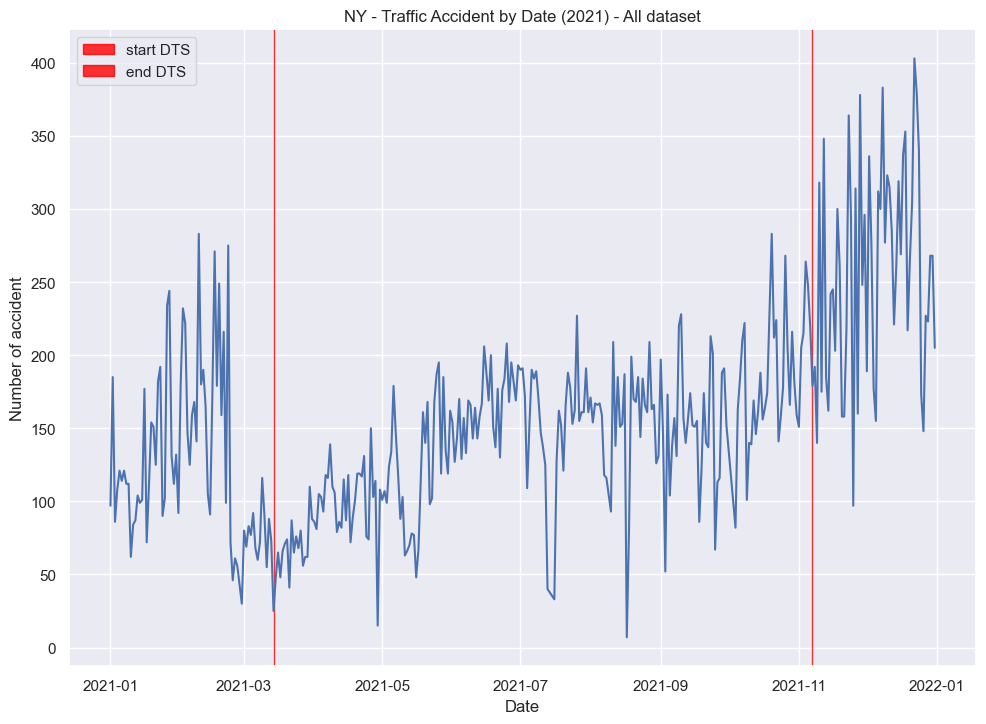

In [126]:
for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    plt.figure(year)
    plt.axvspan(date2num(daylight_dates[year]['start']), date2num(daylight_dates[year]['start']), 
           label="start DTS",color="red", alpha=0.8)
    plt.axvspan(date2num(daylight_dates[year]['end']), date2num(daylight_dates[year]['end']), 
           label="end DTS",color="red", alpha=0.8)
    sns.lineplot(x="Date", y="Number of accident", data=grouped_ny[grouped_ny['Year'] == year]).set(title=f'NY - Traffic Accident by Date ({year}) - All dataset')

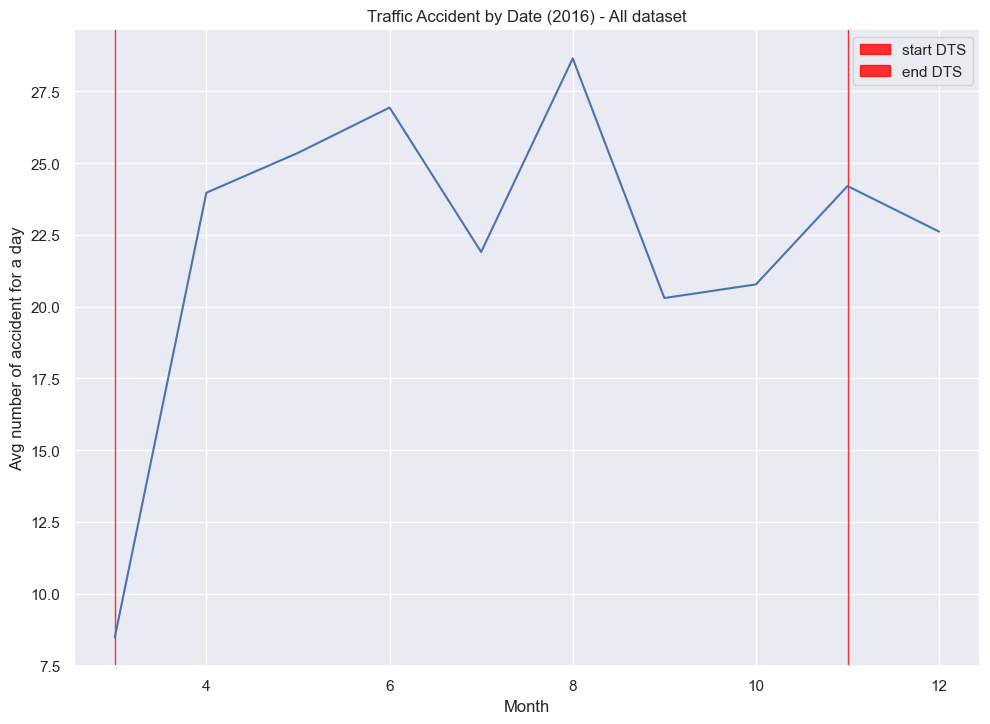

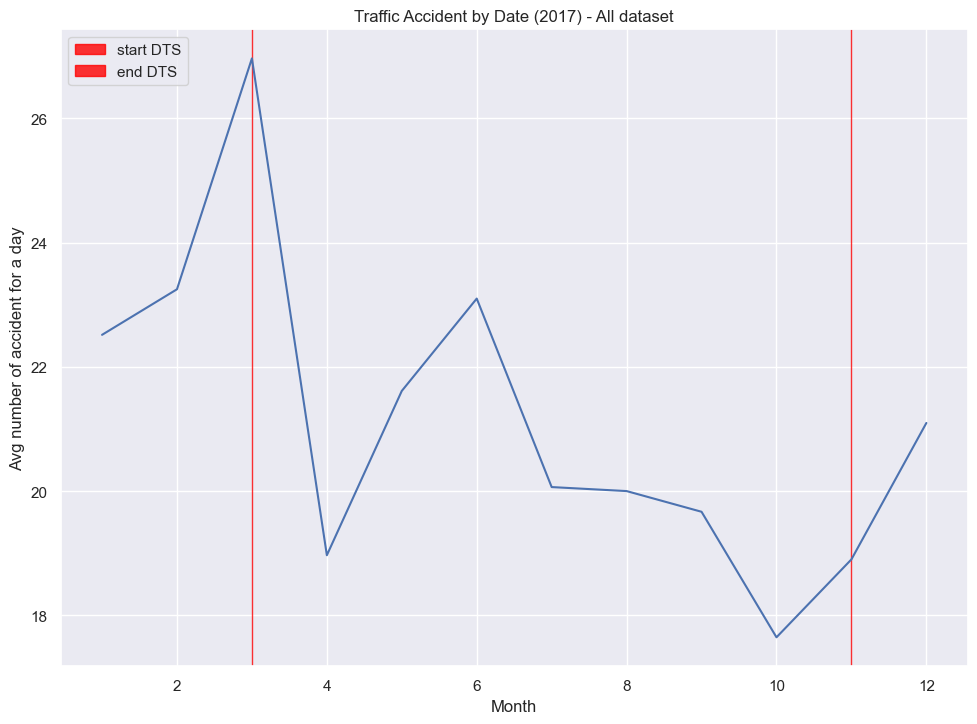

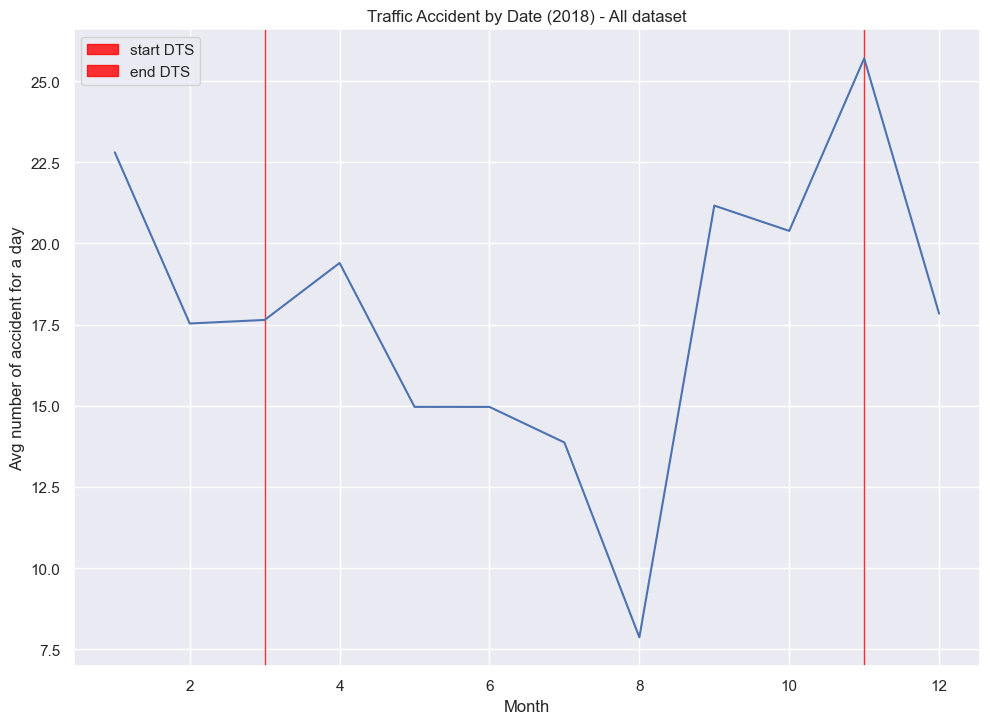

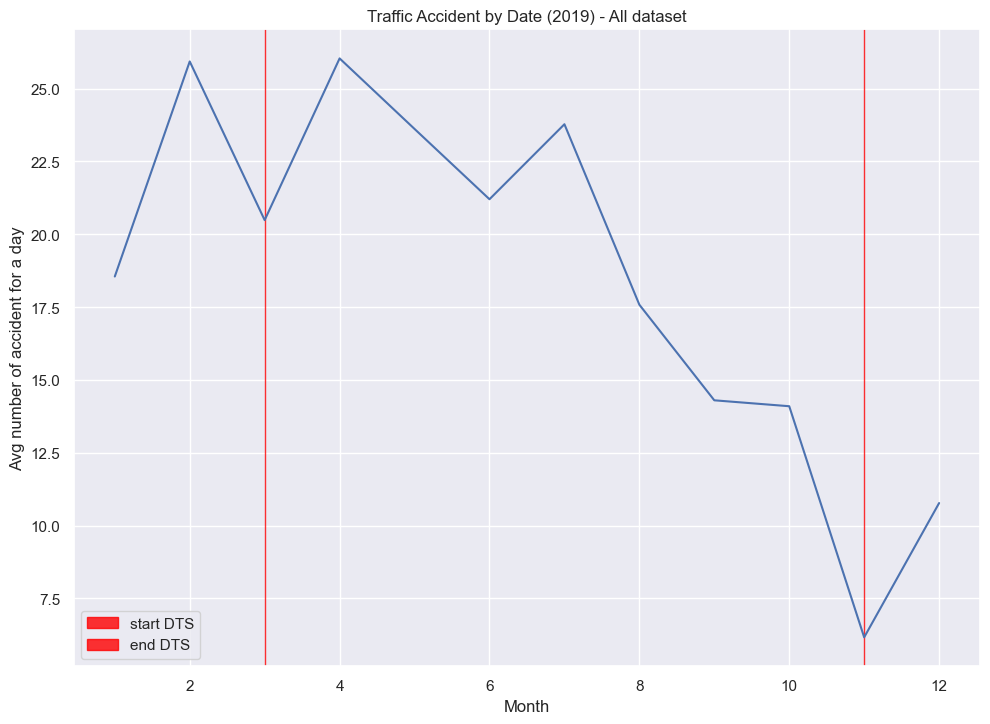

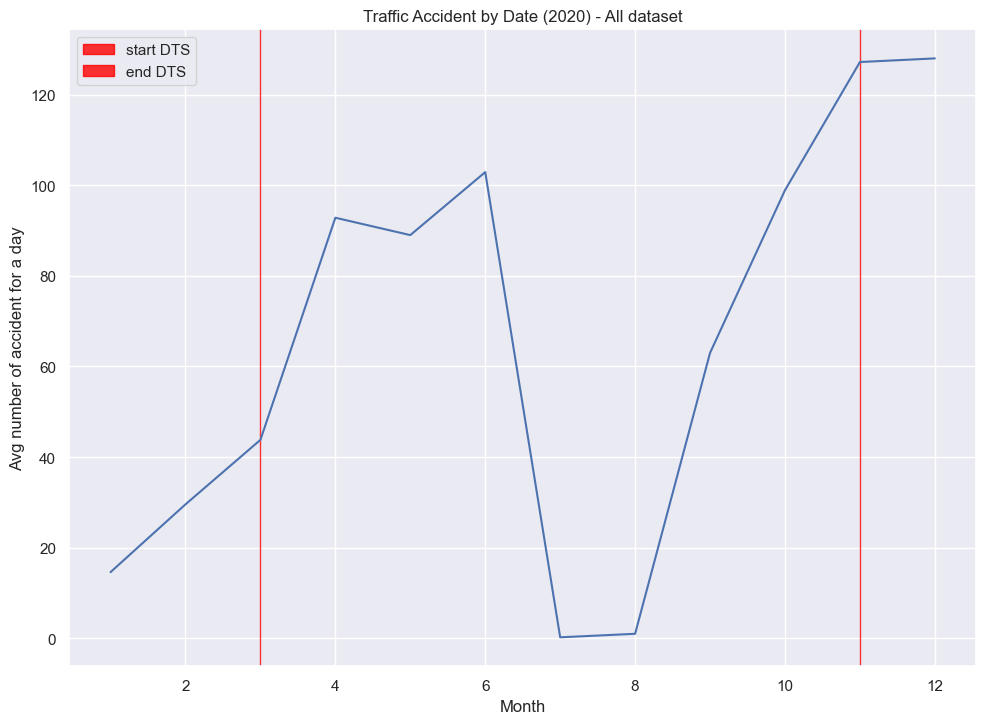

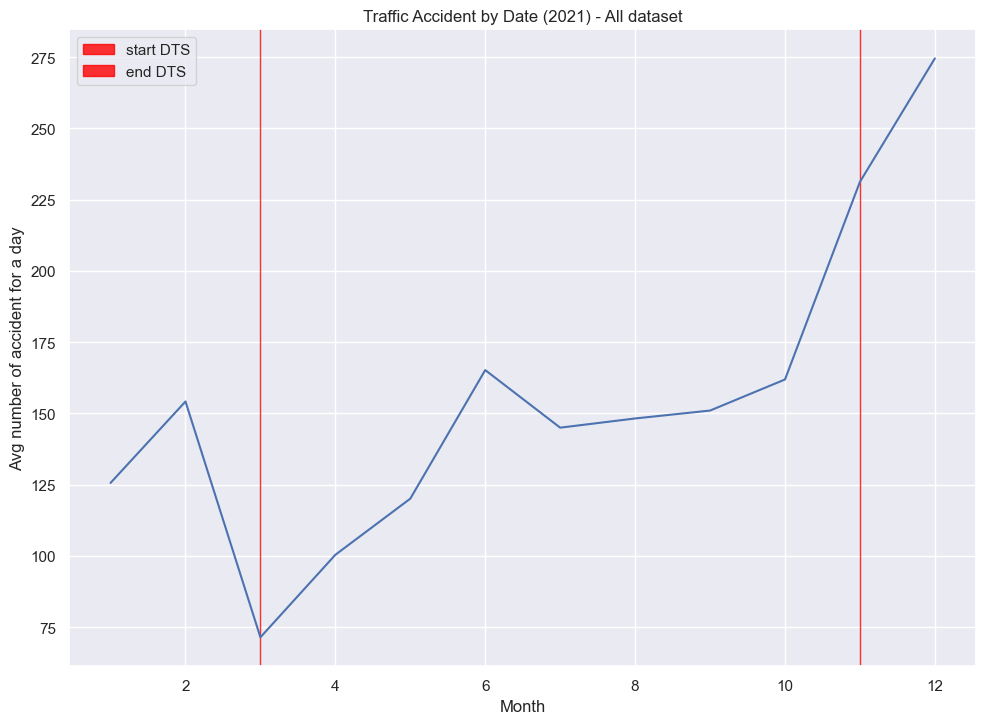

In [143]:
grouped_by_month = df[df['State'] == 'NY'].groupby(['Month', 'Year'])['Month'].count().reset_index(name='Avg number of accident for a day')
grouped_by_month['Avg number of accident for a day'] = grouped_by_month.apply(lambda x: x['Avg number of accident for a day'] / number_of_day_in_month[x['Month']], axis=1)
for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    plt.figure(year)
    plt.axvspan(daylight_dates[year]['start'].month, daylight_dates[year]['start'].month, 
           label="start DTS",color="red", alpha=0.8)
    plt.axvspan(daylight_dates[year]['end'].month, daylight_dates[year]['end'].month, 
           label="end DTS",color="red", alpha=0.8)
    sns.lineplot(x="Month", y="Avg number of accident for a day", data=grouped_by_month[grouped_by_month['Year'] == year]).set(title=f'Traffic Accident by Date ({year}) - All dataset')

## State without DST

In [130]:
grouped_az = df[df['State'] == "AZ"].groupby(['Date', 'Year', 'Month', 'Day'])['Date'].count().reset_index(name='Number of accident')

[Text(0.5, 1.0, 'NY - Traffic Accident by Date - All dataset')]

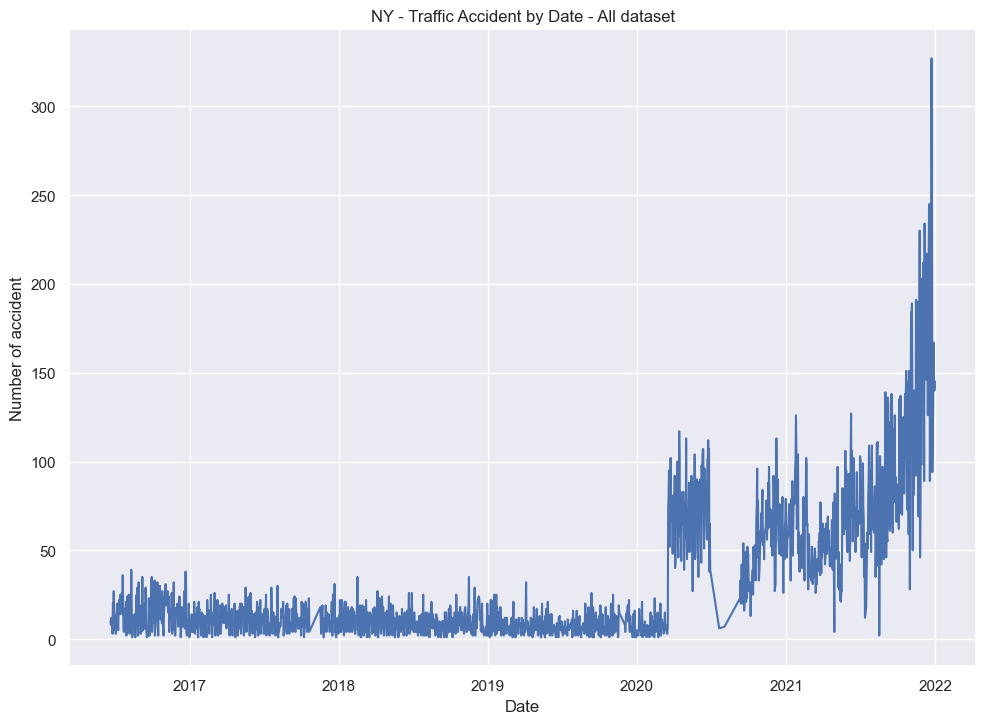

In [131]:
sns.lineplot(x="Date", y="Number of accident", data=grouped_az).set(title='NY - Traffic Accident by Date - All dataset')

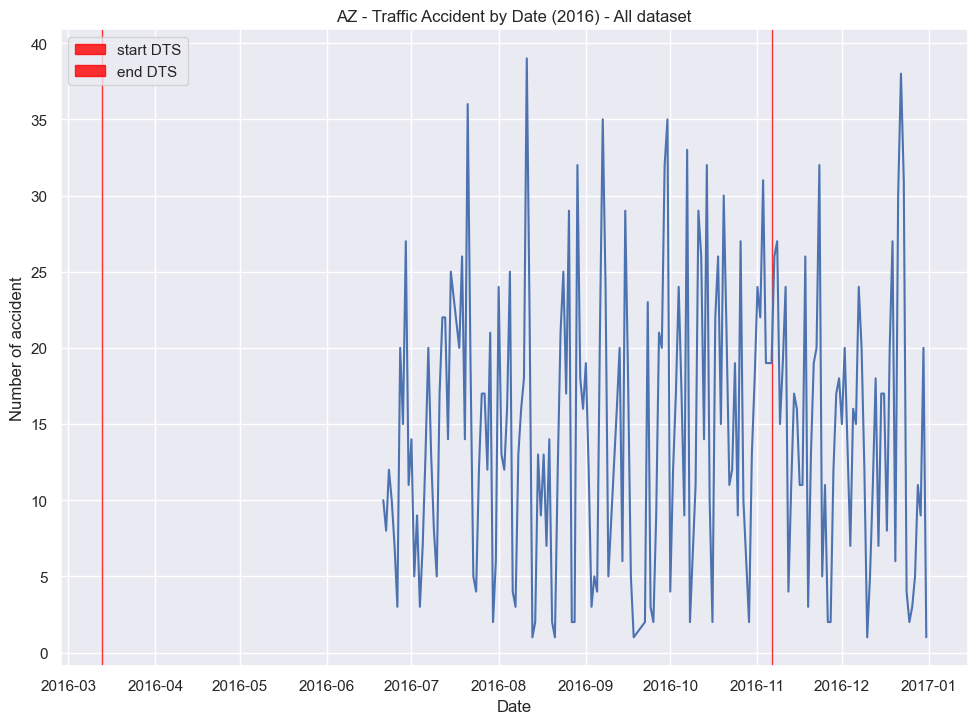

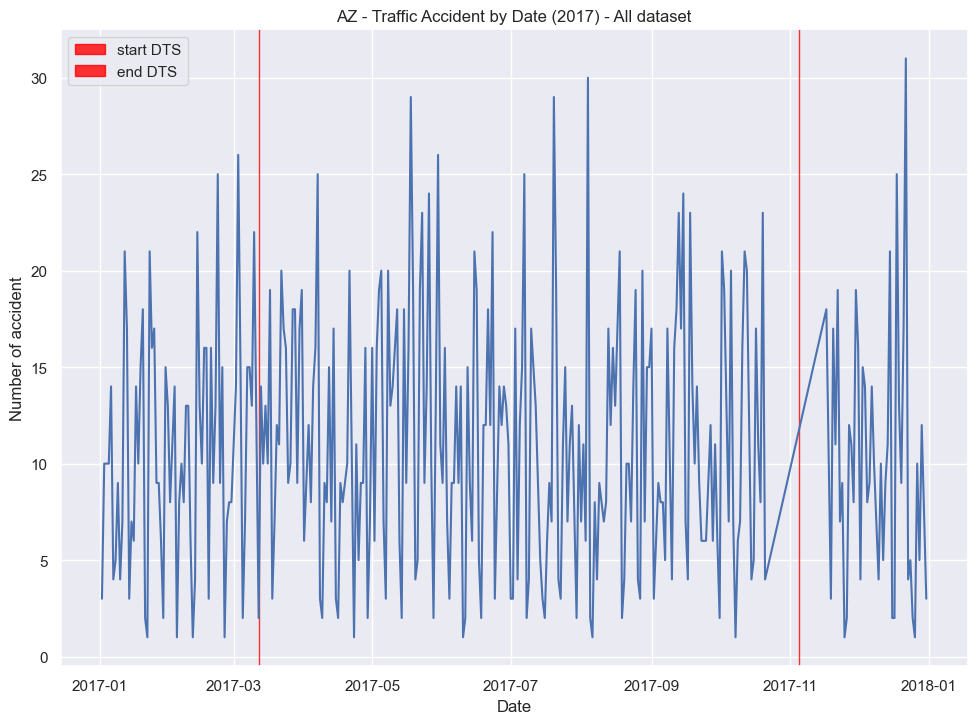

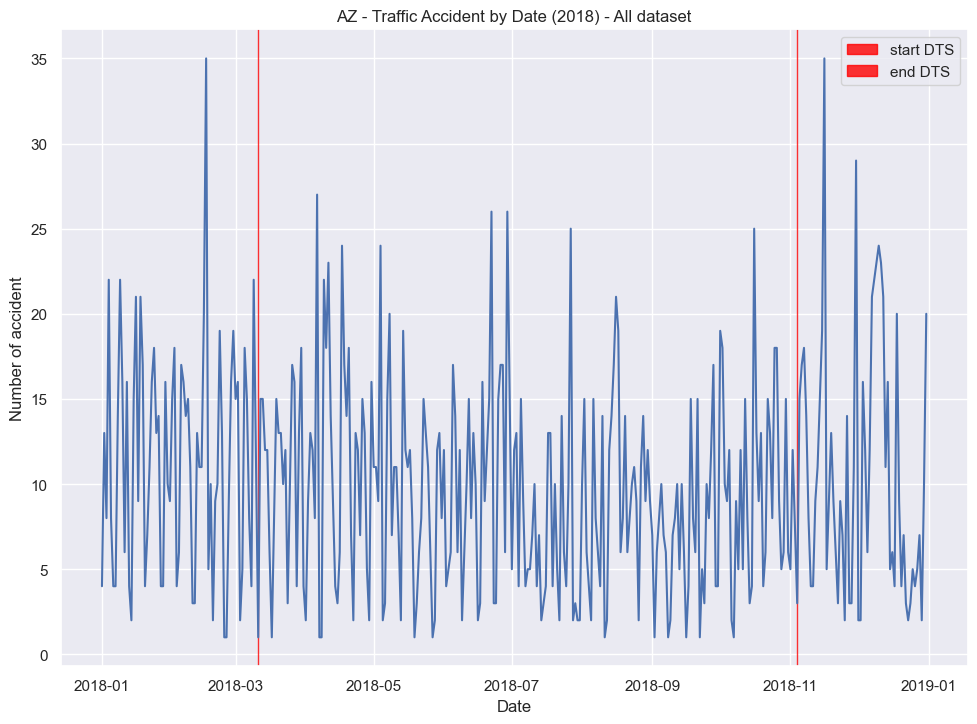

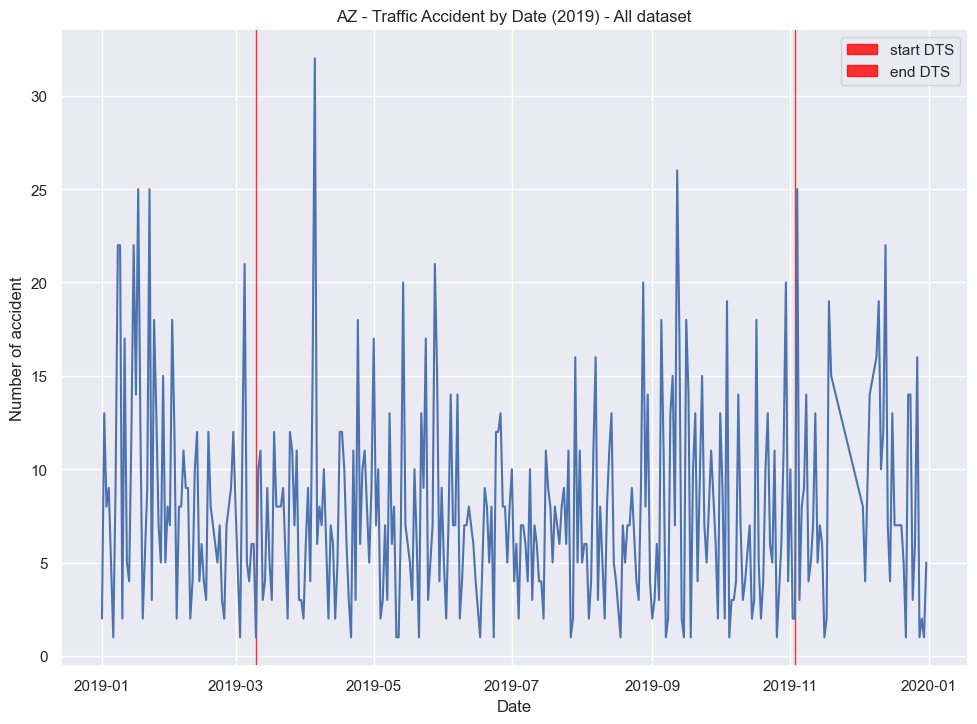

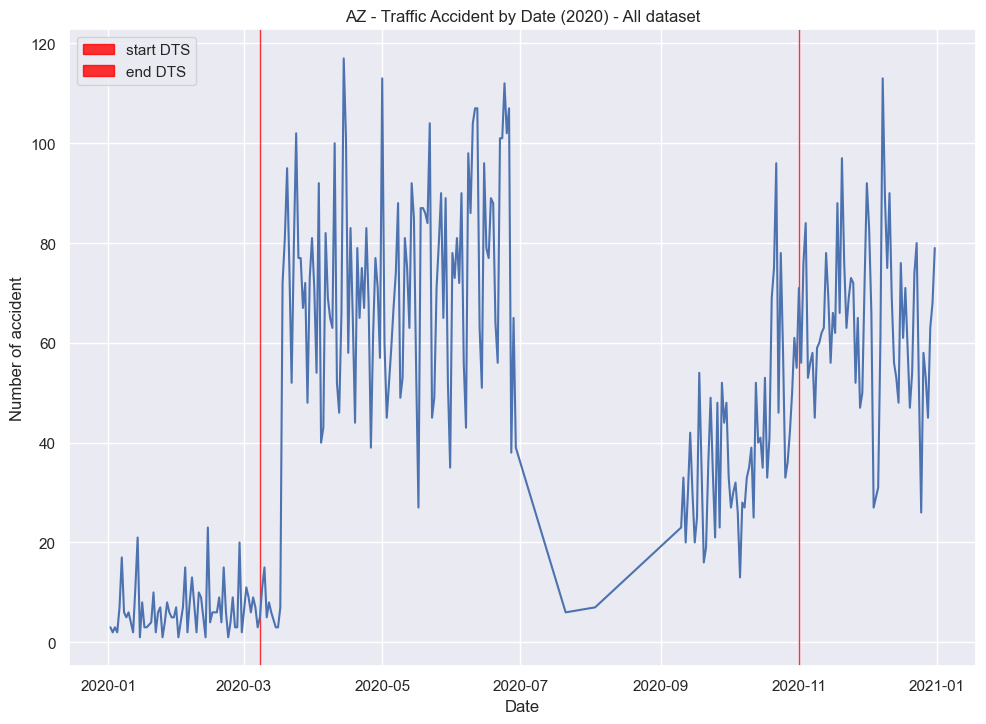

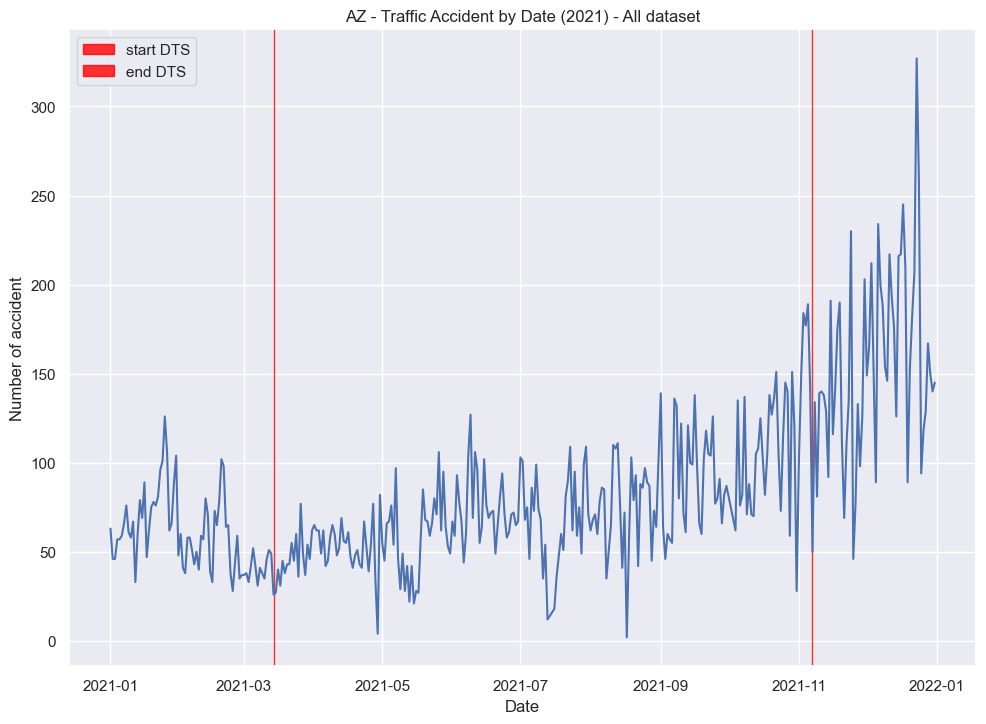

In [135]:
for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    plt.figure(year)
    plt.axvspan(date2num(daylight_dates[year]['start']), date2num(daylight_dates[year]['start']), 
           label="start DTS",color="red", alpha=0.8)
    plt.axvspan(date2num(daylight_dates[year]['end']), date2num(daylight_dates[year]['end']), 
           label="end DTS",color="red", alpha=0.8)
    sns.lineplot(x="Date", y="Number of accident", data=grouped_az[grouped_az['Year'] == year]).set(title=f'AZ - Traffic Accident by Date ({year}) - All dataset')

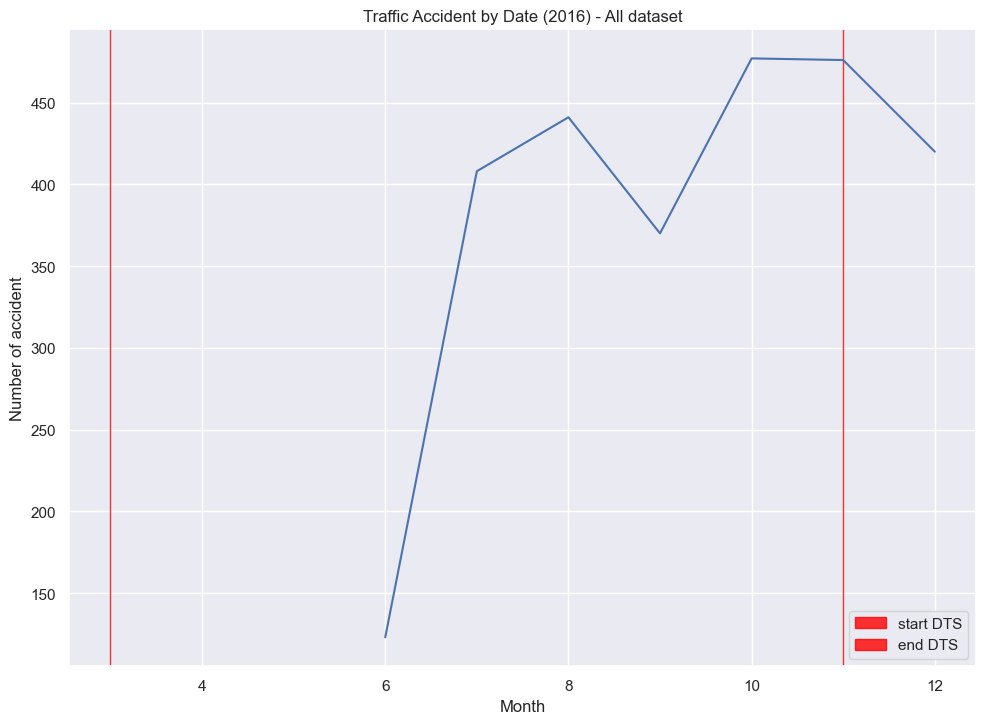

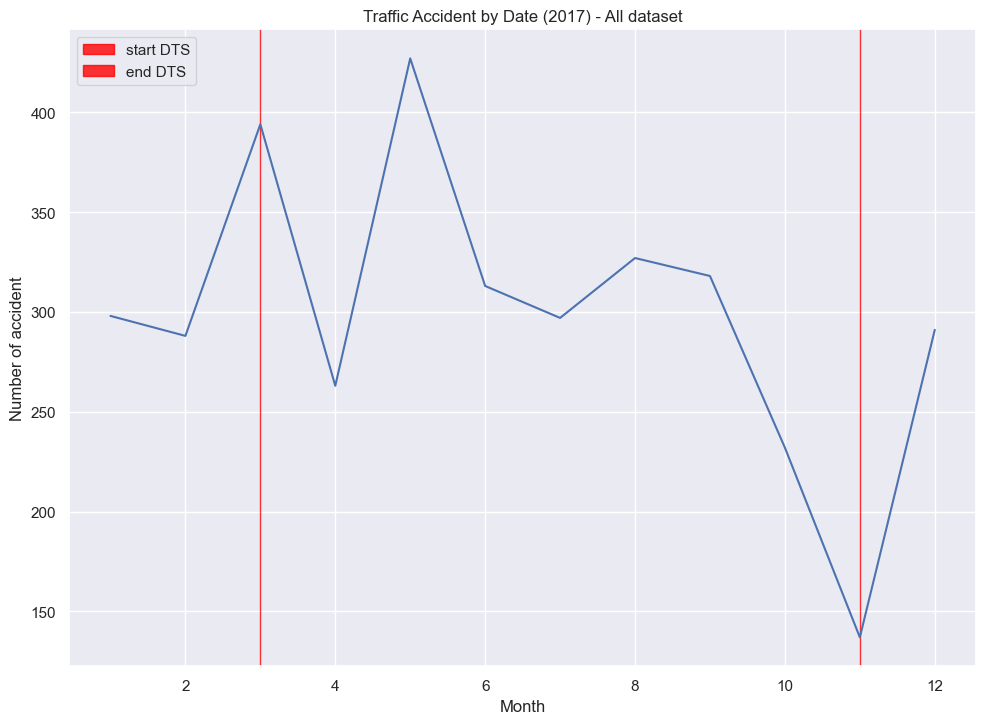

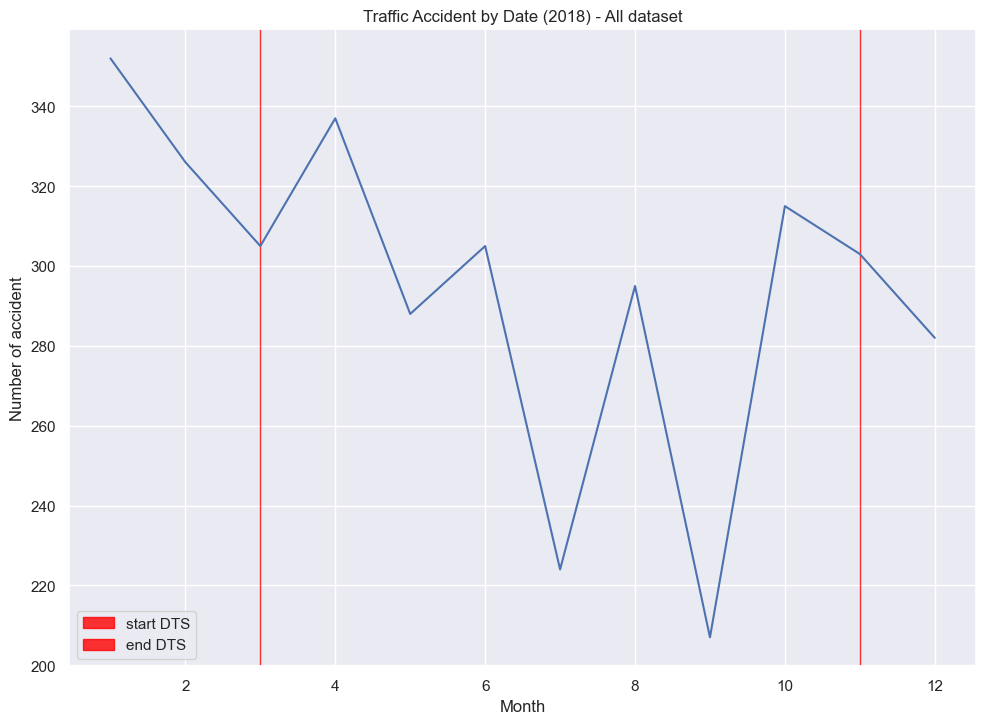

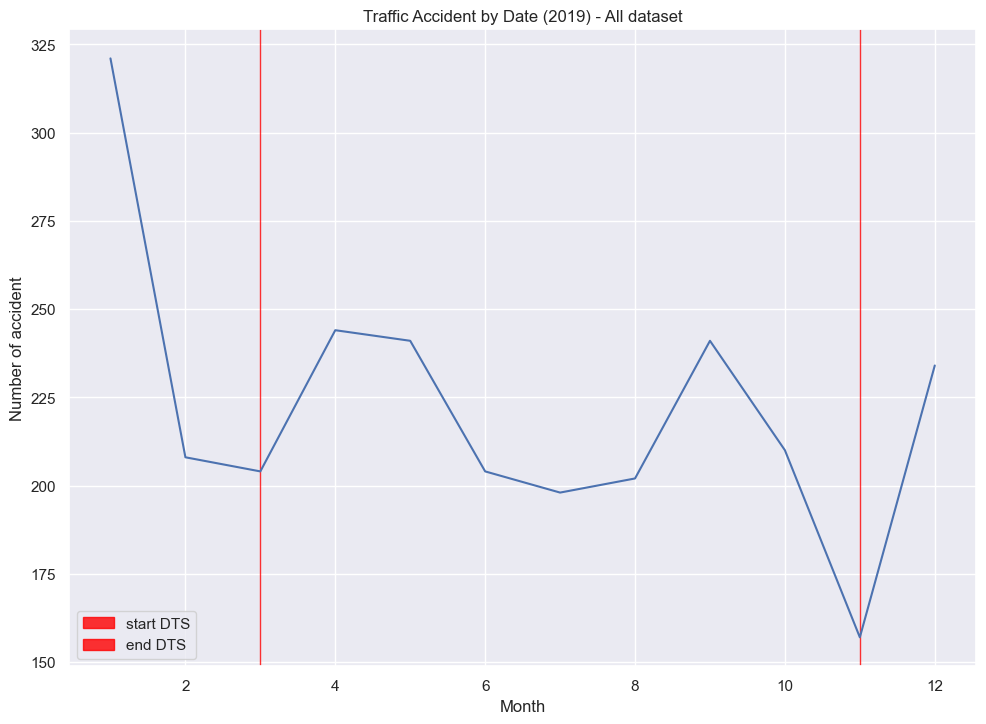

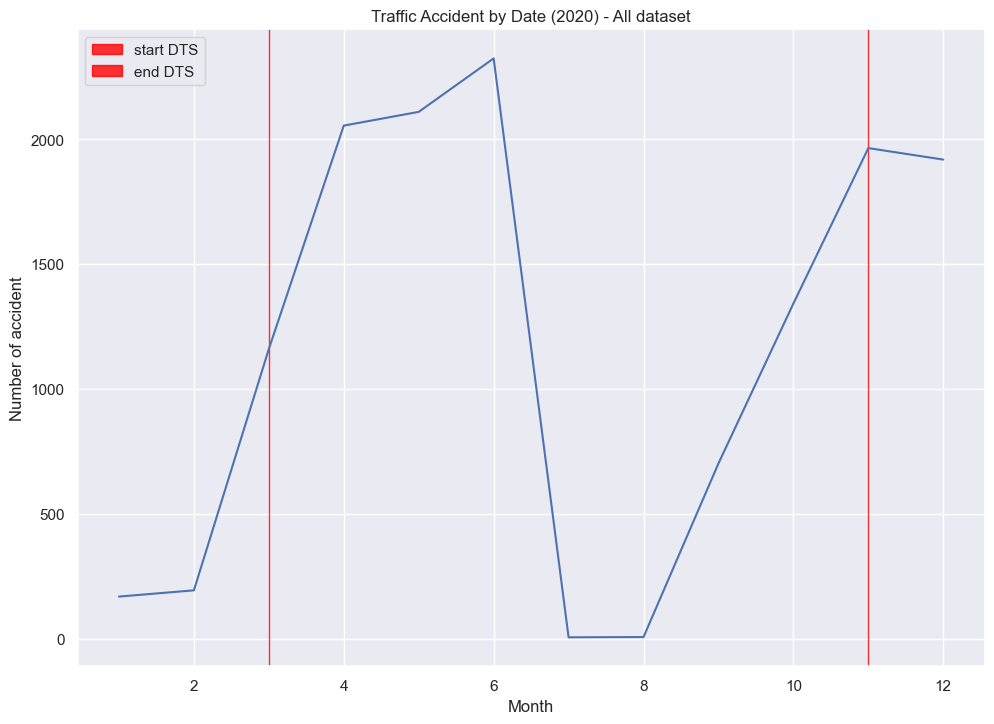

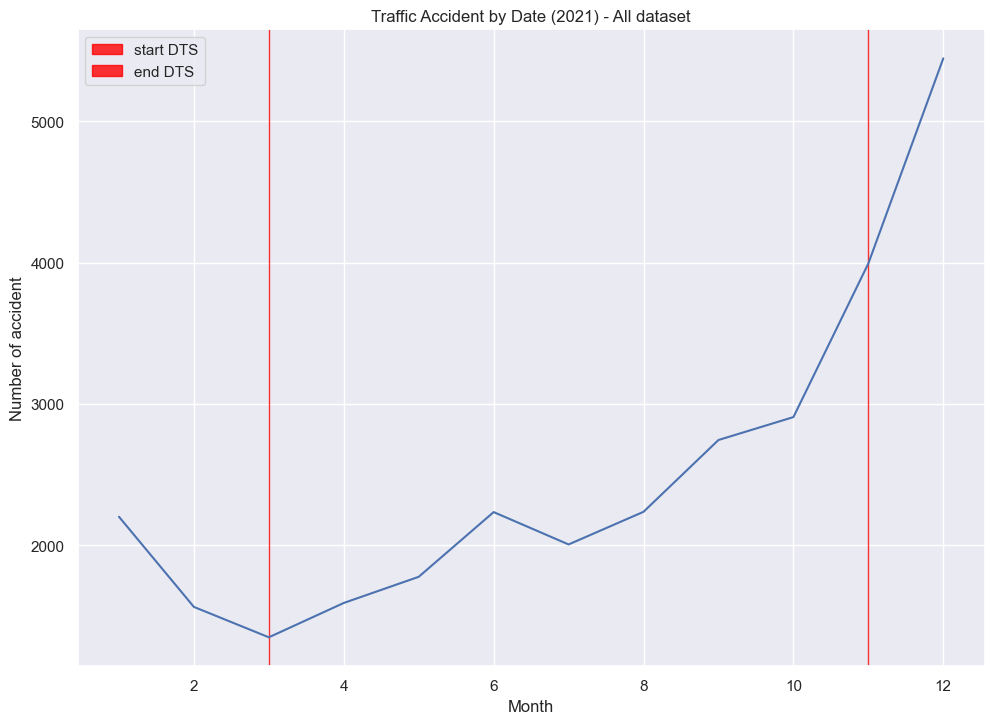

In [134]:
grouped_by_month = df[df["State"] == "AZ"].groupby(['Month', 'Year'])['Month'].count().reset_index(name='Number of accident')
for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    plt.figure(year)
    plt.axvspan(daylight_dates[year]['start'].month, daylight_dates[year]['start'].month, 
           label="start DTS",color="red", alpha=0.8)
    plt.axvspan(daylight_dates[year]['end'].month, daylight_dates[year]['end'].month, 
           label="end DTS",color="red", alpha=0.8)
    sns.lineplot(x="Month", y="Number of accident", data=grouped_by_month[grouped_by_month['Year'] == year]).set(title=f'Traffic Accident by Date ({year}) - All dataset')

In [162]:
grouped['Date'] = pd.to_datetime(grouped['Date'])
accident = grouped.set_index('Date')

In [164]:
y = accident['Number of accident'].resample('MS').mean()

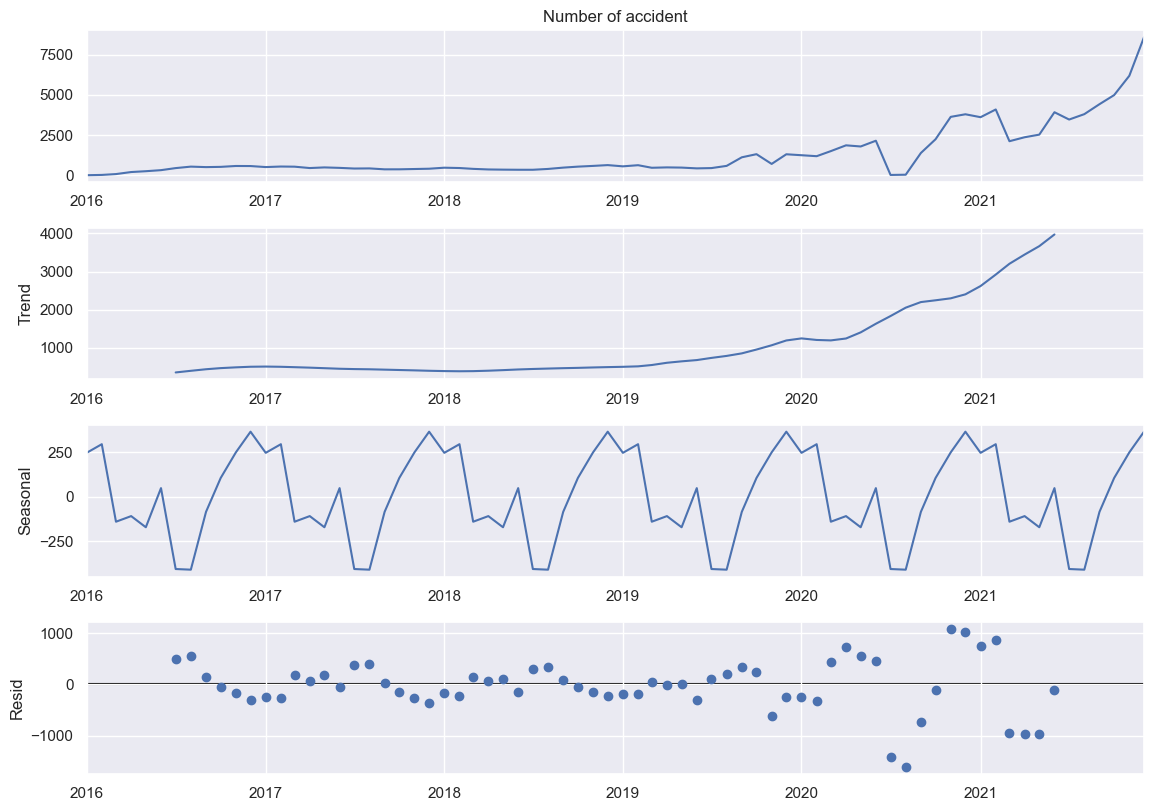

In [165]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [148]:
grouped['Number of accident']

0           7
1          22
2          24
3          32
4          58
        ...  
2094     8777
2095     8220
2096     8698
2097    10171
2098     6936
Name: Number of accident, Length: 2099, dtype: int64